In [3]:
# !pip install tensorflow==2.10.0

# !pip install pandas-datareader==0.10.0

  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached libclang-14.0.6-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-a

In [1]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader

from tqdm import tqdm_notebook, tqdm
from collections import deque

In [2]:
print(data_reader.__version__)
print(tf.__version__)

0.10.0
2.10.0


In [3]:
class AI_Trader():
  
    def __init__(self, state_size, action_space=3, model_name="AITrader"):

        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque(maxlen = 2000)
        self.inventory = []
        self.model = self.model_builder()
        self.model_name = self.model.name

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.995
  
    def model_builder(self):

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer="Adam")
        
        return model

    def trade(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])
    
    def batch_train(self, batch_size):

        batch = []
        for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
            batch.append(self.memory[i])

        for state, action, reward, next_state, done in batch:
            target = self.model.predict(state)

        if not done:
            target[0][action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        target[0][action] = reward

        self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

In [4]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [5]:
def stocks_price_format(n):
    if n < 0:
        return "- # {0:2f}".format(abs(n))
    else:
        return "$ {0:2f}".format(abs(n))

In [6]:
def dataset_loader(stock_name):

    dataset = data_reader.DataReader(stock_name, data_source="yahoo")

    start_date = str(dataset.index[0]).split()[0]
    end_date = str(dataset.index[1]).split()[0]

    close = dataset['Close']

    return close

In [7]:
def state_creator(data, timestep, window_size):
  
    starting_id = timestep - window_size + 1
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep+1]
    else:
        windowed_data = starting_id * [data[0]] + list(data[0:timestep+1])
        
    state = []
    for i in range(window_size - 1):
        state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))

    return np.array([state])

In [8]:
stock_name = "AAPL"
data = dataset_loader(stock_name).iloc[-80:]
data

Date
2022-07-25    152.949997
2022-07-26    151.600006
2022-07-27    156.789993
2022-07-28    157.350006
2022-07-29    162.509995
                 ...    
2022-11-08    139.500000
2022-11-09    134.869995
2022-11-10    146.869995
2022-11-11    149.699997
2022-11-14    148.279999
Name: Close, Length: 80, dtype: float64

In [9]:
window_size = 5
episodes = 100

batch_size = 8
data_samples = len(data) - 1

In [10]:
trader = AI_Trader(window_size)
print(1)
trader.model.summary()

1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


In [11]:
total_pro = []
for episode in range(1, episodes + 1):
  
    print("Episode: {}/{}".format(episode, episodes))

    state = state_creator(data, 10, window_size + 1)

    action = [0]
    total_profit = 0
    trader.inventory = []

    # for t in tqdm(range(data_samples)):
    for t in tqdm(range(window_size,data_samples)):
  
        action = trader.trade(state)

        next_state = state_creator(data, t+1, window_size + 1)
        reward = 0

        if action == 1: #Buying
            trader.inventory.append(data[t])
            print("AI Trader bought: ", stocks_price_format(data[t]))
      
        elif action == 2 and len(trader.inventory) > 0: #Selling
            buy_price = trader.inventory.pop(0)

            reward = max(data[t] - buy_price, 0)
            total_profit += data[t] - buy_price
            print("AI Trader sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price) )

        if t == data_samples - 1:
            done = True
        else:
            done = False
      
        trader.memory.append((state, action, reward, next_state, done))

        state = next_state

        if done:
            print("########################")
            print("TOTAL PROFIT: {}".format(total_profit))
            print("########################")
            total_pro.append(total_profit)
        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)
      
    if episode % 10 == 0:
        trader.model.save("ai_trader_{}.h5".format(episode))

Episode: 1/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

AI Trader bought:  $ 165.809998
AI Trader sold:  $ 164.869995  Profit: - # 0.940002
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 47ms/step


 12%|██████████                                                                         | 9/74 [00:03<00:23,  2.76it/s]

AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 48ms/step


 14%|███████████                                                                       | 10/74 [00:04<00:32,  1.99it/s]

AI Trader sold:  $ 173.190002  Profit: $ 3.949997
1/1 [==============================] - 0s 48ms/step


 15%|████████████▏                                                                     | 11/74 [00:06<00:43,  1.46it/s]

AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 39ms/step


 16%|█████████████▎                                                                    | 12/74 [00:07<00:48,  1.28it/s]

AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 43ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:52,  1.15it/s]

1/1 [==============================] - 0s 39ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:56,  1.06it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<01:00,  1.03s/it]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<01:03,  1.09s/it]

AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<01:04,  1.13s/it]

1/1 [==============================] - 0s 58ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<01:04,  1.16s/it]

AI Trader sold:  $ 170.029999  Profit: - # 2.070007
1/1 [==============================] - 0s 47ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<01:03,  1.15s/it]

AI Trader sold:  $ 163.619995  Profit: - # 9.410004
1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:17<01:04,  1.19s/it]

AI Trader sold:  $ 161.380005  Profit: - # 13.169998
1/1 [==============================] - 0s 35ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:18<01:04,  1.21s/it]

AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:19<01:01,  1.18s/it]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:20<01:01,  1.20s/it]

AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 51ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:22<01:03,  1.28s/it]

1/1 [==============================] - 0s 59ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:23<01:01,  1.26s/it]

AI Trader sold:  $ 154.529999  Profit: - # 12.699997
1/1 [==============================] - 0s 43ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:24<01:01,  1.28s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 38ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:26<00:59,  1.26s/it]

AI Trader sold:  $ 154.460007  Profit: - # 3.500000
1/1 [==============================] - 0s 55ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:27<00:58,  1.27s/it]

1/1 [==============================] - 0s 48ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:28<00:54,  1.22s/it]

1/1 [==============================] - 0s 33ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:29<00:52,  1.19s/it]

AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 43ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:30<00:50,  1.17s/it]

AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 46ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:32<00:51,  1.23s/it]

AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 34ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:33<00:49,  1.21s/it]

AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 49ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:34<00:48,  1.22s/it]

1/1 [==============================] - 0s 55ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:35<00:48,  1.25s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 156.899994  Profit: $ 3.059998
1/1 [==============================] - 0s 49ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:37<00:49,  1.31s/it]

AI Trader sold:  $ 153.720001  Profit: - # 1.589996
1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:38<00:48,  1.30s/it]

1/1 [==============================] - 0s 36ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:39<00:45,  1.26s/it]

AI Trader sold:  $ 150.429993  Profit: - # 1.940002
1/1 [==============================] - 0s 43ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:40<00:43,  1.25s/it]

1/1 [==============================] - 0s 46ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:42<00:43,  1.29s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 38ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:43<00:43,  1.33s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:45<00:42,  1.33s/it]

AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 52ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:46<00:42,  1.36s/it]

AI Trader sold:  $ 138.199997  Profit: - # 4.279999
1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:47<00:40,  1.34s/it]

1/1 [==============================] - 0s 45ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:49<00:38,  1.33s/it]

1/1 [==============================] - 0s 37ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:50<00:37,  1.35s/it]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:51<00:36,  1.36s/it]

1/1 [==============================] - 0s 44ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:53<00:34,  1.34s/it]

AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:54<00:32,  1.28s/it]

1/1 [==============================] - 0s 59ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:55<00:30,  1.27s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 54ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:56<00:29,  1.30s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:58<00:29,  1.35s/it]

1/1 [==============================] - 0s 47ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:59<00:27,  1.32s/it]

1/1 [==============================] - 0s 52ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:00<00:25,  1.25s/it]

1/1 [==============================] - 0s 42ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:01<00:23,  1.22s/it]

AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 42ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:03<00:21,  1.21s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 36ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:04<00:20,  1.21s/it]

1/1 [==============================] - 0s 51ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:05<00:20,  1.30s/it]

1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:07<00:20,  1.36s/it]

1/1 [==============================] - 0s 50ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:08<00:19,  1.36s/it]

AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:10<00:17,  1.37s/it]

AI Trader sold:  $ 149.350006  Profit: - # 2.989990
1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:11<00:15,  1.31s/it]

1/1 [==============================] - 0s 42ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:12<00:13,  1.25s/it]

AI Trader bought:  $ 155.740005
1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:13<00:12,  1.22s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 153.339996  Profit: - # 2.400009
1/1 [==============================] - 0s 53ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:14<00:11,  1.23s/it]

1/1 [==============================] - 0s 50ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:16<00:09,  1.24s/it]

AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:17<00:08,  1.21s/it]

1/1 [==============================] - 0s 62ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:18<00:07,  1.24s/it]

AI Trader sold:  $ 138.380005  Profit: - # 6.649994
1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:19<00:06,  1.25s/it]

1/1 [==============================] - 0s 35ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:21<00:05,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:22<00:03,  1.30s/it]

1/1 [==============================] - 0s 39ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:24<00:02,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:25<00:01,  1.42s/it]

########################
TOTAL PROFIT: -57.52000427246094
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:26<00:00,  1.17s/it]


Episode: 2/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 47ms/step


  1%|█                                                                                  | 1/74 [00:01<01:30,  1.24s/it]

1/1 [==============================] - 0s 37ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:33,  1.30s/it]

AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 41ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:30,  1.27s/it]

1/1 [==============================] - 0s 49ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:36,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:34,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:35,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:31,  1.36s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:24,  1.28s/it]

AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 49ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:18,  1.21s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 46ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:18,  1.23s/it]

AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 46ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:15,  1.20s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 44ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:16,  1.23s/it]

1/1 [==============================] - 0s 61ms/step


 18%|██████████████▍                                                                   | 13/74 [00:16<01:14,  1.22s/it]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:11,  1.19s/it]

1/1 [==============================] - 0s 55ms/step


 20%|████████████████▌                                                                 | 15/74 [00:18<01:12,  1.22s/it]

1/1 [==============================] - 0s 56ms/step


 22%|█████████████████▋                                                                | 16/74 [00:20<01:15,  1.30s/it]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▊                                                               | 17/74 [00:21<01:13,  1.29s/it]

AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 43ms/step


 24%|███████████████████▉                                                              | 18/74 [00:22<01:11,  1.28s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.500000
1/1 [==============================] - 0s 51ms/step


 26%|█████████████████████                                                             | 19/74 [00:24<01:11,  1.30s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:25<01:09,  1.29s/it]

1/1 [==============================] - 0s 42ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:26<01:07,  1.27s/it]

AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 46ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:05,  1.26s/it]

1/1 [==============================] - 0s 39ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:29<01:02,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:30<01:00,  1.21s/it]

AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:31<00:58,  1.19s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 154.529999  Profit: - # 4.380005
1/1 [==============================] - 0s 46ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:32<00:57,  1.21s/it]

AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:33<00:55,  1.17s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 154.460007  Profit: - # 1.349991
1/1 [==============================] - 0s 47ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:35<00:55,  1.21s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 157.369995  Profit: $ 1.409988
1/1 [==============================] - 0s 70ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:36<00:56,  1.26s/it]

1/1 [==============================] - 0s 34ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:37<00:54,  1.25s/it]

1/1 [==============================] - 0s 44ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:38<00:53,  1.24s/it]

1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:40<00:53,  1.26s/it]

AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 49ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:41<00:50,  1.23s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 150.699997  Profit: - # 1.669998
1/1 [==============================] - 0s 51ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:42<00:49,  1.25s/it]

1/1 [==============================] - 0s 50ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:43<00:48,  1.25s/it]

1/1 [==============================] - 0s 50ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:45<00:50,  1.33s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:47<00:51,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:48<00:48,  1.35s/it]

1/1 [==============================] - 0s 41ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:49<00:47,  1.37s/it]

1/1 [==============================] - 0s 48ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:50<00:45,  1.33s/it]

1/1 [==============================] - 0s 58ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:52<00:41,  1.27s/it]

AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:53<00:39,  1.24s/it]

AI Trader sold:  $ 142.479996  Profit: - # 7.360001
1/1 [==============================] - 0s 47ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:54<00:38,  1.26s/it]

AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:55<00:37,  1.24s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 45ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:57<00:36,  1.27s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:58<00:36,  1.29s/it]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:59<00:34,  1.28s/it]

1/1 [==============================] - 0s 42ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:01<00:33,  1.31s/it]

1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:02<00:31,  1.26s/it]

1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:03<00:30,  1.28s/it]

1/1 [==============================] - 0s 47ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:04<00:30,  1.31s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:06<00:28,  1.29s/it]

AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 48ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:07<00:25,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:08<00:23,  1.18s/it]

AI Trader sold:  $ 142.410004  Profit: - # 0.580002
1/1 [==============================] - 0s 45ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:09<00:22,  1.18s/it]

1/1 [==============================] - 0s 43ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:11<00:23,  1.30s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:12<00:21,  1.27s/it]

1/1 [==============================] - 0s 45ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:13<00:19,  1.23s/it]

AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:14<00:17,  1.18s/it]

1/1 [==============================] - 0s 42ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:15<00:16,  1.16s/it]

AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:16<00:14,  1.12s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 35ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:17<00:13,  1.15s/it]

1/1 [==============================] - 0s 41ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:18<00:12,  1.13s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.740005  Profit: $ 8.470001
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:20<00:11,  1.15s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 46ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:21<00:10,  1.16s/it]

AI Trader sold:  $ 150.649994  Profit: - # 1.690002
1/1 [==============================] - 0s 46ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:22<00:09,  1.15s/it]

AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:23<00:07,  1.13s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:24<00:06,  1.15s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:25<00:05,  1.13s/it]

AI Trader sold:  $ 138.919998  Profit: - # 10.430008
1/1 [==============================] - 0s 36ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:26<00:04,  1.10s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 139.500000  Profit: - # 13.839996
1/1 [==============================] - 0s 37ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:28<00:03,  1.15s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 134.869995  Profit: - # 10.160004
1/1 [==============================] - 0s 45ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:29<00:02,  1.18s/it]

AI Trader bought:  $ 146.869995
1/1 [==============================] - 0s 37ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:30<00:01,  1.16s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.819992
########################
TOTAL PROFIT: -15.940017700195312
########################
1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:31<00:00,  1.24s/it]


Episode: 3/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  1%|█                                                                                  | 1/74 [00:01<01:26,  1.19s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:36,  1.34s/it]

1/1 [==============================] - 0s 49ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:30,  1.27s/it]

1/1 [==============================] - 0s 48ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:23,  1.19s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:21,  1.18s/it]

AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 43ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:19,  1.17s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:18,  1.17s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 169.240005  Profit: $ 4.370010
1/1 [==============================] - 0s 43ms/step


 11%|████████▉                                                                          | 8/74 [00:09<01:21,  1.23s/it]

1/1 [==============================] - 0s 51ms/step


 12%|██████████                                                                         | 9/74 [00:10<01:18,  1.21s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:18,  1.22s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:17,  1.23s/it]

1/1 [==============================] - 0s 34ms/step


 16%|█████████████▎                                                                    | 12/74 [00:14<01:16,  1.23s/it]

1/1 [==============================] - 0s 39ms/step


 18%|██████████████▍                                                                   | 13/74 [00:15<01:15,  1.23s/it]

1/1 [==============================] - 0s 34ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:14,  1.24s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▌                                                                 | 15/74 [00:18<01:15,  1.27s/it]

1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▋                                                                | 16/74 [00:19<01:13,  1.26s/it]

1/1 [==============================] - 0s 54ms/step


 23%|██████████████████▊                                                               | 17/74 [00:20<01:12,  1.27s/it]

1/1 [==============================] - 0s 41ms/step


 24%|███████████████████▉                                                              | 18/74 [00:22<01:08,  1.23s/it]

AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████                                                             | 19/74 [00:23<01:06,  1.21s/it]

AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:24<01:08,  1.26s/it]

1/1 [==============================] - 0s 33ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:25<01:06,  1.25s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 158.910004  Profit: - # 11.119995
1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:27<01:03,  1.23s/it]

AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 42ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:28<01:01,  1.21s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 157.960007  Profit: - # 5.659988
1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:29<01:03,  1.27s/it]

AI Trader sold:  $ 155.809998  Profit: - # 1.410004
1/1 [==============================] - 0s 46ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:30<01:00,  1.23s/it]

1/1 [==============================] - 0s 42ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:32<00:59,  1.24s/it]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:33<00:56,  1.20s/it]

1/1 [==============================] - 0s 59ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:34<00:56,  1.23s/it]

1/1 [==============================] - 0s 40ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:35<00:56,  1.25s/it]

1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:37<00:55,  1.26s/it]

1/1 [==============================] - 0s 34ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:38<00:54,  1.28s/it]

1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:39<00:53,  1.27s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 34ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:40<00:51,  1.26s/it]

AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 38ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:41<00:48,  1.20s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 43ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:43<00:47,  1.23s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 36ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:44<00:46,  1.22s/it]

AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 66ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:45<00:44,  1.20s/it]

1/1 [==============================] - 0s 34ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:46<00:43,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:48<00:45,  1.30s/it]

AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 39ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:49<00:42,  1.25s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 151.759995  Profit: - # 1.960007
1/1 [==============================] - 0s 43ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:50<00:42,  1.28s/it]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:51<00:40,  1.26s/it]

1/1 [==============================] - 0s 51ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:53<00:36,  1.19s/it]

1/1 [==============================] - 0s 58ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:54<00:36,  1.20s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 142.449997  Profit: - # 8.320007
1/1 [==============================] - 0s 54ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:55<00:35,  1.22s/it]

1/1 [==============================] - 0s 54ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:56<00:35,  1.27s/it]

1/1 [==============================] - 0s 57ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:58<00:34,  1.26s/it]

AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 45ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:59<00:31,  1.21s/it]

1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:00<00:30,  1.24s/it]

1/1 [==============================] - 0s 36ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:01<00:28,  1.20s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 138.979996  Profit: - # 6.449997
1/1 [==============================] - 0s 43ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:02<00:27,  1.20s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:04<00:26,  1.19s/it]

1/1 [==============================] - 0s 58ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:05<00:24,  1.17s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:06<00:23,  1.16s/it]

AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 47ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:07<00:22,  1.16s/it]

1/1 [==============================] - 0s 38ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:08<00:21,  1.21s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:10<00:21,  1.25s/it]

1/1 [==============================] - 0s 61ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:11<00:20,  1.28s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:13<00:20,  1.37s/it]

1/1 [==============================] - 0s 51ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:14<00:19,  1.36s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:15<00:17,  1.34s/it]

1/1 [==============================] - 0s 52ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:17<00:16,  1.37s/it]

AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:18<00:15,  1.39s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 155.740005  Profit: $ 10.940002
1/1 [==============================] - 0s 55ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:20<00:14,  1.45s/it]

1/1 [==============================] - 0s 37ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:21<00:12,  1.41s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 35ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:22<00:10,  1.36s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 145.029999  Profit: - # 5.619995
1/1 [==============================] - 0s 47ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:23<00:09,  1.33s/it]

1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:25<00:07,  1.29s/it]

1/1 [==============================] - 0s 58ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:26<00:06,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:27<00:05,  1.26s/it]

1/1 [==============================] - 0s 34ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:28<00:03,  1.24s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 41ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:29<00:02,  1.23s/it]

1/1 [==============================] - 0s 39ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:31<00:01,  1.26s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 1.9400177001953125
########################
1/1 [==============================] - 0s 53ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:32<00:00,  1.25s/it]


Episode: 4/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  1%|█                                                                                  | 1/74 [00:01<01:38,  1.35s/it]

1/1 [==============================] - 0s 39ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:36,  1.35s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:42,  1.45s/it]

1/1 [==============================] - 0s 55ms/step


  5%|████▍                                                                              | 4/74 [00:06<01:58,  1.69s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▌                                                                             | 5/74 [00:08<01:58,  1.72s/it]

1/1 [==============================] - 0s 61ms/step


  8%|██████▋                                                                            | 6/74 [00:09<01:51,  1.64s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▊                                                                           | 7/74 [00:11<01:51,  1.66s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▉                                                                          | 8/74 [00:12<01:47,  1.63s/it]

AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 44ms/step


 12%|██████████                                                                         | 9/74 [00:14<01:44,  1.60s/it]

AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 62ms/step


 14%|███████████                                                                       | 10/74 [00:15<01:37,  1.52s/it]

AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 56ms/step


 15%|████████████▏                                                                     | 11/74 [00:17<01:32,  1.47s/it]

AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 59ms/step


 16%|█████████████▎                                                                    | 12/74 [00:18<01:25,  1.38s/it]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████▍                                                                   | 13/74 [00:19<01:26,  1.41s/it]

AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 49ms/step


 19%|███████████████▌                                                                  | 14/74 [00:21<01:22,  1.38s/it]

AI Trader sold:  $ 171.520004  Profit: - # 2.629990
1/1 [==============================] - 0s 36ms/step


 20%|████████████████▌                                                                 | 15/74 [00:22<01:19,  1.34s/it]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▋                                                                | 16/74 [00:23<01:18,  1.35s/it]

1/1 [==============================] - 0s 60ms/step


 23%|██████████████████▊                                                               | 17/74 [00:25<01:18,  1.38s/it]

1/1 [==============================] - 0s 54ms/step


 24%|███████████████████▉                                                              | 18/74 [00:26<01:18,  1.40s/it]

AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 44ms/step


 26%|█████████████████████                                                             | 19/74 [00:27<01:16,  1.39s/it]

AI Trader sold:  $ 163.619995  Profit: - # 6.410004
1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:29<01:13,  1.36s/it]

1/1 [==============================] - 0s 43ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:30<01:14,  1.40s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:32<01:20,  1.55s/it]

1/1 [==============================] - 0s 53ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:34<01:21,  1.60s/it]

1/1 [==============================] - 0s 53ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:35<01:20,  1.61s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:37<01:18,  1.61s/it]

1/1 [==============================] - 0s 43ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:39<01:15,  1.56s/it]

1/1 [==============================] - 0s 65ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:40<01:11,  1.53s/it]

1/1 [==============================] - 0s 59ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:41<01:09,  1.52s/it]

1/1 [==============================] - 0s 59ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:43<01:08,  1.53s/it]

1/1 [==============================] - 0s 91ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:45<01:08,  1.56s/it]

AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 53ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:46<01:04,  1.49s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:48<01:02,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:49<01:04,  1.58s/it]

1/1 [==============================] - 0s 47ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:51<01:00,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:52<01:01,  1.56s/it]

1/1 [==============================] - 0s 52ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:54<01:00,  1.58s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:55<00:56,  1.53s/it]

AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 65ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:57<00:53,  1.50s/it]

AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 61ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:58<00:52,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.970001
1/1 [==============================] - 0s 52ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [01:00<00:50,  1.49s/it]

1/1 [==============================] - 0s 68ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 51ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [01:01<00:49,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [01:03<00:52,  1.65s/it]

1/1 [==============================] - 0s 66ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [01:05<00:51,  1.66s/it]

1/1 [==============================] - 0s 57ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:07<00:49,  1.66s/it]

1/1 [==============================] - 0s 39ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:08<00:46,  1.59s/it]

AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 43ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:10<00:44,  1.58s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 146.399994  Profit: $ 0.299988
1/1 [==============================] - 0s 58ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:11<00:42,  1.58s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 49ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:13<00:40,  1.55s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:14<00:38,  1.53s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 57ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:16<00:37,  1.55s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 42ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:17<00:35,  1.56s/it]

1/1 [==============================] - 0s 56ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:19<00:32,  1.47s/it]

1/1 [==============================] - 0s 59ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:20<00:29,  1.39s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 35ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:21<00:26,  1.33s/it]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:22<00:23,  1.26s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 49ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:23<00:22,  1.23s/it]

1/1 [==============================] - 0s 38ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:24<00:20,  1.23s/it]

1/1 [==============================] - 0s 54ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:26<00:20,  1.26s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:27<00:19,  1.28s/it]

1/1 [==============================] - 0s 45ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:28<00:17,  1.28s/it]

1/1 [==============================] - 0s 47ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:30<00:17,  1.32s/it]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:31<00:14,  1.23s/it]

1/1 [==============================] - 0s 43ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:32<00:12,  1.18s/it]

1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:33<00:11,  1.17s/it]

1/1 [==============================] - 0s 37ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:34<00:10,  1.17s/it]

1/1 [==============================] - 0s 47ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:35<00:09,  1.17s/it]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:37<00:08,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:38<00:06,  1.17s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:39<00:05,  1.17s/it]

1/1 [==============================] - 0s 37ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:40<00:04,  1.17s/it]

1/1 [==============================] - 0s 49ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:41<00:03,  1.18s/it]

1/1 [==============================] - 0s 38ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:43<00:02,  1.24s/it]

AI Trader bought:  $ 146.869995
1/1 [==============================] - 0s 41ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:44<00:01,  1.26s/it]

AI Trader bought:  $ 149.699997
########################
TOTAL PROFIT: -5.2100067138671875
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:45<00:00,  1.43s/it]


Episode: 5/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  1%|█                                                                                  | 1/74 [00:01<01:43,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:34,  1.31s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:37,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:37,  1.39s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 36ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:34,  1.37s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 164.869995  Profit: - # 0.480011
1/1 [==============================] - 0s 40ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:35,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:30,  1.34s/it]

1/1 [==============================] - 0s 44ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:27,  1.32s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 50ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:22,  1.27s/it]

AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 44ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:22,  1.28s/it]

1/1 [==============================] - 0s 42ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:23,  1.33s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 40ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:21,  1.32s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader sold:  $ 174.550003  Profit: $ 1.520004
1/1 [==============================] - 0s 38ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:18,  1.29s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 41ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:16,  1.27s/it]

1/1 [==============================] - 0s 64ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:11,  1.22s/it]

1/1 [==============================] - 0s 58ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:16,  1.32s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:14,  1.31s/it]

1/1 [==============================] - 0s 40ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:13,  1.32s/it]

1/1 [==============================] - 0s 33ms/step


 26%|█████████████████████                                                             | 19/74 [00:24<01:11,  1.29s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:26<01:09,  1.28s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 36ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:27<01:06,  1.25s/it]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:01,  1.18s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:29<01:03,  1.24s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 157.960007  Profit: - # 5.659988
1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:30<01:00,  1.20s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 155.809998  Profit: - # 5.570007
1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:32<00:58,  1.20s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 154.529999  Profit: - # 2.690002
1/1 [==============================] - 0s 51ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:33<01:02,  1.30s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:35<01:06,  1.42s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 57ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:36<01:02,  1.36s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 49ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:37<01:00,  1.35s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:39<00:58,  1.34s/it]

1/1 [==============================] - 0s 42ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:40<00:56,  1.31s/it]

AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:41<00:51,  1.23s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 35ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:42<00:49,  1.22s/it]

AI Trader sold:  $ 150.699997  Profit: - # 4.610001
1/1 [==============================] - 0s 47ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:43<00:48,  1.21s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 35ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:45<00:46,  1.20s/it]

1/1 [==============================] - 0s 45ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:46<00:46,  1.22s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:47<00:45,  1.23s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 42ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:48<00:44,  1.24s/it]

1/1 [==============================] - 0s 44ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:50<00:44,  1.28s/it]

1/1 [==============================] - 0s 44ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:51<00:42,  1.26s/it]

1/1 [==============================] - 0s 38ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:52<00:40,  1.23s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:54<00:42,  1.32s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 142.479996  Profit: - # 7.360001
1/1 [==============================] - 0s 46ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:55<00:39,  1.29s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:56<00:38,  1.28s/it]

1/1 [==============================] - 0s 35ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:57<00:36,  1.27s/it]

1/1 [==============================] - 0s 37ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:59<00:35,  1.27s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:00<00:34,  1.27s/it]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:01<00:32,  1.27s/it]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:02<00:31,  1.25s/it]

1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:04<00:29,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:05<00:27,  1.22s/it]

1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:06<00:26,  1.21s/it]

AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 36ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:07<00:24,  1.17s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 48ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:08<00:23,  1.17s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 142.410004  Profit: - # 0.580002
1/1 [==============================] - 0s 51ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:09<00:22,  1.19s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 38ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:11<00:21,  1.20s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:12<00:20,  1.19s/it]

1/1 [==============================] - 0s 57ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:13<00:19,  1.25s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:14<00:18,  1.24s/it]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:16<00:17,  1.26s/it]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:17<00:16,  1.26s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 54ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:18<00:15,  1.32s/it]

1/1 [==============================] - 0s 41ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:20<00:14,  1.29s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:21<00:12,  1.27s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 34ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:22<00:11,  1.23s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:23<00:09,  1.22s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 145.029999  Profit: - # 8.309998
1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:24<00:08,  1.22s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:26<00:07,  1.23s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.380005  Profit: - # 12.269989
1/1 [==============================] - 0s 45ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:27<00:06,  1.22s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 48ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:28<00:04,  1.22s/it]

1/1 [==============================] - 0s 37ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:29<00:03,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:30<00:02,  1.21s/it]

1/1 [==============================] - 0s 34ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:32<00:01,  1.20s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: -30.07000732421875
########################
1/1 [==============================] - 0s 34ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:33<00:00,  1.26s/it]


Episode: 6/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


  1%|█                                                                                  | 1/74 [00:01<01:39,  1.36s/it]

1/1 [==============================] - 0s 67ms/step


  3%|██▏                                                                                | 2/74 [00:03<01:53,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:53,  1.60s/it]

1/1 [==============================] - 0s 43ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:43,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▌                                                                             | 5/74 [00:07<01:35,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:38,  1.46s/it]

1/1 [==============================] - 0s 58ms/step


  9%|███████▊                                                                           | 7/74 [00:10<01:37,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▉                                                                          | 8/74 [00:11<01:31,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:27,  1.34s/it]

1/1 [==============================] - 0s 34ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:22,  1.30s/it]

AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 40ms/step


 15%|████████████▏                                                                     | 11/74 [00:15<01:16,  1.22s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 46ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:15,  1.22s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 174.550003  Profit: $ 1.360001
1/1 [==============================] - 0s 55ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:13,  1.21s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 174.149994  Profit: $ 1.119995
1/1 [==============================] - 0s 34ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:11,  1.20s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 34ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:10,  1.20s/it]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▋                                                                | 16/74 [00:20<01:09,  1.20s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 56ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:08,  1.20s/it]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:07,  1.21s/it]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████                                                             | 19/74 [00:24<01:05,  1.19s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:25<01:04,  1.19s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 57ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:26<01:03,  1.20s/it]

AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:01,  1.18s/it]

1/1 [==============================] - 0s 44ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:29<01:02,  1.22s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 157.960007  Profit: - # 3.419998
1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:30<01:00,  1.21s/it]

1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:31<00:58,  1.19s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 36ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:32<00:57,  1.19s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:34<00:57,  1.23s/it]

1/1 [==============================] - 0s 38ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:35<00:56,  1.24s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.839996
1/1 [==============================] - 0s 36ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:36<00:54,  1.21s/it]

AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 39ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:37<00:50,  1.15s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 36ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:38<00:49,  1.15s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:39<00:47,  1.13s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 152.369995  Profit: - # 11.059998
1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:41<00:46,  1.14s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 56ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:42<00:46,  1.17s/it]

AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 43ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:43<00:45,  1.16s/it]

AI Trader sold:  $ 156.899994  Profit: $ 3.059998
1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:44<00:43,  1.14s/it]

1/1 [==============================] - 0s 55ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:45<00:45,  1.22s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 152.740005  Profit: $ 2.040009
1/1 [==============================] - 0s 40ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:47<00:47,  1.33s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 150.429993  Profit: - # 4.050003
1/1 [==============================] - 0s 49ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:49<00:47,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:50<00:47,  1.38s/it]

1/1 [==============================] - 0s 61ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:51<00:45,  1.38s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:53<00:45,  1.43s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 142.479996  Profit: - # 7.360001
1/1 [==============================] - 0s 56ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:55<00:48,  1.56s/it]

1/1 [==============================] - 0s 55ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:56<00:46,  1.57s/it]

1/1 [==============================] - 0s 39ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:58<00:44,  1.52s/it]

AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 46ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:59<00:39,  1.43s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 146.399994  Profit: $ 0.299988
1/1 [==============================] - 0s 59ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:00<00:37,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:02<00:36,  1.40s/it]

1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:03<00:33,  1.34s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:04<00:31,  1.30s/it]

AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 47ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:05<00:28,  1.23s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 138.339996  Profit: - # 0.639999
1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:06<00:27,  1.23s/it]

1/1 [==============================] - 0s 43ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:08<00:25,  1.22s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 52ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:09<00:24,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:10<00:22,  1.18s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 37ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:11<00:21,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:12<00:20,  1.19s/it]

1/1 [==============================] - 0s 40ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:13<00:19,  1.19s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:15<00:17,  1.20s/it]

1/1 [==============================] - 0s 42ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:16<00:16,  1.21s/it]

1/1 [==============================] - 0s 34ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:17<00:15,  1.21s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:19<00:15,  1.28s/it]

1/1 [==============================] - 0s 34ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:20<00:13,  1.26s/it]

1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:21<00:12,  1.24s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 48ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:22<00:11,  1.28s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 150.649994  Profit: - # 2.690002
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:24<00:10,  1.35s/it]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:26<00:10,  1.44s/it]

1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:27<00:08,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:28<00:06,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:30<00:05,  1.39s/it]

1/1 [==============================] - 0s 48ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:31<00:04,  1.37s/it]

1/1 [==============================] - 0s 49ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:32<00:02,  1.35s/it]

1/1 [==============================] - 0s 50ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:34<00:01,  1.34s/it]

1/1 [==============================] - 0s 41ms/step
########################
TOTAL PROFIT: -20.370025634765625
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:35<00:00,  1.29s/it]


Episode: 7/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  1%|█                                                                                  | 1/74 [00:01<01:26,  1.18s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 42ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:37,  1.36s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 42ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:36,  1.35s/it]

1/1 [==============================] - 0s 50ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:32,  1.32s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 50ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:30,  1.31s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 164.869995  Profit: - # 0.480011
1/1 [==============================] - 0s 56ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:29,  1.31s/it]

1/1 [==============================] - 0s 46ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:33,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:30,  1.37s/it]

AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 37ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:26,  1.32s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 42ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:23,  1.31s/it]

1/1 [==============================] - 0s 35ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:22,  1.32s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 37ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:21,  1.31s/it]

1/1 [==============================] - 0s 44ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:18,  1.29s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 174.149994  Profit: $ 1.119995
1/1 [==============================] - 0s 47ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:17,  1.30s/it]

AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 48ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:13,  1.25s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 167.570007  Profit: - # 3.949997
1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▋                                                                | 16/74 [00:20<01:11,  1.24s/it]

1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:10,  1.24s/it]

1/1 [==============================] - 0s 55ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:09,  1.25s/it]

1/1 [==============================] - 0s 56ms/step


 26%|█████████████████████                                                             | 19/74 [00:24<01:09,  1.26s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:25<01:08,  1.26s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 46ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:27<01:06,  1.26s/it]

1/1 [==============================] - 0s 46ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:05,  1.27s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 34ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:29<01:05,  1.28s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 157.960007  Profit: $ 0.740005
1/1 [==============================] - 0s 52ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:31<01:07,  1.36s/it]

AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 49ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:32<01:05,  1.34s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 154.529999  Profit: - # 1.279999
1/1 [==============================] - 0s 47ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:33<01:04,  1.35s/it]

1/1 [==============================] - 0s 46ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:35<01:02,  1.34s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 51ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:36<01:02,  1.37s/it]

1/1 [==============================] - 0s 55ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:37<00:59,  1.32s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 163.429993  Profit: $ 8.969986
1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:39<00:58,  1.33s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 60ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:40<00:58,  1.36s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:42<00:57,  1.37s/it]

1/1 [==============================] - 0s 56ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:43<00:55,  1.35s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 43ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:44<00:53,  1.33s/it]

AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 39ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:45<00:49,  1.27s/it]

1/1 [==============================] - 0s 46ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:46<00:46,  1.23s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:48<00:45,  1.22s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 36ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:49<00:44,  1.22s/it]

1/1 [==============================] - 0s 40ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:50<00:41,  1.17s/it]

1/1 [==============================] - 0s 48ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:51<00:41,  1.22s/it]

1/1 [==============================] - 0s 34ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:52<00:40,  1.24s/it]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:54<00:40,  1.25s/it]

1/1 [==============================] - 0s 38ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:55<00:41,  1.33s/it]

1/1 [==============================] - 0s 51ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:56<00:38,  1.29s/it]

1/1 [==============================] - 0s 60ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:58<00:37,  1.29s/it]

1/1 [==============================] - 0s 41ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:59<00:35,  1.27s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:00<00:34,  1.26s/it]

1/1 [==============================] - 0s 66ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:02<00:33,  1.28s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:03<00:32,  1.30s/it]

1/1 [==============================] - 0s 45ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:04<00:31,  1.30s/it]

1/1 [==============================] - 0s 41ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:05<00:28,  1.25s/it]

1/1 [==============================] - 0s 53ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:07<00:27,  1.27s/it]

1/1 [==============================] - 0s 49ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:08<00:26,  1.28s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:09<00:25,  1.26s/it]

1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:10<00:23,  1.26s/it]

1/1 [==============================] - 0s 56ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:12<00:22,  1.24s/it]

1/1 [==============================] - 0s 38ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:13<00:20,  1.21s/it]

1/1 [==============================] - 0s 55ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:14<00:19,  1.23s/it]

AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:15<00:18,  1.22s/it]

AI Trader sold:  $ 149.449997  Profit: $ 2.179993
1/1 [==============================] - 0s 46ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:16<00:16,  1.21s/it]

1/1 [==============================] - 0s 54ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:18<00:15,  1.20s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:19<00:15,  1.26s/it]

1/1 [==============================] - 0s 39ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:21<00:15,  1.41s/it]

1/1 [==============================] - 0s 53ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:22<00:13,  1.38s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:23<00:11,  1.33s/it]

1/1 [==============================] - 0s 42ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:25<00:10,  1.31s/it]

1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:26<00:09,  1.31s/it]

1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:27<00:07,  1.30s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:28<00:06,  1.29s/it]

1/1 [==============================] - 0s 42ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:30<00:05,  1.28s/it]

1/1 [==============================] - 0s 48ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:31<00:03,  1.28s/it]

1/1 [==============================] - 0s 39ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:32<00:02,  1.27s/it]

1/1 [==============================] - 0s 49ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:33<00:01,  1.28s/it]

1/1 [==============================] - 0s 58ms/step
########################
TOTAL PROFIT: 19.05999755859375
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:35<00:00,  1.29s/it]


Episode: 8/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                                  | 1/74 [00:01<01:31,  1.25s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 56ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:27,  1.22s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 35ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:26,  1.22s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 165.809998
1/1 [==============================] - 0s 46ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:25,  1.22s/it]

AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 38ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:21,  1.19s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 164.869995  Profit: - # 0.940002
1/1 [==============================] - 0s 45ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:22,  1.21s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 164.919998  Profit: - # 0.430008
1/1 [==============================] - 0s 66ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:29,  1.33s/it]

1/1 [==============================] - 0s 51ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:29,  1.35s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 54ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:32,  1.42s/it]

AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 56ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:33,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 173.190002  Profit: $ 4.699997
1/1 [==============================] - 0s 53ms/step


 15%|████████████▏                                                                     | 11/74 [00:15<01:36,  1.53s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 46ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:30,  1.45s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 174.550003  Profit: $ 2.449997
1/1 [==============================] - 0s 49ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:24,  1.38s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 174.149994  Profit: $ 1.119995
1/1 [==============================] - 0s 35ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:18,  1.32s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 37ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:16,  1.29s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 34ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:13,  1.26s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 34ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:10,  1.23s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 49ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:07,  1.20s/it]

1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████                                                             | 19/74 [00:24<01:05,  1.20s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:25<01:04,  1.20s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 37ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:26<01:02,  1.19s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:00,  1.16s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:29<00:59,  1.16s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 157.960007  Profit: $ 0.740005
1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:30<01:01,  1.22s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:31<00:59,  1.22s/it]

1/1 [==============================] - 0s 34ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:32<00:57,  1.20s/it]

1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:34<00:55,  1.19s/it]

1/1 [==============================] - 0s 41ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:35<00:55,  1.21s/it]

1/1 [==============================] - 0s 36ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:36<00:51,  1.15s/it]

1/1 [==============================] - 0s 34ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:37<00:50,  1.16s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 40ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:38<00:49,  1.16s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 45ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:39<00:49,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:41<00:48,  1.19s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 34ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:42<00:47,  1.19s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 38ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:43<00:46,  1.20s/it]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:44<00:45,  1.20s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:46<00:44,  1.20s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 45ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:47<00:43,  1.20s/it]

1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:48<00:42,  1.21s/it]

1/1 [==============================] - 0s 35ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:49<00:41,  1.21s/it]

AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 40ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:50<00:38,  1.16s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:51<00:37,  1.16s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.479996  Profit: - # 9.279999
1/1 [==============================] - 0s 54ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:53<00:41,  1.33s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.199997  Profit: - # 11.639999
1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:54<00:40,  1.35s/it]

1/1 [==============================] - 0s 34ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:56<00:39,  1.35s/it]

1/1 [==============================] - 0s 47ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:57<00:37,  1.34s/it]

1/1 [==============================] - 0s 45ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:58<00:36,  1.34s/it]

1/1 [==============================] - 0s 45ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:00<00:34,  1.33s/it]

1/1 [==============================] - 0s 45ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:01<00:33,  1.34s/it]

AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 36ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:02<00:31,  1.30s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.440002
1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:04<00:29,  1.27s/it]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:05<00:26,  1.22s/it]

1/1 [==============================] - 0s 56ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:06<00:25,  1.23s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 56ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:07<00:25,  1.25s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 78ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:09<00:26,  1.37s/it]

1/1 [==============================] - 0s 44ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:10<00:25,  1.41s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 48ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:12<00:23,  1.39s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 143.389999  Profit: - # 0.470001
1/1 [==============================] - 0s 44ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:13<00:22,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:15<00:21,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:16<00:20,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:18<00:18,  1.44s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 35ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:19<00:18,  1.52s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 47ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:21<00:16,  1.47s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:22<00:14,  1.48s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 51ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:24<00:12,  1.44s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 39ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:25<00:11,  1.42s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 145.029999  Profit: $ 0.229996
1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:26<00:09,  1.41s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 50ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:28<00:08,  1.42s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:29<00:07,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:31<00:05,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:32<00:04,  1.39s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 38ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:33<00:02,  1.40s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 146.869995  Profit: - # 3.779999
1/1 [==============================] - 0s 42ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:35<00:01,  1.38s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.819992
########################
TOTAL PROFIT: -8.6400146484375
########################
1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:36<00:00,  1.30s/it]


Episode: 9/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                                  | 1/74 [00:01<01:42,  1.40s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 50ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:39,  1.39s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:37,  1.37s/it]

1/1 [==============================] - 0s 48ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:34,  1.35s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:32,  1.34s/it]

1/1 [==============================] - 0s 39ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:30,  1.33s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:36,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▉                                                                          | 8/74 [00:11<01:32,  1.40s/it]

1/1 [==============================] - 0s 34ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:28,  1.36s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:25,  1.33s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:22,  1.31s/it]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:20,  1.29s/it]

1/1 [==============================] - 0s 49ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:18,  1.29s/it]

1/1 [==============================] - 0s 50ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:18,  1.32s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 42ms/step


 20%|████████████████▌                                                                 | 15/74 [00:20<01:16,  1.30s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 167.570007  Profit: - # 3.949997
1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:15,  1.30s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:13,  1.30s/it]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:13,  1.32s/it]

1/1 [==============================] - 0s 36ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:13,  1.34s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 61ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:26<01:12,  1.34s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 42ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:28<01:11,  1.34s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 158.910004  Profit: - # 4.709991
1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:29<01:09,  1.33s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:30<01:06,  1.31s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 157.960007  Profit: - # 3.419998
1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:32<01:10,  1.40s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 53ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:33<01:09,  1.41s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 54ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:35<01:10,  1.47s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.960007  Profit: - # 1.259995
1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:36<01:10,  1.51s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 56ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:38<01:13,  1.59s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 157.369995  Profit: $ 1.559998
1/1 [==============================] - 0s 42ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:40<01:10,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 163.429993  Profit: $ 8.899994
1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:41<01:06,  1.51s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 46ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:43<01:05,  1.53s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.309998  Profit: $ 0.849991
1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:44<01:03,  1.50s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 45ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:46<01:01,  1.49s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 39ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:47<00:58,  1.46s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 154.479996  Profit: $ 0.639999
1/1 [==============================] - 0s 50ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:48<00:54,  1.40s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 41ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:49<00:52,  1.38s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 53ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:51<00:56,  1.53s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 152.740005  Profit: $ 2.040009
1/1 [==============================] - 0s 41ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:53<00:55,  1.55s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 150.429993  Profit: - # 3.290009
1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:54<00:53,  1.52s/it]

1/1 [==============================] - 0s 52ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:57<00:57,  1.70s/it]

1/1 [==============================] - 0s 42ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:58<00:55,  1.67s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [01:00<00:50,  1.57s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 41ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [01:02<00:53,  1.74s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.199997  Profit: - # 11.639999
1/1 [==============================] - 0s 66ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:03<00:49,  1.66s/it]

1/1 [==============================] - 0s 64ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 49ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:05<00:47,  1.63s/it]

1/1 [==============================] - 0s 46ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:06<00:43,  1.57s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:07<00:40,  1.48s/it]

1/1 [==============================] - 0s 54ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:09<00:37,  1.44s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 57ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:10<00:36,  1.47s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 35ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:12<00:35,  1.50s/it]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:13<00:31,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:14<00:29,  1.34s/it]

1/1 [==============================] - 0s 35ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:15<00:27,  1.29s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:17<00:25,  1.27s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 42ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:18<00:24,  1.29s/it]

1/1 [==============================] - 0s 116ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:20<00:26,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:21<00:24,  1.45s/it]

1/1 [==============================] - 0s 71ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:23<00:22,  1.43s/it]

1/1 [==============================] - 0s 55ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:24<00:21,  1.43s/it]

1/1 [==============================] - 0s 60ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:25<00:19,  1.40s/it]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:27<00:18,  1.42s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 56ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:29<00:18,  1.54s/it]

1/1 [==============================] - 0s 68ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 41ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:30<00:16,  1.54s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 51ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:32<00:15,  1.52s/it]

1/1 [==============================] - 0s 54ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:33<00:13,  1.51s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 46ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:35<00:12,  1.58s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 145.029999  Profit: $ 0.229996
1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:36<00:10,  1.57s/it]

1/1 [==============================] - 0s 39ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:38<00:09,  1.55s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 138.380005  Profit: - # 12.269989
1/1 [==============================] - 0s 45ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:39<00:07,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:41<00:05,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:42<00:04,  1.50s/it]

1/1 [==============================] - 0s 37ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:43<00:02,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:45<00:01,  1.43s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: -4.949981689453125
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:46<00:00,  1.44s/it]


Episode: 10/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                                  | 1/74 [00:01<01:35,  1.30s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 46ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:39,  1.38s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 44ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:43,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:34,  1.34s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 53ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:35,  1.39s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 164.869995  Profit: - # 0.480011
1/1 [==============================] - 0s 41ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:35,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


  9%|███████▊                                                                           | 7/74 [00:10<01:40,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 11%|████████▉                                                                          | 8/74 [00:11<01:37,  1.48s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 47ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:36,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 52ms/step


 14%|███████████                                                                       | 10/74 [00:14<01:34,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 15%|████████████▏                                                                     | 11/74 [00:15<01:28,  1.41s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 39ms/step


 16%|█████████████▎                                                                    | 12/74 [00:17<01:25,  1.38s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader sold:  $ 174.550003  Profit: $ 1.520004
1/1 [==============================] - 0s 49ms/step


 18%|██████████████▍                                                                   | 13/74 [00:18<01:27,  1.44s/it]

1/1 [==============================] - 0s 54ms/step


 19%|███████████████▌                                                                  | 14/74 [00:19<01:23,  1.39s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 51ms/step


 20%|████████████████▌                                                                 | 15/74 [00:21<01:22,  1.41s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 50ms/step


 22%|█████████████████▋                                                                | 16/74 [00:22<01:25,  1.47s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▊                                                               | 17/74 [00:24<01:21,  1.44s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 48ms/step


 24%|███████████████████▉                                                              | 18/74 [00:25<01:19,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 26%|█████████████████████                                                             | 19/74 [00:26<01:16,  1.39s/it]

1/1 [==============================] - 0s 52ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:28<01:16,  1.41s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 44ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:29<01:14,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:31<01:14,  1.44s/it]

1/1 [==============================] - 0s 58ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:33<01:17,  1.53s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 157.960007  Profit: - # 3.419998
1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:34<01:14,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:35<01:10,  1.44s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 60ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:37<01:11,  1.48s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 155.960007  Profit: $ 1.430008
1/1 [==============================] - 0s 51ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:39<01:13,  1.56s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 54ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:40<01:13,  1.59s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 55ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:42<01:11,  1.59s/it]

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:43<01:06,  1.51s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 42ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:44<01:01,  1.43s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:46<00:57,  1.37s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 36ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:47<00:55,  1.34s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 34ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:48<00:51,  1.29s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 48ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:49<00:49,  1.28s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 44ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:51<00:51,  1.35s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 36ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:52<00:52,  1.41s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 40ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:54<00:51,  1.44s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 52ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:55<00:51,  1.46s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 35ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:57<00:47,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:58<00:43,  1.32s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [01:00<00:46,  1.47s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 48ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [01:01<00:44,  1.42s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:02<00:42,  1.40s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.389999
1/1 [==============================] - 0s 40ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:04<00:39,  1.38s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 38ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:05<00:37,  1.33s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 146.399994  Profit: $ 8.199997
1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:06<00:34,  1.29s/it]

1/1 [==============================] - 0s 56ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:07<00:33,  1.28s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:09<00:31,  1.27s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:10<00:31,  1.32s/it]

1/1 [==============================] - 0s 43ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:11<00:30,  1.31s/it]

1/1 [==============================] - 0s 35ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:13<00:30,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:14<00:27,  1.33s/it]

1/1 [==============================] - 0s 48ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:16<00:29,  1.47s/it]

1/1 [==============================] - 0s 65ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:17<00:27,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:19<00:25,  1.43s/it]

1/1 [==============================] - 0s 51ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:20<00:24,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:21<00:22,  1.41s/it]

1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:23<00:20,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:24<00:19,  1.40s/it]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:26<00:20,  1.61s/it]

1/1 [==============================] - 0s 62ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:28<00:18,  1.57s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 39ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:29<00:16,  1.53s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 155.740005  Profit: $ 10.940002
1/1 [==============================] - 0s 53ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:31<00:15,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:32<00:14,  1.56s/it]

1/1 [==============================] - 0s 48ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:34<00:12,  1.52s/it]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:35<00:10,  1.44s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 47ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:36<00:08,  1.39s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.380005  Profit: - # 0.500000
1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:38<00:06,  1.36s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:39<00:05,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:41<00:04,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:42<00:03,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:44<00:01,  1.48s/it]

1/1 [==============================] - 0s 56ms/step
########################
TOTAL PROFIT: 31.70001220703125
########################
1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:45<00:00,  1.42s/it]


Episode: 11/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  1%|█                                                                                  | 1/74 [00:01<01:33,  1.27s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 38ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:27,  1.22s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 38ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:27,  1.23s/it]

1/1 [==============================] - 0s 41ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:29,  1.28s/it]

1/1 [==============================] - 0s 51ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:30,  1.31s/it]

1/1 [==============================] - 0s 35ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:29,  1.32s/it]

1/1 [==============================] - 0s 44ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:22,  1.23s/it]

1/1 [==============================] - 0s 51ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:21,  1.23s/it]

1/1 [==============================] - 0s 39ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:21,  1.25s/it]

1/1 [==============================] - 0s 35ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:19,  1.24s/it]

1/1 [==============================] - 0s 44ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:18,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:17,  1.26s/it]

1/1 [==============================] - 0s 34ms/step


 18%|██████████████▍                                                                   | 13/74 [00:16<01:18,  1.28s/it]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:16,  1.27s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:16,  1.30s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▋                                                                | 16/74 [00:20<01:19,  1.36s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▊                                                               | 17/74 [00:21<01:18,  1.37s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 55ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:21,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 26%|█████████████████████                                                             | 19/74 [00:24<01:17,  1.41s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:26<01:15,  1.40s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 44ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:27<01:15,  1.42s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:11,  1.37s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 47ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:30<01:10,  1.39s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 157.960007  Profit: - # 5.659988
1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:31<01:06,  1.33s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:32<01:03,  1.30s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 35ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:33<01:00,  1.26s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.960007  Profit: - # 5.419998
1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:35<01:00,  1.28s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 45ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:36<01:00,  1.31s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 157.369995  Profit: - # 1.540009
1/1 [==============================] - 0s 35ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:37<00:57,  1.28s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 163.429993  Profit: $ 6.209991
1/1 [==============================] - 0s 39ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:39<00:55,  1.25s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 46ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:40<00:54,  1.28s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 155.309998  Profit: - # 0.500000
1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:41<00:52,  1.26s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 36ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:42<00:51,  1.25s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 38ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:44<00:49,  1.23s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 154.479996  Profit: - # 0.050003
1/1 [==============================] - 0s 43ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:45<00:48,  1.23s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 156.899994  Profit: $ 2.439987
1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:46<00:47,  1.24s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:47<00:45,  1.22s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 46ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:48<00:43,  1.22s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 35ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:50<00:42,  1.21s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 150.770004  Profit: - # 3.069992
1/1 [==============================] - 0s 55ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:51<00:42,  1.26s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.610001
1/1 [==============================] - 0s 43ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:52<00:43,  1.33s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:54<00:45,  1.42s/it]

AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 42ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:55<00:43,  1.39s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:57<00:43,  1.44s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.449997  Profit: - # 8.250000
1/1 [==============================] - 0s 55ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:58<00:40,  1.40s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader sold:  $ 146.100006  Profit: - # 7.619995
1/1 [==============================] - 0s 102ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:00<00:42,  1.53s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 146.399994  Profit: - # 6.340012
1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:02<00:40,  1.51s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 51ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:03<00:38,  1.49s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 57ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:05<00:38,  1.54s/it]

AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 47ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:06<00:35,  1.47s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:07<00:32,  1.42s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 138.339996  Profit: - # 12.089996
1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:09<00:29,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.990005  Profit: - # 6.849991
1/1 [==============================] - 0s 40ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:10<00:27,  1.32s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:11<00:25,  1.29s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.410004  Profit: - # 0.069992
1/1 [==============================] - 0s 36ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:12<00:23,  1.25s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.550003
1/1 [==============================] - 0s 56ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:13<00:22,  1.25s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 56ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:15<00:21,  1.24s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 38ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:16<00:19,  1.24s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 147.270004  Profit: $ 1.840012
1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:17<00:18,  1.22s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 149.449997  Profit: $ 9.360001
1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:18<00:16,  1.21s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 152.339996  Profit: $ 11.919998
1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:20<00:16,  1.28s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:21<00:15,  1.27s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 37ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:22<00:13,  1.24s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 155.740005  Profit: $ 16.760010
1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:23<00:12,  1.24s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 46ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:24<00:10,  1.22s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 150.649994  Profit: $ 12.269989
1/1 [==============================] - 0s 47ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:26<00:09,  1.21s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 145.029999  Profit: $ 1.169998
1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:27<00:08,  1.21s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.880005  Profit: - # 4.509995
1/1 [==============================] - 0s 34ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:28<00:07,  1.21s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.380005  Profit: - # 10.970001
1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:29<00:06,  1.21s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.919998  Profit: - # 5.880005
1/1 [==============================] - 0s 36ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:31<00:04,  1.21s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 139.500000  Profit: - # 13.839996
1/1 [==============================] - 0s 56ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:32<00:03,  1.21s/it]

1/1 [==============================] - 0s 37ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:33<00:02,  1.23s/it]

1/1 [==============================] - 0s 37ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:34<00:01,  1.22s/it]

1/1 [==============================] - 0s 42ms/step
########################
TOTAL PROFIT: -23.959991455078125
########################
1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:35<00:00,  1.29s/it]


Episode: 12/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                                  | 1/74 [00:01<01:25,  1.17s/it]

1/1 [==============================] - 0s 36ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:25,  1.19s/it]

1/1 [==============================] - 0s 36ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:24,  1.19s/it]

1/1 [==============================] - 0s 41ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:22,  1.18s/it]

1/1 [==============================] - 0s 34ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:27,  1.27s/it]

1/1 [==============================] - 0s 35ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:24,  1.24s/it]

1/1 [==============================] - 0s 35ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:20,  1.20s/it]

1/1 [==============================] - 0s 39ms/step


 11%|████████▉                                                                          | 8/74 [00:09<01:19,  1.20s/it]

1/1 [==============================] - 0s 42ms/step


 12%|██████████                                                                         | 9/74 [00:10<01:18,  1.20s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:16,  1.19s/it]

1/1 [==============================] - 0s 43ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:16,  1.21s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▎                                                                    | 12/74 [00:14<01:14,  1.20s/it]

1/1 [==============================] - 0s 34ms/step


 18%|██████████████▍                                                                   | 13/74 [00:15<01:12,  1.19s/it]

1/1 [==============================] - 0s 39ms/step


 19%|███████████████▌                                                                  | 14/74 [00:16<01:11,  1.19s/it]

1/1 [==============================] - 0s 36ms/step


 20%|████████████████▌                                                                 | 15/74 [00:17<01:09,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▋                                                                | 16/74 [00:19<01:10,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▊                                                               | 17/74 [00:20<01:07,  1.18s/it]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▉                                                              | 18/74 [00:21<01:06,  1.19s/it]

1/1 [==============================] - 0s 43ms/step


 26%|█████████████████████                                                             | 19/74 [00:22<01:06,  1.20s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:24<01:04,  1.20s/it]

1/1 [==============================] - 0s 36ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:25<01:03,  1.19s/it]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:26<01:05,  1.26s/it]

1/1 [==============================] - 0s 45ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:27<01:03,  1.25s/it]

1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:29<01:02,  1.25s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:30<01:00,  1.23s/it]

1/1 [==============================] - 0s 51ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:31<00:59,  1.24s/it]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:32<00:56,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:33<00:55,  1.21s/it]

1/1 [==============================] - 0s 39ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:35<00:55,  1.22s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:36<00:53,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:37<00:50,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:38<00:51,  1.22s/it]

1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:40<00:50,  1.24s/it]

1/1 [==============================] - 0s 41ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:41<00:49,  1.24s/it]

1/1 [==============================] - 0s 37ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:42<00:48,  1.24s/it]

1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:43<00:46,  1.23s/it]

1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:44<00:45,  1.22s/it]

1/1 [==============================] - 0s 51ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:46<00:43,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:47<00:42,  1.20s/it]

1/1 [==============================] - 0s 36ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:48<00:41,  1.21s/it]

1/1 [==============================] - 0s 34ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:50<00:42,  1.30s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:51<00:42,  1.32s/it]

1/1 [==============================] - 0s 53ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:52<00:41,  1.34s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 45ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:54<00:41,  1.37s/it]

AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 40ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:55<00:37,  1.31s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:56<00:38,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:58<00:38,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:59<00:36,  1.39s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:01<00:36,  1.47s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:03<00:36,  1.52s/it]

1/1 [==============================] - 0s 46ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:04<00:34,  1.51s/it]

1/1 [==============================] - 0s 57ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:05<00:32,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:07<00:30,  1.46s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:08<00:28,  1.44s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 48ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:10<00:27,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:11<00:25,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:13<00:24,  1.42s/it]

1/1 [==============================] - 0s 55ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:14<00:23,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:15<00:21,  1.45s/it]

1/1 [==============================] - 0s 54ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:17<00:22,  1.61s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:19<00:20,  1.57s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 35ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:20<00:17,  1.49s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:22<00:16,  1.48s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:23<00:14,  1.40s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 49ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:24<00:12,  1.34s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:25<00:10,  1.30s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 145.029999  Profit: - # 8.309998
1/1 [==============================] - 0s 58ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:27<00:09,  1.29s/it]

1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:28<00:08,  1.36s/it]

1/1 [==============================] - 0s 52ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:29<00:06,  1.33s/it]

1/1 [==============================] - 0s 38ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:31<00:05,  1.30s/it]

1/1 [==============================] - 0s 50ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:32<00:03,  1.27s/it]

1/1 [==============================] - 0s 37ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:33<00:02,  1.27s/it]

1/1 [==============================] - 0s 51ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:35<00:01,  1.37s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: 12.539993286132812
########################
1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:36<00:00,  1.30s/it]


Episode: 13/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


  1%|█                                                                                  | 1/74 [00:01<02:02,  1.68s/it]

1/1 [==============================] - 0s 58ms/step


  3%|██▏                                                                                | 2/74 [00:03<01:56,  1.62s/it]

1/1 [==============================] - 0s 43ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:50,  1.56s/it]

1/1 [==============================] - 0s 51ms/step


  5%|████▍                                                                              | 4/74 [00:06<01:45,  1.50s/it]

1/1 [==============================] - 0s 55ms/step


  7%|█████▌                                                                             | 5/74 [00:07<01:48,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


  8%|██████▋                                                                            | 6/74 [00:09<01:45,  1.55s/it]

1/1 [==============================] - 0s 39ms/step


  9%|███████▊                                                                           | 7/74 [00:10<01:43,  1.54s/it]

1/1 [==============================] - 0s 35ms/step


 11%|████████▉                                                                          | 8/74 [00:12<01:38,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 12%|██████████                                                                         | 9/74 [00:13<01:34,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████                                                                       | 10/74 [00:15<01:31,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▏                                                                     | 11/74 [00:16<01:32,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▎                                                                    | 12/74 [00:17<01:29,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


 18%|██████████████▍                                                                   | 13/74 [00:19<01:21,  1.34s/it]

1/1 [==============================] - 0s 35ms/step


 19%|███████████████▌                                                                  | 14/74 [00:20<01:17,  1.30s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▌                                                                 | 15/74 [00:21<01:14,  1.27s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▋                                                                | 16/74 [00:22<01:12,  1.25s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▊                                                               | 17/74 [00:23<01:11,  1.25s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 44ms/step


 24%|███████████████████▉                                                              | 18/74 [00:25<01:09,  1.24s/it]

1/1 [==============================] - 0s 35ms/step


 26%|█████████████████████                                                             | 19/74 [00:26<01:08,  1.24s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:27<01:05,  1.21s/it]

1/1 [==============================] - 0s 39ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:28<01:03,  1.20s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 58ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:30<01:06,  1.27s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 42ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:31<01:03,  1.24s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:32<01:01,  1.22s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.809998  Profit: - # 1.410004
1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:33<00:59,  1.22s/it]

1/1 [==============================] - 0s 39ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:34<00:58,  1.22s/it]

1/1 [==============================] - 0s 58ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:36<00:57,  1.22s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 39ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:37<00:55,  1.21s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 40ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:38<00:54,  1.20s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:39<00:52,  1.20s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 42ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<00:54,  1.28s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:42<00:53,  1.26s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 37ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:43<00:51,  1.25s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 47ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:44<00:50,  1.25s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 35ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:46<00:47,  1.23s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:47<00:46,  1.21s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:48<00:44,  1.21s/it]

1/1 [==============================] - 0s 36ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:49<00:44,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:50<00:42,  1.22s/it]

1/1 [==============================] - 0s 49ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:52<00:41,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:53<00:43,  1.32s/it]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:54<00:40,  1.28s/it]

1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:56<00:39,  1.27s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:57<00:37,  1.24s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:58<00:36,  1.25s/it]

1/1 [==============================] - 0s 44ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:59<00:34,  1.24s/it]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:00<00:33,  1.22s/it]

1/1 [==============================] - 0s 51ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:02<00:32,  1.24s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:03<00:30,  1.23s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 47ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:04<00:28,  1.20s/it]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:05<00:27,  1.18s/it]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:06<00:25,  1.18s/it]

1/1 [==============================] - 0s 48ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:08<00:24,  1.18s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:09<00:23,  1.19s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:10<00:22,  1.18s/it]

1/1 [==============================] - 0s 48ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:11<00:21,  1.19s/it]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:12<00:20,  1.19s/it]

1/1 [==============================] - 0s 50ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:14<00:19,  1.23s/it]

1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:16<00:21,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:17<00:19,  1.41s/it]

1/1 [==============================] - 0s 47ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:18<00:17,  1.36s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:19<00:15,  1.33s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 38ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:21<00:14,  1.29s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:22<00:12,  1.28s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 34ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:23<00:11,  1.24s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 45ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:25<00:10,  1.32s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 145.029999  Profit: - # 8.309998
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:26<00:09,  1.33s/it]

1/1 [==============================] - 0s 37ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:27<00:07,  1.30s/it]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:28<00:06,  1.28s/it]

1/1 [==============================] - 0s 34ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:30<00:04,  1.25s/it]

1/1 [==============================] - 0s 38ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:31<00:03,  1.22s/it]

1/1 [==============================] - 0s 40ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:32<00:02,  1.22s/it]

1/1 [==============================] - 0s 47ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:33<00:01,  1.22s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 18.539962768554688
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:34<00:00,  1.28s/it]


Episode: 14/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  1%|█                                                                                  | 1/74 [00:01<01:32,  1.27s/it]

1/1 [==============================] - 0s 37ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:28,  1.24s/it]

1/1 [==============================] - 0s 35ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:27,  1.24s/it]

1/1 [==============================] - 0s 49ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:32,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:28,  1.28s/it]

1/1 [==============================] - 0s 34ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:26,  1.28s/it]

1/1 [==============================] - 0s 54ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:24,  1.26s/it]

1/1 [==============================] - 0s 45ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:21,  1.24s/it]

1/1 [==============================] - 0s 50ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:19,  1.23s/it]

1/1 [==============================] - 0s 35ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:16,  1.20s/it]

1/1 [==============================] - 0s 35ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:16,  1.22s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████▎                                                                    | 12/74 [00:14<01:16,  1.23s/it]

1/1 [==============================] - 0s 40ms/step


 18%|██████████████▍                                                                   | 13/74 [00:16<01:13,  1.20s/it]

1/1 [==============================] - 0s 34ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:12,  1.20s/it]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▌                                                                 | 15/74 [00:18<01:12,  1.22s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▋                                                                | 16/74 [00:19<01:12,  1.25s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 167.229996  Profit: - # 0.340012
1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▊                                                               | 17/74 [00:21<01:10,  1.24s/it]

1/1 [==============================] - 0s 57ms/step


 24%|███████████████████▉                                                              | 18/74 [00:22<01:09,  1.24s/it]

1/1 [==============================] - 0s 34ms/step


 26%|█████████████████████                                                             | 19/74 [00:23<01:07,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:24<01:05,  1.22s/it]

1/1 [==============================] - 0s 46ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:26<01:07,  1.27s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:27<01:04,  1.23s/it]

1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:28<01:02,  1.22s/it]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:29<01:00,  1.22s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:30<00:59,  1.22s/it]

1/1 [==============================] - 0s 36ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:32<00:58,  1.22s/it]

AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 36ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:33<00:56,  1.19s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 48ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:34<00:55,  1.20s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 157.369995  Profit: $ 1.409988
1/1 [==============================] - 0s 46ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:35<00:54,  1.21s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 163.429993  Profit: $ 8.969986
1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:36<00:53,  1.22s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 35ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:38<00:51,  1.21s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:39<00:50,  1.20s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 36ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:40<00:49,  1.21s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 42ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:41<00:48,  1.21s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 52ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:42<00:47,  1.21s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:44<00:44,  1.18s/it]

1/1 [==============================] - 0s 37ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:45<00:44,  1.19s/it]

1/1 [==============================] - 0s 36ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:46<00:43,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:47<00:42,  1.21s/it]

1/1 [==============================] - 0s 36ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:49<00:42,  1.26s/it]

1/1 [==============================] - 0s 42ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:50<00:40,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:51<00:40,  1.25s/it]

1/1 [==============================] - 0s 49ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:52<00:38,  1.24s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:54<00:37,  1.25s/it]

1/1 [==============================] - 0s 51ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:55<00:35,  1.24s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:56<00:34,  1.23s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:57<00:35,  1.31s/it]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:59<00:35,  1.36s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:00<00:33,  1.33s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:01<00:30,  1.27s/it]

1/1 [==============================] - 0s 50ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:02<00:28,  1.25s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:04<00:27,  1.25s/it]

1/1 [==============================] - 0s 37ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:05<00:26,  1.26s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:06<00:24,  1.24s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 51ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:07<00:23,  1.22s/it]

1/1 [==============================] - 0s 41ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:09<00:21,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:10<00:20,  1.21s/it]

1/1 [==============================] - 0s 50ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:11<00:19,  1.20s/it]

1/1 [==============================] - 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:12<00:18,  1.26s/it]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:14<00:17,  1.23s/it]

1/1 [==============================] - 0s 60ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:15<00:17,  1.31s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:16<00:15,  1.33s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 45ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:18<00:14,  1.35s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:19<00:13,  1.35s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 39ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:20<00:12,  1.35s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 49ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:22<00:11,  1.38s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 145.029999  Profit: - # 8.309998
1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:23<00:09,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:25<00:08,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:26<00:06,  1.34s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:27<00:05,  1.36s/it]

1/1 [==============================] - 0s 51ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:29<00:04,  1.36s/it]

1/1 [==============================] - 0s 48ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:30<00:02,  1.33s/it]

1/1 [==============================] - 0s 36ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:31<00:01,  1.31s/it]

1/1 [==============================] - 0s 46ms/step
########################
TOTAL PROFIT: 28.109954833984375
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:32<00:00,  1.26s/it]


Episode: 15/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  1%|█                                                                                  | 1/74 [00:01<01:34,  1.30s/it]

1/1 [==============================] - 0s 53ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:31,  1.28s/it]

1/1 [==============================] - 0s 54ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:47,  1.52s/it]

1/1 [==============================] - 0s 39ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:40,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▌                                                                             | 5/74 [00:07<01:37,  1.41s/it]

1/1 [==============================] - 0s 51ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:33,  1.37s/it]

1/1 [==============================] - 0s 35ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:29,  1.34s/it]

1/1 [==============================] - 0s 35ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:26,  1.30s/it]

1/1 [==============================] - 0s 42ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:24,  1.29s/it]

1/1 [==============================] - 0s 52ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:23,  1.30s/it]

1/1 [==============================] - 0s 36ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:21,  1.29s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:18,  1.27s/it]

AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 45ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:15,  1.24s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 174.149994  Profit: - # 0.400009
1/1 [==============================] - 0s 34ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:15,  1.26s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 36ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:14,  1.26s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 41ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:16,  1.31s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:17,  1.36s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 61ms/step


 24%|███████████████████▉                                                              | 18/74 [00:24<01:21,  1.45s/it]

1/1 [==============================] - 0s 52ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:21,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:27<01:19,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:28<01:15,  1.42s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:29<01:11,  1.37s/it]

1/1 [==============================] - 0s 54ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:31<01:09,  1.35s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 38ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:32<01:05,  1.31s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:33<01:02,  1.28s/it]

1/1 [==============================] - 0s 34ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:34<01:00,  1.25s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:35<00:58,  1.24s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 56ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:37<00:56,  1.24s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 51ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:38<00:55,  1.23s/it]

AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 34ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:39<00:52,  1.19s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 55ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:40<00:51,  1.19s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 155.309998  Profit: - # 8.119995
1/1 [==============================] - 0s 46ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:41<00:50,  1.20s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 53ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:43<00:49,  1.22s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 51ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:44<00:49,  1.23s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 154.479996  Profit: $ 0.639999
1/1 [==============================] - 0s 39ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:45<00:48,  1.25s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:47<00:48,  1.27s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 153.720001  Profit: $ 3.020004
1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:48<00:46,  1.27s/it]

1/1 [==============================] - 0s 45ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:49<00:45,  1.27s/it]

1/1 [==============================] - 0s 49ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:51<00:49,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:52<00:45,  1.34s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:53<00:42,  1.30s/it]

1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:54<00:41,  1.29s/it]

1/1 [==============================] - 0s 52ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:56<00:39,  1.26s/it]

1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:57<00:38,  1.27s/it]

1/1 [==============================] - 0s 35ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:58<00:36,  1.27s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:59<00:35,  1.27s/it]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:01<00:33,  1.24s/it]

1/1 [==============================] - 0s 48ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:02<00:32,  1.24s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:03<00:30,  1.23s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:04<00:30,  1.29s/it]

1/1 [==============================] - 0s 47ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:06<00:29,  1.28s/it]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:07<00:27,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:08<00:25,  1.23s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:10<00:26,  1.33s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 64ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:11<00:26,  1.39s/it]

1/1 [==============================] - 0s 51ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:13<00:25,  1.41s/it]

1/1 [==============================] - 0s 55ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:14<00:24,  1.44s/it]

1/1 [==============================] - 0s 57ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:16<00:26,  1.66s/it]

1/1 [==============================] - 0s 57ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:18<00:24,  1.61s/it]

1/1 [==============================] - 0s 46ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:19<00:21,  1.57s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:21<00:19,  1.48s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 50ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:22<00:17,  1.49s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 50ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:23<00:16,  1.46s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:25<00:14,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 47ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:26<00:12,  1.44s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 46ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:28<00:11,  1.42s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:29<00:10,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:31<00:08,  1.43s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:32<00:06,  1.35s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 42ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:33<00:05,  1.30s/it]

1/1 [==============================] - 0s 63ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:34<00:04,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:36<00:02,  1.37s/it]

1/1 [==============================] - 0s 34ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:37<00:01,  1.33s/it]

1/1 [==============================] - 0s 42ms/step
########################
TOTAL PROFIT: -7.1700286865234375
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:38<00:00,  1.33s/it]


Episode: 16/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                                  | 1/74 [00:01<01:30,  1.24s/it]

1/1 [==============================] - 0s 36ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:29,  1.24s/it]

1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:31,  1.30s/it]

1/1 [==============================] - 0s 43ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:28,  1.27s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:27,  1.26s/it]

1/1 [==============================] - 0s 52ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:24,  1.25s/it]

1/1 [==============================] - 0s 36ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:22,  1.23s/it]

1/1 [==============================] - 0s 57ms/step


 11%|████████▉                                                                          | 8/74 [00:09<01:19,  1.20s/it]

1/1 [==============================] - 0s 37ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:17,  1.19s/it]

1/1 [==============================] - 0s 33ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:17,  1.21s/it]

1/1 [==============================] - 0s 34ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:19,  1.26s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▎                                                                    | 12/74 [00:14<01:15,  1.22s/it]

1/1 [==============================] - 0s 56ms/step


 18%|██████████████▍                                                                   | 13/74 [00:16<01:15,  1.25s/it]

1/1 [==============================] - 0s 49ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:14,  1.25s/it]

1/1 [==============================] - 0s 36ms/step


 20%|████████████████▌                                                                 | 15/74 [00:18<01:13,  1.24s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 54ms/step


 22%|█████████████████▋                                                                | 16/74 [00:20<01:17,  1.33s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 167.229996  Profit: - # 0.340012
1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▊                                                               | 17/74 [00:21<01:16,  1.34s/it]

1/1 [==============================] - 0s 39ms/step


 24%|███████████████████▉                                                              | 18/74 [00:22<01:13,  1.31s/it]

1/1 [==============================] - 0s 54ms/step


 26%|█████████████████████                                                             | 19/74 [00:23<01:10,  1.28s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:25<01:11,  1.32s/it]

1/1 [==============================] - 0s 48ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:26<01:08,  1.29s/it]

1/1 [==============================] - 0s 46ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:27<01:05,  1.26s/it]

1/1 [==============================] - 0s 56ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:29<01:09,  1.37s/it]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:30<01:08,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:31<01:05,  1.33s/it]

1/1 [==============================] - 0s 40ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:33<01:05,  1.36s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:35<01:07,  1.43s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 52ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:36<01:06,  1.44s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 52ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:37<01:04,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:39<01:01,  1.41s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 47ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:40<01:01,  1.42s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 46ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:41<00:57,  1.37s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 42ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:43<00:54,  1.34s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 39ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:44<00:54,  1.35s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 46ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:45<00:50,  1.30s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 46ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:47<00:48,  1.28s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:48<00:50,  1.35s/it]

1/1 [==============================] - 0s 40ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:49<00:49,  1.37s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 49ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:51<00:52,  1.49s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 41ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:53<00:49,  1.46s/it]

1/1 [==============================] - 0s 55ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:54<00:49,  1.50s/it]

1/1 [==============================] - 0s 53ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:56<00:46,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:57<00:43,  1.41s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 34ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:58<00:41,  1.37s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 47ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:59<00:38,  1.34s/it]

1/1 [==============================] - 0s 34ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:01<00:37,  1.34s/it]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:02<00:35,  1.33s/it]

1/1 [==============================] - 0s 46ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:04<00:35,  1.37s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:05<00:33,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:06<00:31,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:07<00:30,  1.33s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:09<00:28,  1.30s/it]

1/1 [==============================] - 0s 50ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:10<00:26,  1.28s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:11<00:25,  1.25s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 51ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:12<00:23,  1.26s/it]

1/1 [==============================] - 0s 42ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:14<00:24,  1.34s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:15<00:23,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:17<00:24,  1.51s/it]

1/1 [==============================] - 0s 46ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:19<00:23,  1.54s/it]

1/1 [==============================] - 0s 44ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:20<00:21,  1.51s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:22<00:20,  1.54s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:23<00:17,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 40ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:25<00:15,  1.44s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:26<00:14,  1.47s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 50ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:28<00:13,  1.53s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 49ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:30<00:12,  1.60s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:31<00:11,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:33<00:09,  1.59s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:34<00:07,  1.51s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 40ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:36<00:06,  1.54s/it]

1/1 [==============================] - 0s 39ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:37<00:04,  1.48s/it]

1/1 [==============================] - 0s 39ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:38<00:02,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:40<00:01,  1.44s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 12.469985961914062
########################
1/1 [==============================] - 0s 34ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:41<00:00,  1.37s/it]


Episode: 17/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


  1%|█                                                                                  | 1/74 [00:01<01:38,  1.35s/it]

1/1 [==============================] - 0s 42ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:41,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:34,  1.34s/it]

1/1 [==============================] - 0s 39ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:35,  1.36s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:32,  1.34s/it]

1/1 [==============================] - 0s 52ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:33,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:34,  1.42s/it]

1/1 [==============================] - 0s 54ms/step


 11%|████████▉                                                                          | 8/74 [00:11<01:33,  1.42s/it]

1/1 [==============================] - 0s 60ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:39,  1.53s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                       | 10/74 [00:14<01:34,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 15%|████████████▏                                                                     | 11/74 [00:15<01:30,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:24,  1.36s/it]

1/1 [==============================] - 0s 42ms/step


 18%|██████████████▍                                                                   | 13/74 [00:18<01:20,  1.32s/it]

1/1 [==============================] - 0s 53ms/step


 19%|███████████████▌                                                                  | 14/74 [00:19<01:19,  1.33s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 39ms/step


 20%|████████████████▌                                                                 | 15/74 [00:20<01:22,  1.40s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▋                                                                | 16/74 [00:22<01:19,  1.37s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▊                                                               | 17/74 [00:23<01:19,  1.40s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 45ms/step


 24%|███████████████████▉                                                              | 18/74 [00:24<01:15,  1.34s/it]

1/1 [==============================] - 0s 55ms/step


 26%|█████████████████████                                                             | 19/74 [00:26<01:19,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:27<01:16,  1.41s/it]

1/1 [==============================] - 0s 50ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:29<01:16,  1.44s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 56ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:31<01:18,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:32<01:12,  1.42s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 43ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:33<01:08,  1.36s/it]

1/1 [==============================] - 0s 46ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:34<01:05,  1.33s/it]

1/1 [==============================] - 0s 35ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:36<01:02,  1.31s/it]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:37<01:00,  1.28s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 40ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:38<00:56,  1.24s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 34ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:39<00:54,  1.22s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:40<00:53,  1.21s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 36ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<00:51,  1.20s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:43<00:50,  1.19s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 43ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:44<00:48,  1.19s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 49ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:45<00:48,  1.21s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 45ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:46<00:46,  1.19s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:47<00:44,  1.18s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:49<00:44,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:50<00:45,  1.27s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 48ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:51<00:43,  1.24s/it]

AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 40ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:52<00:40,  1.20s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 55ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:54<00:40,  1.22s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.930008
1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:55<00:39,  1.23s/it]

1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:56<00:37,  1.22s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:57<00:36,  1.21s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 44ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:58<00:35,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:00<00:33,  1.21s/it]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:01<00:32,  1.21s/it]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:02<00:31,  1.21s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:03<00:30,  1.22s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:04<00:28,  1.19s/it]

1/1 [==============================] - 0s 49ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:06<00:27,  1.20s/it]

1/1 [==============================] - 0s 35ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:07<00:26,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:08<00:25,  1.21s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:09<00:24,  1.21s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:10<00:22,  1.20s/it]

1/1 [==============================] - 0s 49ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:12<00:21,  1.18s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:13<00:21,  1.28s/it]

1/1 [==============================] - 0s 37ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:14<00:20,  1.26s/it]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:16<00:18,  1.25s/it]

1/1 [==============================] - 0s 44ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:17<00:17,  1.23s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:18<00:16,  1.24s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:19<00:14,  1.18s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 34ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:20<00:13,  1.19s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 155.740005  Profit: $ 10.940002
1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:21<00:12,  1.20s/it]

1/1 [==============================] - 0s 37ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:23<00:10,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:24<00:09,  1.22s/it]

1/1 [==============================] - 0s 53ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:25<00:08,  1.25s/it]

1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:27<00:07,  1.26s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:28<00:06,  1.23s/it]

1/1 [==============================] - 0s 37ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:29<00:04,  1.22s/it]

1/1 [==============================] - 0s 55ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:30<00:03,  1.22s/it]

1/1 [==============================] - 0s 46ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:31<00:02,  1.20s/it]

1/1 [==============================] - 0s 35ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:32<00:01,  1.19s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: 27.359970092773438
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:34<00:00,  1.27s/it]


Episode: 18/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  1%|█                                                                                  | 1/74 [00:01<01:27,  1.20s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 50ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:36,  1.34s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 44ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:31,  1.29s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:26,  1.24s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:24,  1.22s/it]

1/1 [==============================] - 0s 38ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:23,  1.23s/it]

1/1 [==============================] - 0s 38ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:22,  1.23s/it]

1/1 [==============================] - 0s 54ms/step


 11%|████████▉                                                                          | 8/74 [00:09<01:20,  1.21s/it]

1/1 [==============================] - 0s 43ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:19,  1.22s/it]

1/1 [==============================] - 0s 39ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:18,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:16,  1.21s/it]

1/1 [==============================] - 0s 35ms/step


 16%|█████████████▎                                                                    | 12/74 [00:14<01:15,  1.21s/it]

1/1 [==============================] - 0s 40ms/step


 18%|██████████████▍                                                                   | 13/74 [00:15<01:13,  1.21s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:12,  1.20s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 39ms/step


 20%|████████████████▌                                                                 | 15/74 [00:18<01:10,  1.20s/it]

1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▋                                                                | 16/74 [00:19<01:09,  1.19s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▊                                                               | 17/74 [00:20<01:07,  1.19s/it]

1/1 [==============================] - 0s 34ms/step


 24%|███████████████████▉                                                              | 18/74 [00:21<01:06,  1.19s/it]

1/1 [==============================] - 0s 50ms/step


 26%|█████████████████████                                                             | 19/74 [00:23<01:08,  1.25s/it]

1/1 [==============================] - 0s 38ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:24<01:06,  1.24s/it]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:25<01:05,  1.24s/it]

1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:26<01:03,  1.23s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 39ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:28<01:02,  1.22s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 157.960007  Profit: $ 0.740005
1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:29<01:01,  1.23s/it]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:30<00:59,  1.22s/it]

1/1 [==============================] - 0s 48ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:31<00:59,  1.24s/it]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:33<00:57,  1.23s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 35ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:34<00:56,  1.23s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 37ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:35<00:55,  1.23s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:36<00:54,  1.23s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 40ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:37<00:52,  1.23s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:39<00:51,  1.23s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 37ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:40<00:50,  1.22s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 35ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:41<00:47,  1.19s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 40ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:42<00:46,  1.18s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 40ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:43<00:45,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:45<00:43,  1.19s/it]

1/1 [==============================] - 0s 37ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:46<00:45,  1.26s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 54ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:47<00:44,  1.26s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 37ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:49<00:42,  1.26s/it]

1/1 [==============================] - 0s 40ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:50<00:41,  1.25s/it]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:51<00:39,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:52<00:38,  1.24s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:53<00:36,  1.23s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 47ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:55<00:35,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:56<00:33,  1.21s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:57<00:32,  1.21s/it]

1/1 [==============================] - 0s 34ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:58<00:31,  1.22s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:59<00:30,  1.20s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:01<00:29,  1.23s/it]

1/1 [==============================] - 0s 45ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:02<00:28,  1.23s/it]

1/1 [==============================] - 0s 33ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:03<00:27,  1.24s/it]

1/1 [==============================] - 0s 36ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:04<00:25,  1.23s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 35ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:06<00:24,  1.22s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:07<00:23,  1.22s/it]

1/1 [==============================] - 0s 38ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:08<00:22,  1.23s/it]

1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:10<00:22,  1.30s/it]

1/1 [==============================] - 0s 35ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:11<00:20,  1.25s/it]

1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:12<00:18,  1.24s/it]

1/1 [==============================] - 0s 45ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:13<00:17,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:14<00:15,  1.21s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:16<00:14,  1.22s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:17<00:13,  1.21s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 52ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:18<00:11,  1.19s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 49ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:19<00:10,  1.20s/it]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:20<00:09,  1.16s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 35ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:21<00:08,  1.18s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 43ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:23<00:07,  1.19s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 138.380005  Profit: - # 6.419998
1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:24<00:05,  1.20s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 138.919998  Profit: - # 14.419998
1/1 [==============================] - 0s 44ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:25<00:04,  1.20s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 139.500000  Profit: - # 5.529999
1/1 [==============================] - 0s 49ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:26<00:03,  1.20s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 47ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:27<00:02,  1.20s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.989990
1/1 [==============================] - 0s 37ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:29<00:01,  1.20s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 27.050003051757812
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:30<00:00,  1.22s/it]


Episode: 19/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  1%|█                                                                                  | 1/74 [00:01<01:43,  1.42s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 34ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:32,  1.29s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 49ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:28,  1.24s/it]

1/1 [==============================] - 0s 46ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:24,  1.21s/it]

1/1 [==============================] - 0s 35ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:23,  1.20s/it]

1/1 [==============================] - 0s 37ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:25,  1.26s/it]

1/1 [==============================] - 0s 39ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:22,  1.23s/it]

1/1 [==============================] - 0s 34ms/step


 11%|████████▉                                                                          | 8/74 [00:09<01:20,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:19,  1.23s/it]

1/1 [==============================] - 0s 39ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:18,  1.22s/it]

1/1 [==============================] - 0s 49ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:16,  1.22s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▎                                                                    | 12/74 [00:14<01:14,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


 18%|██████████████▍                                                                   | 13/74 [00:15<01:14,  1.22s/it]

1/1 [==============================] - 0s 34ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:14,  1.24s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 57ms/step


 20%|████████████████▌                                                                 | 15/74 [00:18<01:12,  1.23s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▋                                                                | 16/74 [00:19<01:10,  1.22s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▊                                                               | 17/74 [00:20<01:08,  1.21s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 44ms/step


 24%|███████████████████▉                                                              | 18/74 [00:22<01:14,  1.34s/it]

1/1 [==============================] - 0s 54ms/step


 26%|█████████████████████                                                             | 19/74 [00:23<01:11,  1.30s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:24<01:07,  1.25s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 39ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:26<01:06,  1.25s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:27<01:03,  1.22s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 41ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:28<01:02,  1.22s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 157.960007  Profit: - # 5.659988
1/1 [==============================] - 0s 46ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:29<01:00,  1.21s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:30<00:58,  1.20s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 154.529999  Profit: - # 6.850006
1/1 [==============================] - 0s 48ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:32<00:57,  1.19s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:33<00:57,  1.22s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 47ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:34<00:55,  1.20s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 157.369995  Profit: $ 0.149994
1/1 [==============================] - 0s 35ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:35<00:54,  1.21s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 163.429993  Profit: $ 7.619995
1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:36<00:53,  1.21s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 42ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:38<00:52,  1.22s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.309998  Profit: $ 0.849991
1/1 [==============================] - 0s 45ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:39<00:50,  1.21s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 43ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:40<00:48,  1.19s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 39ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:41<00:47,  1.19s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 154.479996  Profit: $ 0.639999
1/1 [==============================] - 0s 44ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:42<00:46,  1.20s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 35ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:43<00:44,  1.18s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:45<00:46,  1.27s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 152.740005  Profit: $ 2.040009
1/1 [==============================] - 0s 36ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:46<00:45,  1.26s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 34ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:47<00:42,  1.23s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 36ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:49<00:41,  1.22s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:50<00:39,  1.21s/it]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:51<00:37,  1.17s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 49ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:52<00:36,  1.18s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 57ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:53<00:35,  1.18s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:54<00:34,  1.19s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 43ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:56<00:33,  1.20s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:57<00:31,  1.18s/it]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:58<00:31,  1.20s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:59<00:29,  1.20s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 56ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:00<00:28,  1.18s/it]

1/1 [==============================] - 0s 42ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:02<00:27,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:03<00:26,  1.19s/it]

1/1 [==============================] - 0s 37ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:04<00:25,  1.20s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:05<00:23,  1.19s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 34ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:06<00:22,  1.18s/it]

1/1 [==============================] - 0s 42ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:08<00:23,  1.28s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 46ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:09<00:22,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 143.389999  Profit: - # 0.470001
1/1 [==============================] - 0s 35ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:10<00:20,  1.29s/it]

1/1 [==============================] - 0s 56ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:12<00:18,  1.26s/it]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:13<00:17,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:14<00:15,  1.22s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:15<00:14,  1.21s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 55ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:16<00:13,  1.19s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:18<00:11,  1.18s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:19<00:10,  1.19s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:20<00:09,  1.20s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:21<00:08,  1.20s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 39ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:22<00:07,  1.21s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:24<00:05,  1.20s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 37ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:25<00:04,  1.20s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 35ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:26<00:03,  1.23s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 47ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:27<00:02,  1.22s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 57ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:28<00:01,  1.21s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: 16.089996337890625
########################
1/1 [==============================] - 0s 54ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:30<00:00,  1.22s/it]


Episode: 20/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  1%|█                                                                                  | 1/74 [00:01<01:36,  1.32s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 46ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:31,  1.28s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:28,  1.25s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 165.809998
1/1 [==============================] - 0s 59ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:25,  1.22s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 165.350006  Profit: - # 0.459991
1/1 [==============================] - 0s 45ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:25,  1.24s/it]

1/1 [==============================] - 0s 38ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:23,  1.22s/it]

1/1 [==============================] - 0s 57ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:21,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████▉                                                                          | 8/74 [00:09<01:20,  1.22s/it]

1/1 [==============================] - 0s 34ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:19,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:16,  1.20s/it]

1/1 [==============================] - 0s 40ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:14,  1.19s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 46ms/step


 16%|█████████████▎                                                                    | 12/74 [00:14<01:13,  1.19s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 174.550003  Profit: $ 1.520004
1/1 [==============================] - 0s 44ms/step


 18%|██████████████▍                                                                   | 13/74 [00:15<01:12,  1.20s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 50ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:14,  1.24s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 40ms/step


 20%|████████████████▌                                                                 | 15/74 [00:18<01:12,  1.22s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 48ms/step


 22%|█████████████████▋                                                                | 16/74 [00:19<01:11,  1.23s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▊                                                               | 17/74 [00:20<01:13,  1.29s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 49ms/step


 24%|███████████████████▉                                                              | 18/74 [00:22<01:10,  1.25s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 41ms/step


 26%|█████████████████████                                                             | 19/74 [00:23<01:07,  1.24s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 37ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:24<01:06,  1.22s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 43ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:25<01:04,  1.21s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:26<01:02,  1.20s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:28<01:00,  1.19s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:29<00:58,  1.18s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:30<00:58,  1.20s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 154.529999  Profit: - # 2.690002
1/1 [==============================] - 0s 50ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:31<00:57,  1.21s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 155.960007  Profit: $ 0.150009
1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:32<00:56,  1.21s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 39ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:34<00:56,  1.22s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 41ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:35<00:54,  1.22s/it]

1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:36<00:53,  1.21s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 43ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:37<00:51,  1.21s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:38<00:50,  1.21s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 39ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:40<00:49,  1.20s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 45ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:41<00:47,  1.20s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 47ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:42<00:46,  1.20s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 44ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:43<00:48,  1.26s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 35ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:45<00:45,  1.24s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 37ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:46<00:44,  1.23s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 38ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:47<00:42,  1.21s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 57ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:48<00:40,  1.20s/it]

1/1 [==============================] - 0s 41ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:49<00:40,  1.22s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:51<00:39,  1.24s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.479996  Profit: - # 7.360001
1/1 [==============================] - 0s 49ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:52<00:39,  1.27s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 34ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:53<00:37,  1.26s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 39ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:54<00:35,  1.23s/it]

1/1 [==============================] - 0s 37ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:56<00:34,  1.22s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:57<00:32,  1.22s/it]

1/1 [==============================] - 0s 37ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:58<00:31,  1.22s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:59<00:29,  1.20s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:00<00:29,  1.21s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:02<00:27,  1.21s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.339996  Profit: - # 0.639999
1/1 [==============================] - 0s 36ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:03<00:26,  1.19s/it]

1/1 [==============================] - 0s 58ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:04<00:25,  1.20s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:05<00:24,  1.21s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 36ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:07<00:24,  1.27s/it]

1/1 [==============================] - 0s 48ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:08<00:22,  1.25s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 46ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:09<00:20,  1.22s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 143.389999  Profit: - # 0.470001
1/1 [==============================] - 0s 39ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:10<00:19,  1.21s/it]

1/1 [==============================] - 0s 35ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:11<00:18,  1.22s/it]

1/1 [==============================] - 0s 42ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:13<00:16,  1.21s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:14<00:15,  1.20s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 35ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:15<00:14,  1.21s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 49ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:16<00:13,  1.22s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:17<00:12,  1.21s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 48ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:19<00:10,  1.21s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:20<00:09,  1.21s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:21<00:08,  1.22s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 50ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:22<00:07,  1.21s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:24<00:06,  1.20s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 49ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:25<00:04,  1.22s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 44ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:26<00:03,  1.21s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 58ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:27<00:02,  1.22s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 43ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:29<00:01,  1.30s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: 8.980026245117188
########################
1/1 [==============================] - 0s 56ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:30<00:00,  1.22s/it]

Episode: 21/100



  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  1%|█                                                                                  | 1/74 [00:01<01:27,  1.20s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:28,  1.23s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 41ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:26,  1.22s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 165.809998
1/1 [==============================] - 0s 37ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:25,  1.22s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 165.350006  Profit: - # 0.459991
1/1 [==============================] - 0s 40ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:23,  1.22s/it]

1/1 [==============================] - 0s 40ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:23,  1.23s/it]

1/1 [==============================] - 0s 39ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:22,  1.22s/it]

1/1 [==============================] - 0s 39ms/step


 11%|████████▉                                                                          | 8/74 [00:09<01:21,  1.23s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 39ms/step


 12%|██████████                                                                         | 9/74 [00:10<01:19,  1.22s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 39ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:17,  1.21s/it]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:15,  1.20s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 49ms/step


 16%|█████████████▎                                                                    | 12/74 [00:14<01:13,  1.19s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 174.550003  Profit: $ 1.520004
1/1 [==============================] - 0s 51ms/step


 18%|██████████████▍                                                                   | 13/74 [00:15<01:13,  1.20s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 48ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:13,  1.22s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 41ms/step


 20%|████████████████▌                                                                 | 15/74 [00:18<01:11,  1.22s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 167.570007  Profit: - # 6.579987
1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▋                                                                | 16/74 [00:19<01:14,  1.28s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▊                                                               | 17/74 [00:20<01:11,  1.25s/it]

1/1 [==============================] - 0s 40ms/step


 24%|███████████████████▉                                                              | 18/74 [00:22<01:10,  1.27s/it]

1/1 [==============================] - 0s 36ms/step


 26%|█████████████████████                                                             | 19/74 [00:23<01:08,  1.25s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:24<01:06,  1.23s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 41ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:25<01:05,  1.24s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:27<01:04,  1.24s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 50ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:28<01:02,  1.22s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 52ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:29<01:03,  1.27s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:30<01:02,  1.28s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 154.529999  Profit: - # 2.690002
1/1 [==============================] - 0s 39ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:32<01:00,  1.27s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 155.960007  Profit: $ 0.150009
1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:33<00:58,  1.24s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 49ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:34<00:56,  1.23s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 41ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:35<00:54,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:36<00:53,  1.22s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 38ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:38<00:52,  1.21s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:39<00:50,  1.21s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 47ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:40<00:49,  1.21s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 38ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:41<00:48,  1.22s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 47ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:43<00:50,  1.28s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 34ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:44<00:47,  1.25s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 36ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:45<00:45,  1.23s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 58ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:46<00:44,  1.23s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:48<00:43,  1.23s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 47ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:49<00:41,  1.23s/it]

1/1 [==============================] - 0s 34ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:50<00:40,  1.21s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 49ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:51<00:38,  1.20s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 142.479996  Profit: - # 7.360001
1/1 [==============================] - 0s 48ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:52<00:36,  1.19s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:53<00:34,  1.16s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 44ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:55<00:33,  1.17s/it]

1/1 [==============================] - 0s 42ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:56<00:33,  1.18s/it]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:57<00:32,  1.20s/it]

1/1 [==============================] - 0s 43ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:58<00:31,  1.21s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:59<00:30,  1.22s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 54ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:01<00:28,  1.21s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:02<00:28,  1.22s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.339996  Profit: - # 0.639999
1/1 [==============================] - 0s 51ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:03<00:26,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:04<00:25,  1.21s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:06<00:26,  1.32s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 44ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:07<00:24,  1.28s/it]

1/1 [==============================] - 0s 37ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:08<00:22,  1.25s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:09<00:21,  1.25s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 49ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:11<00:20,  1.25s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:12<00:18,  1.25s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:13<00:17,  1.24s/it]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:14<00:15,  1.23s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:16<00:14,  1.22s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 36ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:17<00:13,  1.23s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 55ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:18<00:12,  1.21s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 42ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:19<00:11,  1.27s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 40ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:21<00:11,  1.39s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:23<00:09,  1.40s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 46ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:24<00:08,  1.34s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:25<00:06,  1.31s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 36ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:26<00:05,  1.28s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 50ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:27<00:03,  1.25s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 46ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:29<00:02,  1.34s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 55ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:30<00:01,  1.30s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 20.11004638671875
########################
1/1 [==============================] - 0s 34ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:31<00:00,  1.24s/it]


Episode: 22/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  1%|█                                                                                  | 1/74 [00:01<01:45,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:38,  1.37s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:36,  1.37s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:35,  1.36s/it]

1/1 [==============================] - 0s 52ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:30,  1.31s/it]

1/1 [==============================] - 0s 50ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:30,  1.32s/it]

1/1 [==============================] - 0s 43ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:27,  1.31s/it]

1/1 [==============================] - 0s 40ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:26,  1.31s/it]

1/1 [==============================] - 0s 37ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:23,  1.29s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:24,  1.33s/it]

1/1 [==============================] - 0s 42ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:25,  1.36s/it]

1/1 [==============================] - 0s 73ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:27,  1.41s/it]

1/1 [==============================] - 0s 55ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:27,  1.43s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 42ms/step


 19%|███████████████▌                                                                  | 14/74 [00:19<01:23,  1.39s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 54ms/step


 20%|████████████████▌                                                                 | 15/74 [00:20<01:25,  1.46s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:21,  1.40s/it]

AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▊                                                               | 17/74 [00:23<01:17,  1.37s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 167.529999  Profit: - # 6.619995
1/1 [==============================] - 0s 44ms/step


 24%|███████████████████▉                                                              | 18/74 [00:24<01:16,  1.37s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 170.029999  Profit: - # 1.490005
1/1 [==============================] - 0s 34ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:13,  1.34s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:27<01:11,  1.33s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 161.380005  Profit: - # 6.190002
1/1 [==============================] - 0s 34ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:28<01:08,  1.29s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:29<01:05,  1.26s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:30<01:03,  1.25s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 157.960007  Profit: - # 9.269989
1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:31<01:01,  1.23s/it]

1/1 [==============================] - 0s 64ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:33<01:00,  1.24s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 154.529999  Profit: - # 9.089996
1/1 [==============================] - 0s 36ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:34<00:58,  1.23s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 54ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:35<00:58,  1.24s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 41ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:37<01:00,  1.32s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader sold:  $ 157.369995  Profit: $ 0.149994
1/1 [==============================] - 0s 36ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:38<01:02,  1.40s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 163.429993  Profit: $ 7.619995
1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:40<01:01,  1.40s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 47ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<01:02,  1.46s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.309998  Profit: $ 0.849991
1/1 [==============================] - 0s 46ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:43<00:59,  1.42s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 41ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:44<00:57,  1.39s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 37ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:46<00:58,  1.45s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 154.479996  Profit: $ 0.639999
1/1 [==============================] - 0s 49ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:47<00:54,  1.40s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 41ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:48<00:53,  1.40s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 57ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:50<00:51,  1.40s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 152.740005  Profit: $ 2.040009
1/1 [==============================] - 0s 42ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:51<00:52,  1.47s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 47ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:53<00:50,  1.45s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 45ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:54<00:48,  1.42s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 34ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:55<00:44,  1.36s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:56<00:42,  1.31s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 142.479996  Profit: - # 7.360001
1/1 [==============================] - 0s 46ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:58<00:40,  1.32s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:59<00:38,  1.28s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 64ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:00<00:38,  1.34s/it]

1/1 [==============================] - 0s 37ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:02<00:37,  1.35s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:03<00:35,  1.32s/it]

1/1 [==============================] - 0s 51ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:05<00:37,  1.44s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:06<00:35,  1.44s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 53ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:08<00:33,  1.41s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 43ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:09<00:32,  1.43s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 138.339996  Profit: - # 0.639999
1/1 [==============================] - 0s 59ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:10<00:31,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:12<00:30,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:13<00:27,  1.39s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 60ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:14<00:25,  1.34s/it]

1/1 [==============================] - 0s 52ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:16<00:23,  1.32s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 51ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:17<00:21,  1.28s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 143.389999  Profit: - # 0.470001
1/1 [==============================] - 0s 49ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:18<00:20,  1.28s/it]

1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:19<00:18,  1.26s/it]

1/1 [==============================] - 0s 49ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:21<00:17,  1.26s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:22<00:16,  1.24s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:23<00:14,  1.24s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 49ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:24<00:13,  1.26s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:26<00:12,  1.25s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 50ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:27<00:11,  1.23s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 41ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:28<00:09,  1.23s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:29<00:08,  1.21s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 49ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:30<00:07,  1.20s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:32<00:06,  1.22s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 41ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:33<00:05,  1.30s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 50ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:35<00:04,  1.36s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 67ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:37<00:03,  1.61s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 49ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:38<00:01,  1.54s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: -17.470001220703125
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:39<00:00,  1.35s/it]


Episode: 23/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 43ms/step


  1%|█                                                                                  | 1/74 [00:01<01:43,  1.41s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 67ms/step


  3%|██▏                                                                                | 2/74 [00:03<01:51,  1.55s/it]

1/1 [==============================] - 0s 89ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:51,  1.57s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 165.809998
1/1 [==============================] - 0s 38ms/step


  5%|████▍                                                                              | 4/74 [00:06<01:43,  1.48s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 165.350006  Profit: $ 5.340012
1/1 [==============================] - 0s 45ms/step


  7%|█████▌                                                                             | 5/74 [00:07<01:37,  1.42s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 164.869995  Profit: - # 0.940002
1/1 [==============================] - 0s 53ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:35,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████▊                                                                           | 7/74 [00:10<01:37,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 11%|████████▉                                                                          | 8/74 [00:11<01:33,  1.41s/it]

1/1 [==============================] - 0s 44ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:27,  1.35s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████                                                                       | 10/74 [00:14<01:24,  1.32s/it]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▏                                                                     | 11/74 [00:15<01:20,  1.28s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:20,  1.30s/it]

1/1 [==============================] - 0s 39ms/step


 18%|██████████████▍                                                                   | 13/74 [00:18<01:23,  1.37s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 55ms/step


 19%|███████████████▌                                                                  | 14/74 [00:19<01:27,  1.45s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 171.520004  Profit: - # 2.629990
1/1 [==============================] - 0s 44ms/step


 20%|████████████████▌                                                                 | 15/74 [00:20<01:21,  1.38s/it]

1/1 [==============================] - 0s 51ms/step


 22%|█████████████████▋                                                                | 16/74 [00:22<01:16,  1.32s/it]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▊                                                               | 17/74 [00:23<01:14,  1.31s/it]

1/1 [==============================] - 0s 45ms/step


 24%|███████████████████▉                                                              | 18/74 [00:24<01:13,  1.31s/it]

1/1 [==============================] - 0s 46ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:09,  1.27s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:27<01:07,  1.26s/it]

1/1 [==============================] - 0s 64ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 37ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:28<01:07,  1.28s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:29<01:07,  1.29s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 57ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:31<01:12,  1.41s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 51ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:32<01:11,  1.43s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:34<01:08,  1.40s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 154.529999  Profit: - # 2.690002
1/1 [==============================] - 0s 53ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:35<01:06,  1.39s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 155.960007  Profit: $ 0.150009
1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:36<01:03,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 36ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:38<00:59,  1.29s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 37ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:39<00:57,  1.29s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:40<00:55,  1.27s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 43ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<00:55,  1.29s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:43<00:55,  1.33s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 53ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:44<00:58,  1.43s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 34ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:46<00:54,  1.35s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 46ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:47<00:51,  1.31s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 35ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:48<00:48,  1.28s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 38ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:49<00:47,  1.29s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 39ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:51<00:47,  1.31s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 41ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:52<00:47,  1.35s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 41ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:54<00:46,  1.37s/it]

1/1 [==============================] - 0s 49ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:55<00:47,  1.44s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:57<00:45,  1.43s/it]

AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 67ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:58<00:43,  1.39s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 52ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:59<00:41,  1.38s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.389999
1/1 [==============================] - 0s 50ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:01<00:42,  1.47s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 48ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:02<00:39,  1.41s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 146.399994  Profit: $ 8.199997
1/1 [==============================] - 0s 46ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:03<00:36,  1.36s/it]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:05<00:34,  1.32s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 57ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:06<00:33,  1.34s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 54ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:07<00:32,  1.35s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 50ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:09<00:32,  1.43s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.339996  Profit: - # 0.639999
1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:11<00:34,  1.55s/it]

1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:12<00:31,  1.51s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:14<00:29,  1.46s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:15<00:26,  1.42s/it]

1/1 [==============================] - 0s 53ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:16<00:25,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:18<00:24,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:19<00:22,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:21<00:21,  1.44s/it]

1/1 [==============================] - 0s 58ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:22<00:20,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:24<00:19,  1.49s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:25<00:17,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 42ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:27<00:15,  1.43s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 57ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:28<00:14,  1.44s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 49ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:30<00:13,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 47ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:31<00:11,  1.46s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:32<00:10,  1.46s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 49ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:34<00:08,  1.41s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:35<00:06,  1.39s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 39ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:36<00:05,  1.36s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 45ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:38<00:04,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:39<00:02,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:40<00:01,  1.34s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: 12.650054931640625
########################
1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:42<00:00,  1.38s/it]


Episode: 24/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  1%|█                                                                                  | 1/74 [00:01<01:32,  1.26s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 43ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:31,  1.28s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 39ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:30,  1.28s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 165.809998
1/1 [==============================] - 0s 40ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:30,  1.29s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 165.350006  Profit: - # 0.459991
1/1 [==============================] - 0s 44ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:30,  1.31s/it]

1/1 [==============================] - 0s 52ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:26,  1.27s/it]

1/1 [==============================] - 0s 44ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:23,  1.25s/it]

1/1 [==============================] - 0s 35ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:21,  1.23s/it]

1/1 [==============================] - 0s 35ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:19,  1.22s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:19,  1.24s/it]

1/1 [==============================] - 0s 45ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:19,  1.26s/it]

1/1 [==============================] - 0s 50ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:17,  1.25s/it]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████▍                                                                   | 13/74 [00:16<01:17,  1.27s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 40ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:20,  1.35s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 49ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:17,  1.32s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 50ms/step


 22%|█████████████████▋                                                                | 16/74 [00:20<01:14,  1.29s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▊                                                               | 17/74 [00:21<01:12,  1.28s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 56ms/step


 24%|███████████████████▉                                                              | 18/74 [00:22<01:10,  1.27s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 43ms/step


 26%|█████████████████████                                                             | 19/74 [00:24<01:09,  1.27s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 53ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:25<01:07,  1.25s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 36ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:26<01:07,  1.28s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 68ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:08,  1.32s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:29<01:06,  1.30s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:30<01:03,  1.27s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 155.809998  Profit: - # 1.410004
1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:31<01:03,  1.30s/it]

1/1 [==============================] - 0s 43ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:33<01:02,  1.30s/it]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:34<01:03,  1.36s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 56ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:36<01:01,  1.33s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 40ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:37<00:58,  1.30s/it]

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:38<00:57,  1.31s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 62ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:40<00:59,  1.39s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:41<00:59,  1.41s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 75ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:43<01:01,  1.49s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 49ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:44<00:57,  1.45s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 49ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:45<00:55,  1.41s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:47<00:50,  1.33s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:48<00:47,  1.29s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 42ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:49<00:46,  1.29s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 49ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:50<00:44,  1.26s/it]

AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 39ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:51<00:41,  1.22s/it]

1/1 [==============================] - 0s 37ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:53<00:40,  1.22s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 49ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:54<00:39,  1.22s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 142.479996  Profit: - # 7.360001
1/1 [==============================] - 0s 53ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:55<00:39,  1.28s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:57<00:38,  1.27s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 49ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:58<00:36,  1.25s/it]

1/1 [==============================] - 0s 35ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:59<00:34,  1.25s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:00<00:34,  1.29s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:02<00:34,  1.32s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:03<00:34,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:05<00:32,  1.36s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 50ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:06<00:31,  1.38s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:08<00:32,  1.47s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:09<00:30,  1.45s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:10<00:28,  1.41s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 49ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:12<00:25,  1.35s/it]

1/1 [==============================] - 0s 56ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:13<00:23,  1.31s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:14<00:21,  1.26s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 37ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:15<00:19,  1.25s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:16<00:18,  1.25s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 40ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:18<00:17,  1.27s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:19<00:15,  1.23s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:20<00:15,  1.26s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 41ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:21<00:13,  1.25s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:23<00:12,  1.22s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 42ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:24<00:11,  1.25s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 41ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:25<00:10,  1.32s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:27<00:09,  1.32s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:28<00:08,  1.34s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:29<00:06,  1.32s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 44ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:31<00:05,  1.37s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 48ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:32<00:03,  1.30s/it]

1/1 [==============================] - 0s 36ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:33<00:02,  1.26s/it]

1/1 [==============================] - 0s 34ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:34<00:01,  1.24s/it]

1/1 [==============================] - 0s 42ms/step
########################
TOTAL PROFIT: 4.09002685546875
########################
1/1 [==============================] - 0s 53ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:36<00:00,  1.30s/it]


Episode: 25/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█                                                                                  | 1/74 [00:01<01:29,  1.22s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:29,  1.24s/it]

1/1 [==============================] - 0s 49ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:30,  1.27s/it]

1/1 [==============================] - 0s 34ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:26,  1.24s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:25,  1.24s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 40ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:24,  1.24s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 41ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:23,  1.25s/it]

1/1 [==============================] - 0s 42ms/step


 11%|████████▉                                                                          | 8/74 [00:09<01:21,  1.24s/it]

1/1 [==============================] - 0s 45ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:23,  1.29s/it]

1/1 [==============================] - 0s 38ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:24,  1.32s/it]

1/1 [==============================] - 0s 46ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:21,  1.30s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:20,  1.29s/it]

1/1 [==============================] - 0s 42ms/step


 18%|██████████████▍                                                                   | 13/74 [00:16<01:22,  1.35s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 38ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:19,  1.33s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 47ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:16,  1.29s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 40ms/step


 22%|█████████████████▋                                                                | 16/74 [00:20<01:14,  1.29s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▊                                                               | 17/74 [00:21<01:12,  1.27s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 50ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:11,  1.28s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████                                                             | 19/74 [00:24<01:11,  1.30s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:25<01:08,  1.27s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 37ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:26<01:08,  1.29s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:07,  1.29s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 43ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:29<01:06,  1.31s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:30<01:04,  1.28s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:32<01:03,  1.30s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 154.529999  Profit: - # 2.690002
1/1 [==============================] - 0s 35ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:33<01:03,  1.33s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.960007  Profit: $ 0.150009
1/1 [==============================] - 0s 53ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:34<01:02,  1.33s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 34ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:36<00:59,  1.30s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 36ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:37<00:57,  1.29s/it]

1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:39<01:01,  1.40s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 41ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:40<01:01,  1.44s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 52ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:42<01:00,  1.44s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 50ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:43<00:57,  1.39s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 48ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:44<00:53,  1.34s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 49ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:45<00:50,  1.30s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 46ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:46<00:48,  1.27s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:48<00:45,  1.24s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 49ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:49<00:44,  1.23s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 58ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:50<00:43,  1.24s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 38ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:51<00:43,  1.29s/it]

1/1 [==============================] - 0s 43ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:53<00:42,  1.27s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:54<00:40,  1.25s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 45ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:55<00:38,  1.23s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:56<00:36,  1.23s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.389999
1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:57<00:35,  1.22s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 56ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:59<00:34,  1.23s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 146.399994  Profit: $ 8.199997
1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:00<00:33,  1.23s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:01<00:31,  1.22s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 57ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:02<00:30,  1.23s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:04<00:29,  1.23s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 47ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:05<00:29,  1.30s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 56ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:06<00:27,  1.27s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 47ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:08<00:26,  1.27s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:09<00:25,  1.28s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 35ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:10<00:23,  1.26s/it]

1/1 [==============================] - 0s 45ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:11<00:22,  1.26s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:13<00:21,  1.24s/it]

1/1 [==============================] - 0s 45ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:14<00:20,  1.25s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:15<00:19,  1.27s/it]

1/1 [==============================] - 0s 50ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:16<00:17,  1.27s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:18<00:16,  1.29s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:19<00:15,  1.31s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 46ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:20<00:14,  1.32s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 56ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:22<00:13,  1.30s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 40ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:23<00:11,  1.29s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:24<00:10,  1.29s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 35ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:26<00:08,  1.28s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 54ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:27<00:07,  1.27s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:28<00:06,  1.38s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 49ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:30<00:05,  1.32s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 44ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:31<00:04,  1.33s/it]

1/1 [==============================] - 0s 34ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:32<00:02,  1.33s/it]

1/1 [==============================] - 0s 38ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:34<00:01,  1.31s/it]

1/1 [==============================] - 0s 59ms/step
########################
TOTAL PROFIT: -4.5799713134765625
########################
1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:35<00:00,  1.29s/it]


Episode: 26/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 49ms/step


  1%|█                                                                                  | 1/74 [00:01<01:33,  1.28s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 61ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:40,  1.39s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 41ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:34,  1.34s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 165.809998
1/1 [==============================] - 0s 49ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:30,  1.29s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 165.350006  Profit: $ 5.340012
1/1 [==============================] - 0s 44ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:31,  1.32s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 46ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:29,  1.31s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 164.919998  Profit: - # 0.889999
1/1 [==============================] - 0s 41ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:28,  1.32s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 169.240005  Profit: $ 4.370010
1/1 [==============================] - 0s 41ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:26,  1.32s/it]

1/1 [==============================] - 0s 35ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:24,  1.30s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:22,  1.29s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:19,  1.26s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:21,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:19,  1.31s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 46ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:19,  1.32s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 35ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:16,  1.30s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 45ms/step


 22%|█████████████████▋                                                                | 16/74 [00:20<01:14,  1.28s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:12,  1.27s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 47ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:09,  1.25s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 45ms/step


 26%|█████████████████████                                                             | 19/74 [00:24<01:11,  1.31s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:26<01:11,  1.32s/it]

1/1 [==============================] - 0s 44ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:27<01:11,  1.35s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:11,  1.37s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 53ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:30<01:12,  1.43s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 46ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:32<01:12,  1.45s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 155.809998  Profit: - # 1.410004
1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:33<01:12,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:35<01:11,  1.49s/it]

1/1 [==============================] - 0s 57ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:36<01:09,  1.47s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 37ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:37<01:03,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 36ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:38<01:00,  1.34s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:40<00:56,  1.29s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 41ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<00:59,  1.38s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:42<00:56,  1.35s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 51ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:44<00:54,  1.33s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 55ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:45<00:51,  1.28s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 44ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:46<00:49,  1.27s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 41ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:47<00:46,  1.23s/it]

1/1 [==============================] - 0s 37ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:48<00:44,  1.22s/it]

1/1 [==============================] - 0s 55ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:50<00:44,  1.23s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 38ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:51<00:42,  1.23s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 35ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:52<00:41,  1.23s/it]

1/1 [==============================] - 0s 44ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:53<00:40,  1.22s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:55<00:39,  1.23s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 48ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:56<00:38,  1.25s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:58<00:40,  1.34s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.389999
1/1 [==============================] - 0s 72ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:59<00:44,  1.53s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 46ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:01<00:44,  1.58s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 146.399994  Profit: $ 8.199997
1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:03<00:41,  1.52s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 52ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:04<00:39,  1.50s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:05<00:36,  1.48s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 56ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:07<00:36,  1.52s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 50ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:08<00:33,  1.44s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 57ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:10<00:30,  1.38s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 43ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:11<00:28,  1.33s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:12<00:25,  1.30s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:13<00:24,  1.27s/it]

1/1 [==============================] - 0s 38ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:15<00:23,  1.28s/it]

1/1 [==============================] - 0s 51ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:16<00:22,  1.34s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 46ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:17<00:21,  1.32s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:19<00:19,  1.30s/it]

1/1 [==============================] - 0s 44ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:20<00:18,  1.33s/it]

1/1 [==============================] - 0s 60ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:22<00:19,  1.46s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:23<00:16,  1.40s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 34ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:24<00:15,  1.37s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:25<00:13,  1.32s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 45ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:27<00:12,  1.36s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 54ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:28<00:11,  1.38s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:30<00:09,  1.37s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 40ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:31<00:08,  1.42s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:32<00:06,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 35ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:34<00:05,  1.34s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 38ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:35<00:04,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:37<00:02,  1.40s/it]

1/1 [==============================] - 0s 52ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:39<00:01,  1.56s/it]

1/1 [==============================] - 0s 54ms/step
########################
TOTAL PROFIT: 17.0400390625
########################
1/1 [==============================] - 0s 59ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:40<00:00,  1.36s/it]


Episode: 27/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 43ms/step


  1%|█                                                                                  | 1/74 [00:01<01:42,  1.41s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 35ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:42,  1.43s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 64ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:44,  1.47s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 165.809998
1/1 [==============================] - 0s 37ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:44,  1.50s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 165.350006  Profit: $ 5.340012
1/1 [==============================] - 0s 40ms/step


  7%|█████▌                                                                             | 5/74 [00:07<01:35,  1.39s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 46ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:29,  1.32s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 164.919998  Profit: - # 0.889999
1/1 [==============================] - 0s 38ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:26,  1.28s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 169.240005  Profit: $ 4.370010
1/1 [==============================] - 0s 42ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:22,  1.25s/it]

1/1 [==============================] - 0s 49ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:20,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:18,  1.23s/it]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:23,  1.33s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:21,  1.32s/it]

1/1 [==============================] - 0s 57ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:19,  1.31s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 43ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:19,  1.33s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 45ms/step


 20%|████████████████▌                                                                 | 15/74 [00:20<01:20,  1.36s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 54ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:17,  1.34s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:14,  1.31s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 46ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:11,  1.28s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 54ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:09,  1.26s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:26<01:07,  1.24s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 44ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:27<01:06,  1.25s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:07,  1.30s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 34ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:30<01:08,  1.35s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:31<01:08,  1.38s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 155.809998  Profit: - # 1.410004
1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:33<01:08,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:34<01:07,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:36<01:06,  1.42s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 41ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:37<01:05,  1.42s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 44ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:38<01:02,  1.40s/it]

1/1 [==============================] - 0s 35ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:40<01:03,  1.44s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 34ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<00:59,  1.39s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:43<00:57,  1.36s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 55ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:44<00:55,  1.35s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 43ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:45<00:53,  1.35s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 36ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:46<00:50,  1.30s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 40ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:48<00:47,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:49<00:47,  1.28s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 37ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:50<00:46,  1.30s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 40ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:52<00:46,  1.33s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.970001
1/1 [==============================] - 0s 55ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:53<00:44,  1.30s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 54ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:54<00:45,  1.38s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:56<00:44,  1.41s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 48ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:57<00:41,  1.35s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:58<00:39,  1.31s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.389999
1/1 [==============================] - 0s 47ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:00<00:39,  1.37s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 42ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:01<00:38,  1.37s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 146.399994  Profit: $ 8.199997
1/1 [==============================] - 0s 61ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:02<00:36,  1.34s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:04<00:34,  1.32s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:05<00:35,  1.41s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 34ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:07<00:32,  1.35s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 49ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:08<00:30,  1.34s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:09<00:29,  1.35s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 46ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:10<00:27,  1.32s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:12<00:26,  1.31s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 43ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:13<00:24,  1.28s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 48ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:14<00:22,  1.25s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 51ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:15<00:20,  1.22s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 36ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:17<00:19,  1.24s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 46ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:18<00:18,  1.26s/it]

1/1 [==============================] - 0s 41ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:19<00:18,  1.31s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:21<00:17,  1.32s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 36ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:22<00:15,  1.33s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 43ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:23<00:14,  1.34s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:25<00:13,  1.33s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 38ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:26<00:11,  1.31s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 53ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:27<00:10,  1.33s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:29<00:09,  1.31s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 37ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:30<00:08,  1.37s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:31<00:06,  1.33s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 43ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:33<00:05,  1.30s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 51ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:34<00:03,  1.27s/it]

1/1 [==============================] - 0s 58ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:35<00:02,  1.30s/it]

1/1 [==============================] - 0s 53ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:37<00:01,  1.33s/it]

1/1 [==============================] - 0s 46ms/step
########################
TOTAL PROFIT: 13.930038452148438
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:38<00:00,  1.33s/it]


Episode: 28/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 46ms/step


  1%|█                                                                                  | 1/74 [00:01<01:49,  1.51s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 41ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:36,  1.34s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 69ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:34,  1.33s/it]

1/1 [==============================] - 0s 68ms/step
AI Trader bought:  $ 165.809998
1/1 [==============================] - 0s 47ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:32,  1.32s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 165.350006  Profit: $ 5.340012
1/1 [==============================] - 0s 49ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:38,  1.43s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 46ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:35,  1.41s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 40ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:32,  1.39s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 169.240005  Profit: $ 3.430008
1/1 [==============================] - 0s 39ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:27,  1.32s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 168.490005  Profit: $ 3.620010
1/1 [==============================] - 0s 56ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:24,  1.31s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 172.100006  Profit: $ 7.180008
1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:26,  1.35s/it]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:22,  1.31s/it]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:22,  1.33s/it]

1/1 [==============================] - 0s 35ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:24,  1.38s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 33ms/step


 19%|███████████████▌                                                                  | 14/74 [00:19<01:22,  1.37s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 55ms/step


 20%|████████████████▌                                                                 | 15/74 [00:20<01:20,  1.36s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:15,  1.31s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 52ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:13,  1.28s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▉                                                              | 18/74 [00:24<01:11,  1.27s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 56ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:09,  1.27s/it]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:26<01:07,  1.25s/it]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:27<01:04,  1.22s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:28<01:03,  1.22s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 39ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:30<01:03,  1.24s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 58ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:31<01:02,  1.26s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.809998  Profit: - # 1.410004
1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:32<01:01,  1.25s/it]

1/1 [==============================] - 0s 43ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:33<01:00,  1.25s/it]

1/1 [==============================] - 0s 54ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:35<00:59,  1.28s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 47ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:36<00:58,  1.28s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 53ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:38<01:04,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:39<01:03,  1.43s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 44ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<01:02,  1.45s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:42<00:59,  1.42s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 39ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:43<00:56,  1.38s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 47ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:45<00:57,  1.43s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 46ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:46<00:54,  1.40s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 44ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:48<00:51,  1.35s/it]

1/1 [==============================] - 0s 57ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:49<00:50,  1.35s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 43ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:50<00:47,  1.33s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 41ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:51<00:45,  1.29s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.970001
1/1 [==============================] - 0s 46ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:53<00:44,  1.32s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 36ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:54<00:42,  1.30s/it]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:55<00:41,  1.29s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 52ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:57<00:43,  1.40s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:58<00:43,  1.45s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 47ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:00<00:41,  1.44s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 46ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:01<00:38,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:02<00:36,  1.36s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 37ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:04<00:36,  1.39s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 52ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:05<00:34,  1.38s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:07<00:32,  1.36s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 33ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:08<00:29,  1.30s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.339996  Profit: - # 7.089996
1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:09<00:28,  1.29s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.900009
1/1 [==============================] - 0s 53ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:10<00:27,  1.30s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 51ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:12<00:25,  1.29s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.410004  Profit: $ 1.990005
1/1 [==============================] - 0s 49ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:13<00:24,  1.28s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 39ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:14<00:23,  1.31s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:16<00:22,  1.35s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 39ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:17<00:21,  1.32s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 147.270004  Profit: $ 8.290009
1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:18<00:19,  1.29s/it]

AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 38ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:19<00:17,  1.25s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 152.339996  Profit: $ 13.959991
1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:21<00:16,  1.27s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:22<00:15,  1.31s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 49ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:23<00:14,  1.35s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 155.740005  Profit: $ 11.990005
1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:25<00:13,  1.36s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 45ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:26<00:12,  1.36s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 150.649994  Profit: $ 6.789993
1/1 [==============================] - 0s 35ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:27<00:10,  1.32s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:29<00:10,  1.48s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 37ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:31<00:08,  1.45s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 138.380005  Profit: - # 5.009995
1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:32<00:07,  1.41s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.919998  Profit: - # 10.529999
1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:33<00:05,  1.41s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 139.500000  Profit: - # 9.850006
1/1 [==============================] - 0s 50ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:35<00:04,  1.42s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 134.869995  Profit: - # 9.930008
1/1 [==============================] - 0s 50ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:36<00:02,  1.47s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 146.869995  Profit: - # 6.470001
1/1 [==============================] - 0s 50ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:38<00:01,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 149.699997  Profit: $ 4.669998
########################
TOTAL PROFIT: 35.010040283203125
########################
1/1 [==============================] - 0s 54ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:39<00:00,  1.35s/it]


Episode: 29/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  1%|█                                                                                  | 1/74 [00:01<01:43,  1.42s/it]

1/1 [==============================] - 0s 55ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:41,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:42,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:38,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:33,  1.35s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 52ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:31,  1.35s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 52ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:28,  1.32s/it]

1/1 [==============================] - 0s 42ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:26,  1.31s/it]

1/1 [==============================] - 0s 44ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:25,  1.31s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:28,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:24,  1.34s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:21,  1.32s/it]

1/1 [==============================] - 0s 70ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:22,  1.36s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 53ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:21,  1.36s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 44ms/step


 20%|████████████████▌                                                                 | 15/74 [00:20<01:20,  1.37s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:18,  1.35s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▊                                                               | 17/74 [00:23<01:17,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 48ms/step


 24%|███████████████████▉                                                              | 18/74 [00:24<01:13,  1.32s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 54ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:12,  1.32s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:26<01:11,  1.33s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 47ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:28<01:10,  1.32s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:29<01:08,  1.31s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 40ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:30<01:07,  1.32s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 157.960007  Profit: - # 5.659988
1/1 [==============================] - 0s 53ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:32<01:04,  1.30s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 155.809998  Profit: - # 5.570007
1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:33<01:03,  1.31s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 154.529999  Profit: - # 4.380005
1/1 [==============================] - 0s 40ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:34<01:03,  1.33s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 155.960007  Profit: - # 1.259995
1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:36<01:02,  1.34s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 40ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:37<00:59,  1.29s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 53ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:38<01:02,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:40<01:02,  1.42s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 36ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<01:01,  1.43s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 60ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:43<00:59,  1.41s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 45ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:44<00:59,  1.44s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 50ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:46<00:57,  1.43s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 42ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:47<00:56,  1.44s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:49<01:00,  1.59s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 51ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:51<00:58,  1.58s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 47ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:52<00:57,  1.60s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 70ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:54<00:56,  1.62s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 39ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:56<00:56,  1.67s/it]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:57<00:53,  1.63s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:59<00:53,  1.68s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 49ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [01:01<00:50,  1.62s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:02<00:47,  1.60s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.449997  Profit: - # 10.290009
1/1 [==============================] - 0s 53ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:04<00:45,  1.58s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 146.100006  Profit: - # 4.329987
1/1 [==============================] - 0s 79ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:06<00:46,  1.66s/it]

1/1 [==============================] - 0s 72ms/step
AI Trader sold:  $ 146.399994  Profit: - # 3.440002
1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:08<00:48,  1.78s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 48ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:10<00:49,  1.89s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:11<00:44,  1.79s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 140.419998  Profit: - # 2.059998
1/1 [==============================] - 0s 53ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:13<00:40,  1.70s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 50ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:14<00:37,  1.65s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 138.339996  Profit: $ 0.139999
1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:16<00:35,  1.61s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 142.990005  Profit: - # 2.439987
1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:17<00:32,  1.56s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:19<00:29,  1.50s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 60ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:20<00:29,  1.54s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 39ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:22<00:26,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 72ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:23<00:25,  1.48s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 37ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:25<00:23,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 147.270004  Profit: $ 8.290009
1/1 [==============================] - 0s 53ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:26<00:22,  1.51s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 149.449997  Profit: $ 11.069992
1/1 [==============================] - 0s 46ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:28<00:21,  1.51s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 152.339996  Profit: $ 8.589996
1/1 [==============================] - 0s 52ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:29<00:19,  1.50s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:31<00:17,  1.50s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 45ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:32<00:16,  1.48s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 155.740005  Profit: $ 11.880005
1/1 [==============================] - 0s 55ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:34<00:14,  1.48s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 46ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:35<00:13,  1.48s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 150.649994  Profit: $ 7.259995
1/1 [==============================] - 0s 40ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:37<00:12,  1.58s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:39<00:11,  1.59s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 39ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:40<00:09,  1.62s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 138.380005  Profit: - # 10.970001
1/1 [==============================] - 0s 61ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:42<00:08,  1.64s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader sold:  $ 138.919998  Profit: - # 5.880005
1/1 [==============================] - 0s 56ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:43<00:06,  1.62s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 139.500000  Profit: - # 13.839996
1/1 [==============================] - 0s 55ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:45<00:04,  1.65s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 42ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:47<00:03,  1.59s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 41ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:48<00:01,  1.53s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.819992
########################
TOTAL PROFIT: -6.57000732421875
########################
1/1 [==============================] - 0s 54ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:49<00:00,  1.49s/it]


Episode: 30/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 49ms/step


  1%|█                                                                                  | 1/74 [00:01<01:52,  1.54s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 43ms/step


  3%|██▏                                                                                | 2/74 [00:03<01:48,  1.51s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 54ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:42,  1.44s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 40ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:38,  1.41s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▌                                                                             | 5/74 [00:07<01:41,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 47ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:37,  1.43s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 48ms/step


  9%|███████▊                                                                           | 7/74 [00:10<01:36,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 11%|████████▉                                                                          | 8/74 [00:11<01:31,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


 12%|██████████                                                                         | 9/74 [00:13<01:35,  1.46s/it]

1/1 [==============================] - 0s 36ms/step


 14%|███████████                                                                       | 10/74 [00:14<01:32,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 15%|████████████▏                                                                     | 11/74 [00:15<01:28,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:22,  1.33s/it]

1/1 [==============================] - 0s 56ms/step


 18%|██████████████▍                                                                   | 13/74 [00:18<01:18,  1.29s/it]

1/1 [==============================] - 0s 58ms/step


 19%|███████████████▌                                                                  | 14/74 [00:19<01:20,  1.33s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 52ms/step


 20%|████████████████▌                                                                 | 15/74 [00:21<01:20,  1.37s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▋                                                                | 16/74 [00:22<01:22,  1.42s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▊                                                               | 17/74 [00:23<01:19,  1.39s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 39ms/step


 24%|███████████████████▉                                                              | 18/74 [00:25<01:15,  1.35s/it]

1/1 [==============================] - 0s 46ms/step


 26%|█████████████████████                                                             | 19/74 [00:26<01:12,  1.32s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 38ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:27<01:13,  1.35s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 38ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:29<01:11,  1.35s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:30<01:08,  1.32s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 157.220001  Profit: - # 1.690002
1/1 [==============================] - 0s 35ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:31<01:04,  1.27s/it]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:32<01:03,  1.27s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:33<01:00,  1.24s/it]

1/1 [==============================] - 0s 51ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:35<00:58,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:36<00:56,  1.21s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 44ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:37<00:58,  1.28s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 44ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:39<00:56,  1.27s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:40<00:54,  1.24s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 53ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<00:53,  1.25s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:42<00:51,  1.23s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 50ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:43<00:50,  1.24s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 40ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:45<00:49,  1.23s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 36ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:46<00:47,  1.22s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:47<00:46,  1.22s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:48<00:45,  1.23s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 47ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:50<00:44,  1.23s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 35ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:51<00:43,  1.24s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.970001
1/1 [==============================] - 0s 34ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:52<00:41,  1.22s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 52ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:53<00:40,  1.21s/it]

1/1 [==============================] - 0s 34ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:54<00:39,  1.22s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 43ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:56<00:37,  1.22s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:57<00:36,  1.21s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 35ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:58<00:34,  1.20s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 45ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:59<00:34,  1.22s/it]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:01<00:35,  1.30s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 43ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:02<00:34,  1.31s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:03<00:32,  1.29s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:05<00:30,  1.27s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:06<00:28,  1.25s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:07<00:27,  1.27s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 35ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:08<00:26,  1.24s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:09<00:24,  1.22s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 59ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:11<00:23,  1.24s/it]

1/1 [==============================] - 0s 37ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:12<00:22,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:13<00:20,  1.21s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 48ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:14<00:19,  1.21s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:15<00:18,  1.20s/it]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:17<00:16,  1.20s/it]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:18<00:15,  1.19s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:19<00:14,  1.19s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 57ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:20<00:13,  1.21s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:22<00:12,  1.30s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 80ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:24<00:13,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:25<00:11,  1.45s/it]

1/1 [==============================] - 0s 73ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 67ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:27<00:10,  1.46s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 47ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:28<00:08,  1.42s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:31<00:09,  1.81s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 35ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:32<00:06,  1.62s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 40ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:33<00:04,  1.49s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 48ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:34<00:02,  1.40s/it]

AI Trader bought:  $ 146.869995
1/1 [==============================] - 0s 48ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:35<00:01,  1.35s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 33.91001892089844
########################
1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:36<00:00,  1.31s/it]


Episode: 31/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 45ms/step


  1%|█                                                                                  | 1/74 [00:01<01:26,  1.18s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 40ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:26,  1.19s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:24,  1.19s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 34ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:24,  1.21s/it]

1/1 [==============================] - 0s 38ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:25,  1.23s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 49ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:32,  1.37s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 53ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:33,  1.40s/it]

1/1 [==============================] - 0s 53ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:38,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:35,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:30,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:28,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:27,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:25,  1.39s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 47ms/step


 19%|███████████████▌                                                                  | 14/74 [00:19<01:26,  1.43s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 41ms/step


 20%|████████████████▌                                                                 | 15/74 [00:20<01:23,  1.42s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:21,  1.40s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▊                                                               | 17/74 [00:23<01:18,  1.38s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 39ms/step


 24%|███████████████████▉                                                              | 18/74 [00:24<01:14,  1.33s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 49ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:14,  1.35s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 45ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:27<01:17,  1.44s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 50ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:29<01:17,  1.47s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 53ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:30<01:15,  1.46s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 42ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:32<01:14,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 157.960007  Profit: - # 3.419998
1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:33<01:11,  1.43s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 155.809998  Profit: - # 3.100006
1/1 [==============================] - 0s 49ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:34<01:12,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:36<01:08,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:37<01:09,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:39<01:13,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:40<01:06,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:42<01:02,  1.43s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 33ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:43<00:58,  1.36s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:44<00:55,  1.31s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 40ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:45<00:52,  1.28s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 50ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:47<00:50,  1.27s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 40ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:48<00:52,  1.34s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 36ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:49<00:50,  1.32s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:51<00:53,  1.46s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 47ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:53<00:51,  1.44s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 41ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:54<00:50,  1.45s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 41ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:55<00:47,  1.40s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 55ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:57<00:48,  1.47s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.589996
1/1 [==============================] - 0s 53ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:58<00:46,  1.45s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 38ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [01:00<00:43,  1.40s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:01<00:41,  1.37s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 50ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:02<00:41,  1.43s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 40ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:04<00:41,  1.48s/it]

AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:05<00:37,  1.39s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 43ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:07<00:35,  1.37s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:08<00:33,  1.33s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.979996
1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:09<00:31,  1.31s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 39ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:10<00:29,  1.30s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 138.339996  Profit: - # 7.089996
1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:12<00:28,  1.30s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.900009
1/1 [==============================] - 0s 40ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:13<00:27,  1.30s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:14<00:25,  1.28s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.410004  Profit: $ 3.430008
1/1 [==============================] - 0s 35ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:15<00:24,  1.27s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 34ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:17<00:23,  1.30s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:18<00:21,  1.29s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 44ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:20<00:21,  1.33s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:21<00:19,  1.33s/it]

1/1 [==============================] - 0s 59ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:22<00:18,  1.32s/it]

1/1 [==============================] - 0s 51ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:24<00:17,  1.38s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 58ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:25<00:16,  1.38s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 44ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:27<00:15,  1.41s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:28<00:14,  1.45s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 50ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:30<00:13,  1.52s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 93ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:31<00:12,  1.51s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:33<00:10,  1.46s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 40ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:34<00:09,  1.54s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 73ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:36<00:08,  1.61s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 47ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:38<00:07,  1.79s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 38ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:40<00:05,  1.90s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 60ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:42<00:03,  1.93s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 79ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:45<00:01,  1.97s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: 8.530029296875
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:46<00:00,  1.44s/it]


Episode: 32/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 51ms/step


  1%|█                                                                                  | 1/74 [00:01<01:53,  1.55s/it]

1/1 [==============================] - 0s 77ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 49ms/step


  3%|██▏                                                                                | 2/74 [00:03<02:15,  1.88s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 82ms/step


  4%|███▎                                                                               | 3/74 [00:05<02:24,  2.04s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 53ms/step


  5%|████▍                                                                              | 4/74 [00:07<02:12,  1.89s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▌                                                                             | 5/74 [00:08<01:56,  1.69s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 34ms/step


  8%|██████▋                                                                            | 6/74 [00:10<01:45,  1.55s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 33ms/step


  9%|███████▊                                                                           | 7/74 [00:11<01:37,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████▉                                                                          | 8/74 [00:12<01:38,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 12%|██████████                                                                         | 9/74 [00:14<01:31,  1.41s/it]

1/1 [==============================] - 0s 34ms/step


 14%|███████████                                                                       | 10/74 [00:15<01:29,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▏                                                                     | 11/74 [00:17<01:28,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▎                                                                    | 12/74 [00:18<01:26,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 18%|██████████████▍                                                                   | 13/74 [00:19<01:22,  1.35s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 44ms/step


 19%|███████████████▌                                                                  | 14/74 [00:20<01:19,  1.32s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 55ms/step


 20%|████████████████▌                                                                 | 15/74 [00:22<01:18,  1.33s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 44ms/step


 22%|█████████████████▋                                                                | 16/74 [00:23<01:17,  1.34s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 53ms/step


 23%|██████████████████▊                                                               | 17/74 [00:24<01:16,  1.34s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▉                                                              | 18/74 [00:26<01:16,  1.37s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████                                                             | 19/74 [00:27<01:13,  1.33s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:28<01:10,  1.31s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 47ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:30<01:08,  1.28s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:31<01:06,  1.27s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 45ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:32<01:06,  1.29s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 157.960007  Profit: - # 5.659988
1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:33<01:03,  1.26s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.809998  Profit: - # 5.570007
1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:35<01:02,  1.27s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 154.529999  Profit: - # 4.380005
1/1 [==============================] - 0s 38ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:36<01:00,  1.27s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.960007  Profit: - # 1.259995
1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:37<01:02,  1.33s/it]

1/1 [==============================] - 0s 42ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:39<00:59,  1.30s/it]

1/1 [==============================] - 0s 37ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:40<00:57,  1.28s/it]

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:41<00:56,  1.29s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 49ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:42<00:54,  1.27s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:44<00:53,  1.27s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 41ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:45<00:51,  1.27s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 38ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:46<00:50,  1.27s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 44ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:47<00:49,  1.26s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 40ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:49<00:48,  1.28s/it]

1/1 [==============================] - 0s 37ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:50<00:48,  1.30s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 43ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:51<00:46,  1.31s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 44ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:53<00:46,  1.32s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.970001
1/1 [==============================] - 0s 38ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:54<00:44,  1.32s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 55ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:55<00:44,  1.34s/it]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:57<00:43,  1.35s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 48ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:58<00:43,  1.40s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:00<00:40,  1.35s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 45ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:01<00:40,  1.41s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 48ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:02<00:37,  1.34s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:04<00:37,  1.40s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:05<00:35,  1.37s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:06<00:33,  1.33s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 55ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:08<00:31,  1.33s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 48ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:09<00:30,  1.31s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:10<00:28,  1.30s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:12<00:26,  1.28s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:13<00:25,  1.27s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 45ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:14<00:24,  1.31s/it]

1/1 [==============================] - 0s 52ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:16<00:23,  1.32s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:17<00:23,  1.39s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 46ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:18<00:22,  1.40s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 99ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:20<00:21,  1.40s/it]

1/1 [==============================] - 0s 44ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:21<00:20,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:23<00:18,  1.45s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 55ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:24<00:17,  1.45s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 41ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:26<00:16,  1.46s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 62ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:28<00:15,  1.56s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 42ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:29<00:13,  1.53s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 41ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:31<00:12,  1.52s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:32<00:10,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 65ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:34<00:09,  1.56s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 61ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:35<00:07,  1.56s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 63ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:37<00:06,  1.57s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 56ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:38<00:04,  1.57s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 51ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:40<00:03,  1.58s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 47ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:42<00:01,  1.59s/it]

1/1 [==============================] - 0s 55ms/step
########################
TOTAL PROFIT: 11.110031127929688
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:43<00:00,  1.40s/it]


Episode: 33/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 61ms/step


  1%|█                                                                                  | 1/74 [00:01<02:05,  1.71s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                                | 2/74 [00:03<02:05,  1.74s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 48ms/step


  4%|███▎                                                                               | 3/74 [00:05<02:04,  1.76s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 50ms/step


  5%|████▍                                                                              | 4/74 [00:06<01:57,  1.69s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▌                                                                             | 5/74 [00:08<01:52,  1.63s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 50ms/step


  8%|██████▋                                                                            | 6/74 [00:09<01:45,  1.55s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 36ms/step


  9%|███████▊                                                                           | 7/74 [00:11<01:44,  1.56s/it]

1/1 [==============================] - 0s 83ms/step


 11%|████████▉                                                                          | 8/74 [00:13<01:50,  1.68s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 38ms/step


 12%|██████████                                                                         | 9/74 [00:14<01:44,  1.60s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 38ms/step


 14%|███████████                                                                       | 10/74 [00:16<01:36,  1.51s/it]

1/1 [==============================] - 0s 58ms/step


 15%|████████████▏                                                                     | 11/74 [00:17<01:39,  1.58s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▎                                                                    | 12/74 [00:19<01:33,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 18%|██████████████▍                                                                   | 13/74 [00:20<01:29,  1.46s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 38ms/step


 19%|███████████████▌                                                                  | 14/74 [00:21<01:28,  1.48s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 56ms/step


 20%|████████████████▌                                                                 | 15/74 [00:23<01:24,  1.43s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 50ms/step


 22%|█████████████████▋                                                                | 16/74 [00:25<01:29,  1.54s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▊                                                               | 17/74 [00:26<01:25,  1.50s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▉                                                              | 18/74 [00:27<01:20,  1.44s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 51ms/step


 26%|█████████████████████                                                             | 19/74 [00:29<01:21,  1.48s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:30<01:19,  1.47s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 52ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:32<01:22,  1.55s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:34<01:19,  1.52s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 42ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:35<01:15,  1.47s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 157.960007  Profit: - # 5.659988
1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:36<01:12,  1.45s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 155.809998  Profit: - # 5.570007
1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:38<01:10,  1.44s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 154.529999  Profit: - # 4.380005
1/1 [==============================] - 0s 46ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:39<01:11,  1.49s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 155.960007  Profit: - # 1.259995
1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:41<01:09,  1.48s/it]

1/1 [==============================] - 0s 55ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:42<01:08,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:44<01:05,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:45<01:04,  1.45s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 47ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:46<01:00,  1.42s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:48<00:59,  1.41s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 50ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:49<00:57,  1.41s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 49ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:51<00:55,  1.39s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 50ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:52<00:52,  1.35s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:53<00:50,  1.33s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:55<00:50,  1.36s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 58ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:56<00:51,  1.44s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 47ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:58<00:49,  1.42s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 35ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:59<00:48,  1.41s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 33ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [01:00<00:45,  1.37s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.589996
1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [01:02<00:45,  1.43s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 41ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [01:03<00:42,  1.37s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:04<00:40,  1.34s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 39ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:06<00:40,  1.40s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 39ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:07<00:38,  1.36s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:09<00:37,  1.39s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 37ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:10<00:34,  1.33s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:11<00:33,  1.34s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:13<00:34,  1.42s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 48ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:14<00:32,  1.40s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:15<00:30,  1.40s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 37ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:17<00:28,  1.35s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:18<00:26,  1.34s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 46ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:19<00:25,  1.36s/it]

1/1 [==============================] - 0s 39ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:21<00:24,  1.35s/it]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:22<00:22,  1.32s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 34ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:23<00:20,  1.27s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:24<00:18,  1.26s/it]

1/1 [==============================] - 0s 44ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:26<00:17,  1.25s/it]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:27<00:16,  1.25s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:28<00:15,  1.26s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 55ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:30<00:14,  1.33s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 57ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:31<00:13,  1.31s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 46ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:32<00:11,  1.29s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 43ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:33<00:10,  1.29s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:35<00:09,  1.29s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 50ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:36<00:07,  1.28s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:37<00:06,  1.27s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 49ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:39<00:05,  1.26s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 47ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:40<00:03,  1.26s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 34ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:41<00:02,  1.23s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 40ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:42<00:01,  1.23s/it]

1/1 [==============================] - 0s 52ms/step
########################
TOTAL PROFIT: 10.84002685546875
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:43<00:00,  1.40s/it]


Episode: 34/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 37ms/step


  1%|█                                                                                  | 1/74 [00:01<01:28,  1.21s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 37ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:28,  1.23s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 58ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:28,  1.24s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 42ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:28,  1.27s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:26,  1.25s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 48ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:29,  1.31s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 40ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:28,  1.32s/it]

1/1 [==============================] - 0s 38ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:27,  1.33s/it]

1/1 [==============================] - 0s 64ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:27,  1.35s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:27,  1.36s/it]

1/1 [==============================] - 0s 35ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:25,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 44ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:24,  1.37s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 174.550003  Profit: $ 1.520004
1/1 [==============================] - 0s 42ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:22,  1.36s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 45ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:20,  1.34s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 48ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:18,  1.34s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▋                                                                | 16/74 [00:21<01:16,  1.32s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:14,  1.31s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 43ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:14,  1.33s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 48ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:14,  1.35s/it]

1/1 [==============================] - 0s 84ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:27<01:21,  1.51s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 48ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:28<01:18,  1.48s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 46ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:29<01:16,  1.46s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 48ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:31<01:13,  1.44s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 157.960007  Profit: - # 5.659988
1/1 [==============================] - 0s 43ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:32<01:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 34ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:34<01:09,  1.43s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 154.529999  Profit: - # 6.850006
1/1 [==============================] - 0s 44ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:35<01:07,  1.40s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:36<01:03,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 154.460007  Profit: - # 2.759995
1/1 [==============================] - 0s 37ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:37<01:01,  1.33s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 157.369995  Profit: $ 1.559998
1/1 [==============================] - 0s 47ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:39<01:02,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:40<01:02,  1.43s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 43ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:42<00:59,  1.38s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:43<00:55,  1.32s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 50ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:44<00:54,  1.33s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:46<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 37ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:47<00:56,  1.45s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 42ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:49<00:57,  1.50s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:50<00:55,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 39ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:52<00:53,  1.48s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 46ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:53<00:51,  1.47s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 58ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:55<00:50,  1.48s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 51ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:56<00:48,  1.48s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.589996
1/1 [==============================] - 0s 66ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:58<00:47,  1.49s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 44ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:59<00:46,  1.50s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:01<00:47,  1.58s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 40ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:03<00:44,  1.54s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 45ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:04<00:42,  1.53s/it]

1/1 [==============================] - 0s 68ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:06<00:41,  1.55s/it]

1/1 [==============================] - 0s 91ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 70ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:08<00:45,  1.73s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:10<00:45,  1.83s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:11<00:41,  1.74s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 45ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:13<00:37,  1.65s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:14<00:35,  1.59s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 41ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:16<00:32,  1.56s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:17<00:30,  1.53s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:19<00:30,  1.61s/it]

1/1 [==============================] - 0s 56ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:21<00:29,  1.64s/it]

1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:22<00:26,  1.58s/it]

1/1 [==============================] - 0s 84ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 50ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:24<00:26,  1.64s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:26<00:25,  1.68s/it]

1/1 [==============================] - 0s 53ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:28<00:23,  1.70s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:29<00:21,  1.67s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:30<00:18,  1.58s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 44ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:32<00:17,  1.59s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 52ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:33<00:15,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 45ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:35<00:13,  1.51s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 53ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:37<00:12,  1.57s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 74ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:38<00:11,  1.61s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 43ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:40<00:09,  1.66s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:42<00:08,  1.60s/it]

1/1 [==============================] - 0s 73ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 50ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:44<00:07,  1.75s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 43ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:45<00:04,  1.65s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 74ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:47<00:03,  1.62s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 41ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:48<00:01,  1.53s/it]

1/1 [==============================] - 0s 59ms/step
########################
TOTAL PROFIT: 8.960037231445312
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:49<00:00,  1.48s/it]


Episode: 35/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 39ms/step


  1%|█                                                                                  | 1/74 [00:01<01:43,  1.42s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 43ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:40,  1.39s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:36,  1.37s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 41ms/step


  5%|████▍                                                                              | 4/74 [00:05<01:33,  1.34s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▌                                                                             | 5/74 [00:06<01:30,  1.31s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 37ms/step


  8%|██████▋                                                                            | 6/74 [00:08<01:33,  1.37s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 41ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:27,  1.31s/it]

1/1 [==============================] - 0s 35ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:25,  1.29s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 43ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:23,  1.28s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:21,  1.28s/it]

1/1 [==============================] - 0s 45ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:20,  1.28s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 51ms/step


 16%|█████████████▎                                                                    | 12/74 [00:15<01:18,  1.27s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 174.550003  Profit: $ 1.520004
1/1 [==============================] - 0s 49ms/step


 18%|██████████████▍                                                                   | 13/74 [00:16<01:17,  1.27s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 38ms/step


 19%|███████████████▌                                                                  | 14/74 [00:18<01:14,  1.25s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 54ms/step


 20%|████████████████▌                                                                 | 15/74 [00:19<01:17,  1.31s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▋                                                                | 16/74 [00:20<01:17,  1.33s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▊                                                               | 17/74 [00:22<01:16,  1.34s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 50ms/step


 24%|███████████████████▉                                                              | 18/74 [00:23<01:17,  1.39s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 48ms/step


 26%|█████████████████████                                                             | 19/74 [00:25<01:16,  1.39s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:26<01:13,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 34ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:27<01:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:29<01:13,  1.41s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:30<01:10,  1.37s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 157.960007  Profit: - # 0.949997
1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:31<01:07,  1.34s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:33<01:07,  1.39s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 154.529999  Profit: - # 2.690002
1/1 [==============================] - 0s 49ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:34<01:03,  1.32s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 155.960007  Profit: $ 0.150009
1/1 [==============================] - 0s 57ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:35<01:01,  1.32s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:37<01:01,  1.33s/it]

1/1 [==============================] - 0s 48ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:38<01:01,  1.36s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:40<00:59,  1.36s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 53ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:41<01:03,  1.47s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 45ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:43<00:59,  1.41s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 51ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:44<00:55,  1.36s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 60ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:45<00:53,  1.33s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 51ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:47<00:52,  1.36s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 45ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:48<00:52,  1.37s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:49<00:51,  1.39s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 37ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:51<00:50,  1.39s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:52<00:47,  1.37s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 41ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:53<00:45,  1.35s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 43ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:55<00:45,  1.39s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:56<00:44,  1.39s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 51ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:58<00:47,  1.53s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 54ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:00<00:45,  1.51s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 42ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:01<00:42,  1.48s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 146.100006  Profit: - # 3.739990
1/1 [==============================] - 0s 40ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:02<00:39,  1.42s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 146.399994  Profit: $ 3.919998
1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:04<00:37,  1.38s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 49ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:05<00:37,  1.42s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:07<00:35,  1.44s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 140.419998  Profit: $ 2.220001
1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:08<00:33,  1.41s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 55ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:09<00:31,  1.37s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 138.339996  Profit: - # 7.089996
1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:10<00:29,  1.34s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.900009
1/1 [==============================] - 0s 46ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:12<00:27,  1.31s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:13<00:25,  1.28s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.410004  Profit: $ 3.430008
1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:14<00:24,  1.28s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 38ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:15<00:22,  1.27s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 143.860001  Profit: $ 5.479996
1/1 [==============================] - 0s 53ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:17<00:21,  1.28s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 48ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:18<00:22,  1.42s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 52ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:20<00:21,  1.44s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 50ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:21<00:19,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:22<00:17,  1.33s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:24<00:16,  1.39s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:25<00:15,  1.40s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:27<00:13,  1.37s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 42ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:28<00:12,  1.36s/it]

1/1 [==============================] - 0s 49ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:29<00:10,  1.34s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 53ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:31<00:09,  1.32s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 46ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:32<00:07,  1.31s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 138.380005  Profit: - # 6.649994
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:33<00:06,  1.31s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 46ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:34<00:05,  1.32s/it]

1/1 [==============================] - 0s 43ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:36<00:03,  1.33s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 61ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:37<00:02,  1.32s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 52ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:39<00:01,  1.35s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL PROFIT: 36.31004333496094
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:40<00:00,  1.36s/it]


Episode: 36/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 52ms/step


  1%|█                                                                                  | 1/74 [00:01<01:51,  1.53s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 53ms/step


  3%|██▏                                                                                | 2/74 [00:03<01:48,  1.51s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 52ms/step


  4%|███▎                                                                               | 3/74 [00:04<01:50,  1.56s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 79ms/step


  5%|████▍                                                                              | 4/74 [00:06<01:55,  1.66s/it]

1/1 [==============================] - 0s 52ms/step


  7%|█████▌                                                                             | 5/74 [00:08<01:59,  1.73s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 57ms/step


  8%|██████▋                                                                            | 6/74 [00:10<02:05,  1.84s/it]

1/1 [==============================] - 0s 73ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 60ms/step


  9%|███████▊                                                                           | 7/74 [00:12<02:05,  1.87s/it]

1/1 [==============================] - 0s 61ms/step


 11%|████████▉                                                                          | 8/74 [00:14<02:02,  1.85s/it]

1/1 [==============================] - 0s 42ms/step


 12%|██████████                                                                         | 9/74 [00:15<01:59,  1.84s/it]

1/1 [==============================] - 0s 52ms/step


 14%|███████████                                                                       | 10/74 [00:17<01:55,  1.81s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████▏                                                                     | 11/74 [00:19<01:58,  1.88s/it]

1/1 [==============================] - 0s 88ms/step


 16%|█████████████▎                                                                    | 12/74 [00:21<01:53,  1.84s/it]

1/1 [==============================] - 0s 49ms/step


 18%|██████████████▍                                                                   | 13/74 [00:23<01:47,  1.77s/it]

1/1 [==============================] - 0s 52ms/step


 19%|███████████████▌                                                                  | 14/74 [00:25<01:49,  1.83s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 56ms/step


 20%|████████████████▌                                                                 | 15/74 [00:26<01:44,  1.77s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▋                                                                | 16/74 [00:28<01:41,  1.74s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▊                                                               | 17/74 [00:29<01:37,  1.71s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 66ms/step


 24%|███████████████████▉                                                              | 18/74 [00:31<01:35,  1.70s/it]

1/1 [==============================] - 0s 54ms/step


 26%|█████████████████████                                                             | 19/74 [00:33<01:32,  1.68s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:34<01:26,  1.61s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 161.380005  Profit: - # 2.239990
1/1 [==============================] - 0s 41ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:36<01:23,  1.58s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:38<01:28,  1.70s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 157.220001  Profit: - # 1.690002
1/1 [==============================] - 0s 51ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:40<01:29,  1.75s/it]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:41<01:29,  1.78s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:43<01:23,  1.71s/it]

1/1 [==============================] - 0s 49ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:44<01:19,  1.65s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:46<01:15,  1.61s/it]

1/1 [==============================] - 0s 54ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:48<01:13,  1.60s/it]

1/1 [==============================] - 0s 58ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:49<01:11,  1.59s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:51<01:08,  1.55s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 52ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:52<01:06,  1.54s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:54<01:03,  1.51s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 57ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:55<01:01,  1.51s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 150.699997  Profit: - # 1.669998
1/1 [==============================] - 0s 52ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:57<01:00,  1.52s/it]

1/1 [==============================] - 0s 37ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:58<00:58,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [01:00<00:56,  1.50s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 38ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [01:01<00:55,  1.50s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 56ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [01:03<00:53,  1.49s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 40ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [01:04<00:52,  1.49s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 47ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [01:06<00:51,  1.50s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 38ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [01:07<00:50,  1.52s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.589996
1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [01:08<00:46,  1.45s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 57ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [01:10<00:45,  1.46s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:11<00:41,  1.38s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 35ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:12<00:38,  1.33s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 44ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:14<00:36,  1.30s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:15<00:35,  1.32s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:16<00:33,  1.30s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:17<00:31,  1.28s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 37ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:19<00:30,  1.27s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 42ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:20<00:29,  1.26s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:21<00:27,  1.25s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:22<00:26,  1.25s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:24<00:24,  1.23s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:25<00:27,  1.43s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:27<00:26,  1.47s/it]

1/1 [==============================] - 0s 92ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:28<00:25,  1.48s/it]

1/1 [==============================] - 0s 79ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 48ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:30<00:23,  1.46s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:31<00:22,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:33<00:19,  1.39s/it]

1/1 [==============================] - 0s 56ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:35<00:20,  1.60s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:36<00:17,  1.47s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:37<00:14,  1.31s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:38<00:13,  1.30s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:39<00:10,  1.21s/it]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:40<00:09,  1.15s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:41<00:07,  1.13s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 47ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:43<00:07,  1.21s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.380005  Profit: - # 6.649994
1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:44<00:05,  1.20s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:45<00:04,  1.09s/it]

1/1 [==============================] - 0s 34ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:46<00:03,  1.10s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:47<00:02,  1.18s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:48<00:01,  1.23s/it]

1/1 [==============================] - 0s 41ms/step
########################
TOTAL PROFIT: 30.950027465820312
########################
1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:50<00:00,  1.49s/it]


Episode: 37/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 11ms/step


  1%|█                                                                                  | 1/74 [00:00<01:09,  1.05it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<01:01,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:59,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:03<01:04,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:04<01:01,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:05<01:00,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:06<01:02,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:07<01:00,  1.09it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:08<00:58,  1.12it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:56,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:56,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:10<00:54,  1.13it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████████████▍                                                                   | 13/74 [00:11<00:54,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:12<00:52,  1.14it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 27ms/step


 20%|████████████████▌                                                                 | 15/74 [00:13<00:50,  1.16it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:14<00:49,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:15<00:49,  1.15it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 47ms/step


 24%|███████████████████▉                                                              | 18/74 [00:16<00:56,  1.02s/it]

1/1 [==============================] - 0s 25ms/step


 26%|█████████████████████                                                             | 19/74 [00:17<00:55,  1.01s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:18<00:50,  1.06it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 24ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:18<00:47,  1.12it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 23ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:19<00:45,  1.15it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 23ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:20<00:45,  1.11it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 157.960007  Profit: - # 3.419998
1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:21<00:46,  1.08it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.809998  Profit: - # 3.100006
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:22<00:41,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:23<00:39,  1.20it/s]

AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:23<00:36,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 1.500000
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:24<00:34,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:25<00:33,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:25<00:31,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 32ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:26<00:31,  1.35it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:27<00:31,  1.33it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:28<00:31,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.699997  Profit: - # 1.669998
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:29<00:32,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:30<00:32,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:30<00:30,  1.23it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 33ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:31<00:29,  1.27it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 20ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:32<00:27,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:33<00:26,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 25ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:33<00:25,  1.32it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 35ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:34<00:24,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:35<00:25,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:36<00:24,  1.29it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 21ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:36<00:23,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:37<00:22,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 3.739990
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:38<00:21,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: $ 3.919998
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:39<00:19,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:39<00:18,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:40<00:17,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: $ 2.220001
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:41<00:17,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 6.449997
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:41<00:16,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:42<00:17,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:43<00:17,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:44<00:17,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:45<00:16,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:46<00:15,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:47<00:14,  1.19it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 33ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:48<00:14,  1.11it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:49<00:14,  1.01it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:50<00:15,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:51<00:14,  1.11s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:53<00:14,  1.17s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 39ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:54<00:13,  1.24s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:55<00:12,  1.24s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 30ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:56<00:10,  1.19s/it]

1/1 [==============================] - 0s 30ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:58<00:09,  1.16s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 29ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:59<00:08,  1.17s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 33ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:00<00:06,  1.16s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 30ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:01<00:05,  1.14s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 40ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:03<00:05,  1.29s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 42ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:04<00:04,  1.40s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 38ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:06<00:02,  1.40s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 40ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:07<00:01,  1.37s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 18.199996948242188
########################
1/1 [==============================] - 0s 30ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:08<00:00,  1.08it/s]


Episode: 38/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 32ms/step


  1%|█                                                                                  | 1/74 [00:01<01:34,  1.29s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 30ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:33,  1.30s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:28,  1.24s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:17,  1.10s/it]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:05<01:10,  1.02s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:06<01:06,  1.03it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:07<01:02,  1.08it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████████▉                                                                          | 8/74 [00:08<01:07,  1.02s/it]

1/1 [==============================] - 0s 34ms/step


 12%|██████████                                                                         | 9/74 [00:09<01:05,  1.00s/it]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:10<01:01,  1.04it/s]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:11<00:58,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:11<00:55,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:12<00:53,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:13<00:51,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:14<00:50,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 25ms/step


 22%|█████████████████▋                                                                | 16/74 [00:15<00:49,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 55ms/step


 23%|██████████████████▊                                                               | 17/74 [00:16<00:52,  1.08it/s]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:17<00:54,  1.03it/s]

1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:18<00:53,  1.02it/s]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 27ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:19<00:51,  1.05it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 30ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:20<00:49,  1.06it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 28ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:21<00:52,  1.00s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 82ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:22<00:59,  1.16s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 157.960007  Profit: - # 3.419998
1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:24<00:58,  1.16s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.809998  Profit: - # 3.100006
1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:25<00:56,  1.16s/it]

1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:26<00:50,  1.05s/it]

1/1 [==============================] - 0s 22ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:26<00:45,  1.03it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:28<00:48,  1.05s/it]

1/1 [==============================] - 0s 28ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:29<00:47,  1.07s/it]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:29<00:42,  1.04it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 21ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:30<00:39,  1.08it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:31<00:35,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:32<00:32,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.699997  Profit: - # 1.669998
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:32<00:30,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:33<00:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:34<00:27,  1.38it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:35<00:28,  1.28it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:35<00:27,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 28ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:36<00:28,  1.25it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:37<00:27,  1.22it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 22ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:38<00:30,  1.09it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.589996
1/1 [==============================] - 0s 26ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:39<00:27,  1.15it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:40<00:26,  1.16it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:41<00:24,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 29ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:42<00:25,  1.13it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:42<00:24,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:43<00:23,  1.16it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:44<00:22,  1.17it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:45<00:24,  1.00it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:46<00:22,  1.05it/s]

1/1 [==============================] - 0s 28ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:47<00:21,  1.06it/s]

1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:48<00:19,  1.13it/s]

1/1 [==============================] - 0s 44ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:49<00:21,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:51<00:22,  1.10s/it]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:51<00:20,  1.06s/it]

1/1 [==============================] - 0s 23ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:52<00:17,  1.02it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:53<00:15,  1.10it/s]

1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:54<00:13,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:54<00:11,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:55<00:11,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:56<00:09,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:57<00:08,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:57<00:08,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:58<00:07,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:59<00:06,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:00<00:05,  1.38it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:00<00:05,  1.39it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 20ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:01<00:04,  1.39it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:02<00:03,  1.37it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 21ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:02<00:02,  1.36it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 24ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:03<00:02,  1.35it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 22ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:04<00:01,  1.37it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 22ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:05<00:00,  1.37it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 14.529998779296875
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:05<00:00,  1.12it/s]


Episode: 39/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 26ms/step


  1%|█                                                                                  | 1/74 [00:00<00:53,  1.37it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<01:03,  1.14it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 33ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:59,  1.20it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:55,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:54,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 23ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:57,  1.17it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:55,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:53,  1.23it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:52,  1.24it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:54,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 24ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:51,  1.22it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:49,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:49,  1.24it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 22ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:49,  1.22it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:45,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:43,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 7.320007
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:41,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.529999  Profit: - # 6.619995
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:40,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 170.029999  Profit: - # 1.490005
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:39,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:38,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:39,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:37,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.220001  Profit: - # 10.350006
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:40,  1.27it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 157.960007  Profit: - # 5.659988
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:40,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.809998  Profit: - # 5.570007
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:38,  1.28it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 154.529999  Profit: - # 4.380005
1/1 [==============================] - 0s 24ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:40,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:38,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:36,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:22<00:34,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:23<00:33,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 26ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:32,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 30ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:24<00:31,  1.34it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:25<00:32,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 24ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:26<00:31,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 29ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:27<00:31,  1.24it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 26ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:31,  1.21it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:29<00:32,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:30<00:31,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 43ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:31<00:30,  1.14it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 43ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:32<00:33,  1.03it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 25ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:33<00:33,  1.02s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.589996
1/1 [==============================] - 0s 27ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:34<00:34,  1.07s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:35<00:30,  1.02it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:36<00:27,  1.08it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 10ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:37<00:26,  1.08it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:37<00:24,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:38<00:22,  1.19it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:39<00:23,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:40<00:21,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:41<00:20,  1.15it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 17ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:42<00:19,  1.20it/s]

1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:42<00:18,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:43<00:16,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 25ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:44<00:16,  1.24it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 26ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:45<00:16,  1.17it/s]

1/1 [==============================] - 0s 36ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:46<00:15,  1.13it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:47<00:16,  1.02it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:48<00:16,  1.05s/it]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:49<00:14,  1.01it/s]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:50<00:13,  1.05it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:51<00:12,  1.07it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:52<00:10,  1.10it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 19ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:53<00:09,  1.10it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 17ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:54<00:09,  1.10it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:54<00:08,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:55<00:07,  1.11it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 47ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:56<00:06,  1.10it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:57<00:05,  1.09it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:58<00:04,  1.10it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 24ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:59<00:03,  1.11it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 24ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:00<00:02,  1.11it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 18ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:01<00:01,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 24ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:02<00:00,  1.13it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 20.209991455078125
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:02<00:00,  1.18it/s]


Episode: 40/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 27ms/step


  1%|█                                                                                  | 1/74 [00:01<01:20,  1.11s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 39ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:26,  1.21s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 33ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:23,  1.18s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 29ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:20,  1.16s/it]

1/1 [==============================] - 0s 33ms/step


  7%|█████▌                                                                             | 5/74 [00:05<01:18,  1.13s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 29ms/step


  8%|██████▋                                                                            | 6/74 [00:06<01:12,  1.07s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 37ms/step


  9%|███████▊                                                                           | 7/74 [00:07<01:09,  1.03s/it]

1/1 [==============================] - 0s 36ms/step


 11%|████████▉                                                                          | 8/74 [00:08<01:06,  1.01s/it]

1/1 [==============================] - 0s 26ms/step


 12%|██████████                                                                         | 9/74 [00:09<01:03,  1.03it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:10<01:01,  1.05it/s]

1/1 [==============================] - 0s 28ms/step


 15%|████████████▏                                                                     | 11/74 [00:11<00:58,  1.08it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▎                                                                    | 12/74 [00:12<00:56,  1.10it/s]

1/1 [==============================] - 0s 43ms/step


 18%|██████████████▍                                                                   | 13/74 [00:12<00:54,  1.12it/s]

1/1 [==============================] - 0s 33ms/step


 19%|███████████████▌                                                                  | 14/74 [00:13<00:52,  1.13it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:14<00:53,  1.11it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▋                                                                | 16/74 [00:15<00:53,  1.09it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 28ms/step


 23%|██████████████████▊                                                               | 17/74 [00:16<00:51,  1.10it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 17ms/step


 24%|███████████████████▉                                                              | 18/74 [00:17<00:50,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


 26%|█████████████████████                                                             | 19/74 [00:18<00:51,  1.07it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 21ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:19<00:53,  1.01it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 27ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:20<00:51,  1.03it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 30ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:21<00:50,  1.03it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:22<00:50,  1.01it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 157.960007  Profit: - # 3.419998
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:23<00:48,  1.03it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 20ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:24<00:46,  1.06it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 4.380005
1/1 [==============================] - 0s 27ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:25<00:44,  1.07it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 155.960007  Profit: $ 0.150009
1/1 [==============================] - 0s 25ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:26<00:43,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:27<00:41,  1.12it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:27<00:39,  1.14it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:28<00:37,  1.17it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 23ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:29<00:37,  1.16it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 26ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:30<00:36,  1.16it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 28ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:31<00:34,  1.17it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 23ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:32<00:34,  1.16it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:32<00:32,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:33<00:31,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:34<00:29,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:35<00:27,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:35<00:27,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:36<00:25,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:37<00:24,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:38<00:23,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:38<00:21,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:39<00:20,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:40<00:20,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.100006  Profit: - # 3.739990
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:40<00:19,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: $ 3.919998
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:41<00:18,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:42<00:17,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:42<00:17,  1.45it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 140.419998  Profit: $ 2.220001
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:43<00:17,  1.40it/s]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.979996  Profit: - # 6.449997
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:44<00:17,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:45<00:16,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:45<00:15,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:46<00:14,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:47<00:13,  1.44it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 24ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:47<00:12,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:48<00:12,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:49<00:11,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 19ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:50<00:10,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:50<00:09,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:51<00:08,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:52<00:08,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:52<00:08,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:53<00:07,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:54<00:06,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:55<00:05,  1.34it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:56<00:05,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:56<00:04,  1.27it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:57<00:04,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 38ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:58<00:03,  1.11it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 29ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:59<00:02,  1.09it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:00<00:01,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:01<00:00,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 24.94000244140625
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:02<00:00,  1.19it/s]


Episode: 41/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:50,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:49,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:47,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 21ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:47,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:51,  1.33it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 27ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:55,  1.23it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 26ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:56,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:56,  1.17it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 25ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:56,  1.15it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 30ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:57,  1.12it/s]

1/1 [==============================] - 0s 28ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:56,  1.12it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█████████████▎                                                                    | 12/74 [00:10<00:56,  1.09it/s]

1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:54,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:51,  1.17it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 27ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:49,  1.20it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 23ms/step


 22%|█████████████████▋                                                                | 16/74 [00:13<00:47,  1.21it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 26ms/step


 23%|██████████████████▊                                                               | 17/74 [00:14<00:47,  1.19it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 36ms/step


 24%|███████████████████▉                                                              | 18/74 [00:15<00:56,  1.01s/it]

1/1 [==============================] - 0s 34ms/step


 26%|█████████████████████                                                             | 19/74 [00:16<00:54,  1.01it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:17<00:50,  1.07it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:45,  1.16it/s]

AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 18ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:18<00:42,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 29ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:19<00:41,  1.24it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 157.960007  Profit: - # 3.419998
1/1 [==============================] - 0s 19ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:20<00:40,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:38,  1.28it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader sold:  $ 154.529999  Profit: - # 4.380005
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:36,  1.31it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 155.960007  Profit: $ 0.150009
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:22<00:36,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:23<00:34,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:32,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:30,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:25<00:29,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:28,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:27,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:26,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:27<00:26,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:25,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:29<00:27,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:30<00:26,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:30<00:25,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:31<00:24,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:32<00:23,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:32<00:22,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:33<00:21,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:34<00:20,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:34<00:19,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.100006  Profit: - # 3.739990
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:35<00:19,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: $ 3.919998
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:36<00:18,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:36<00:17,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:37<00:16,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: $ 2.220001
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:38<00:16,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 6.449997
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:38<00:15,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:39<00:14,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:40<00:14,  1.44it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:41<00:13,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:41<00:12,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 22ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:42<00:13,  1.34it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:43<00:12,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:44<00:11,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:44<00:11,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:45<00:10,  1.33it/s]

1/1 [==============================] - 0s 35ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:46<00:09,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:47<00:08,  1.37it/s]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:48<00:09,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:49<00:08,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:07,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:50<00:06,  1.19it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:51<00:05,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:52<00:04,  1.24it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:53<00:05,  1.06s/it]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:54<00:03,  1.05it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:55<00:02,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:56<00:01,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:56<00:00,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 28.550003051757812
########################
1/1 [==============================] - 0s 30ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.28it/s]


Episode: 42/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:58,  1.24it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 21ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:53,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:52,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:52,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:50,  1.36it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:50,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 6ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:50,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:56,  1.17it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 30ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:59,  1.09it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 25ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:56,  1.13it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 35ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:54,  1.15it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:51,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 21ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:48,  1.25it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 174.149994  Profit: - # 0.400009
1/1 [==============================] - 0s 23ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:49,  1.22it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:48,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:45,  1.27it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 56ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:50,  1.13it/s]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 26ms/step


 24%|███████████████████▉                                                              | 18/74 [00:15<00:53,  1.05it/s]

1/1 [==============================] - 0s 34ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:50,  1.08it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 23ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:50,  1.08it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 23ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:45,  1.15it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 28ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:18<00:43,  1.19it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 22ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:19<00:41,  1.22it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 157.960007  Profit: - # 3.419998
1/1 [==============================] - 0s 28ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:40,  1.23it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:37,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 4.380005
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:36,  1.32it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 155.960007  Profit: $ 0.150009
1/1 [==============================] - 0s 23ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:22<00:37,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:23<00:36,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:35,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:33,  1.30it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 22ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:25<00:32,  1.30it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 26ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:26<00:33,  1.26it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 21ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:32,  1.26it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 21ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:31,  1.26it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 20ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:28<00:30,  1.28it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:29<00:31,  1.22it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:30<00:31,  1.17it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 30ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:31<00:31,  1.13it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 21ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:32<00:30,  1.16it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:32<00:27,  1.24it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 21ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:33<00:27,  1.20it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 20ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:34<00:25,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 26ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:35<00:24,  1.24it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:36<00:26,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 21ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:36<00:24,  1.20it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 146.100006  Profit: - # 3.739990
1/1 [==============================] - 0s 22ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:37<00:22,  1.23it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader sold:  $ 146.399994  Profit: $ 3.919998
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:38<00:20,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 21ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:39<00:20,  1.30it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:40<00:22,  1.12it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 140.419998  Profit: $ 2.220001
1/1 [==============================] - 0s 23ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:41<00:20,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 6.449997
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:41<00:18,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:42<00:17,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:43<00:16,  1.29it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 26ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:44<00:16,  1.24it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:45<00:16,  1.15it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 24ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:46<00:15,  1.19it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:46<00:13,  1.24it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 22ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:47<00:12,  1.26it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:48<00:11,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:49<00:11,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:49<00:09,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 10ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:50<00:09,  1.32it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 21ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:51<00:08,  1.27it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:52<00:07,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:52<00:06,  1.35it/s]

1/1 [==============================] - 0s 40ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:53<00:06,  1.33it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:54<00:05,  1.30it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:55<00:04,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:55<00:03,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 24ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:56<00:03,  1.28it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 22ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:57<00:02,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:58<00:01,  1.23it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:59<00:00,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 27.989990234375
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:59<00:00,  1.24it/s]


Episode: 43/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:53,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:47,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:48,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:48,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:46,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 25ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:47,  1.42it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 25ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:47,  1.41it/s]

1/1 [==============================] - 0s 9ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:46,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:47,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:47,  1.35it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 21ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:46,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:45,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:42,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:42,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:42,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:44,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:45,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:13<00:42,  1.31it/s]

1/1 [==============================] - 0s 42ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:41,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:39,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:39,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:37,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:36,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:35,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.809998  Profit: - # 2.150009
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:18<00:34,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:33,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:34,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:32,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:31,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:30,  1.45it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 21ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:29,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:28,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:27,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:27,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:29,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:27,  1.38it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:26,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:25,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:27<00:24,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:23,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:29<00:22,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:29<00:21,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 23ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:30<00:22,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:31<00:21,  1.38it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 21ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:20,  1.40it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 146.100006  Profit: - # 3.739990
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:32<00:20,  1.40it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 146.399994  Profit: $ 3.919998
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:33<00:19,  1.39it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:18,  1.41it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:35<00:18,  1.34it/s]

1/1 [==============================] - 0s 6ms/step
AI Trader sold:  $ 140.419998  Profit: $ 2.220001
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:35<00:17,  1.36it/s]

AI Trader sold:  $ 138.979996  Profit: - # 6.449997
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:36<00:16,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:37<00:15,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.900009
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:38<00:16,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:38<00:14,  1.36it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.070007
1/1 [==============================] - 0s 21ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:39<00:13,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 33ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:40<00:13,  1.35it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:40<00:12,  1.36it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:41<00:11,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 8.889999
1/1 [==============================] - 0s 6ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:42<00:10,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: $ 5.699997
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:43<00:10,  1.38it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:43<00:09,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:44<00:08,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:45<00:07,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 11.880005
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:45<00:07,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: $ 9.949997
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:46<00:06,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.649994  Profit: - # 1.690002
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:47<00:05,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:48<00:04,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:48<00:04,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:49<00:03,  1.45it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 138.919998  Profit: - # 10.430008
1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:50<00:03,  1.28it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 139.500000  Profit: - # 5.300003
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:51<00:02,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:51<00:01,  1.33it/s]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:52<00:00,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.819992
########################
TOTAL PROFIT: 30.279998779296875
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:53<00:00,  1.39it/s]


Episode: 44/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:49,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:49,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:48,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:47,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:47,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:46,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:46,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:45,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:44,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:43,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:42,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:41,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:41,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:44,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:42,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:41,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:39,  1.44it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:38,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:37,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:37,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 25ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:39,  1.33it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 27ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:38,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:37,  1.36it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 26ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:37,  1.35it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:35,  1.37it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:35,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 5.419998
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:33,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 4.449997
1/1 [==============================] - 0s 19ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:34,  1.35it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 157.369995  Profit: - # 0.590012
1/1 [==============================] - 0s 36ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:33,  1.35it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 163.429993  Profit: $ 7.619995
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:31,  1.38it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 22ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:30,  1.40it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.309998  Profit: $ 0.779999
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:30,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:32,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:30,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.479996  Profit: $ 0.639999
1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:24<00:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:27,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:25,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:25,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:27<00:25,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 29ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:25,  1.33it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:29<00:24,  1.34it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:30<00:23,  1.33it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:30<00:22,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:31<00:21,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:20,  1.39it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 17ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:32<00:20,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:33<00:19,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:18,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:35<00:17,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:35<00:16,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:36<00:16,  1.43it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 21ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:37<00:17,  1.24it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 23ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:38<00:18,  1.15it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:39<00:17,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:17,  1.07it/s]

1/1 [==============================] - 0s 168ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:42<00:21,  1.20s/it]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:43<00:20,  1.22s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 30ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:44<00:19,  1.24s/it]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:45<00:17,  1.14s/it]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:46<00:14,  1.01s/it]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:47<00:11,  1.10it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:47<00:10,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:48<00:08,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:49<00:07,  1.28it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:06,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:50<00:06,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 35ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:52<00:06,  1.10it/s]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:53<00:05,  1.01it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:54<00:04,  1.06it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 29ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:54<00:03,  1.09it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:55<00:02,  1.17it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 18ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:56<00:01,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:57<00:00,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 43.62998962402344
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.28it/s]


Episode: 45/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:52,  1.38it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:52,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:56,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:54,  1.29it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 26ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:54,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 25ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:54,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 164.919998  Profit: - # 0.430008
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:51,  1.31it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 169.240005  Profit: $ 4.370010
1/1 [==============================] - 0s 28ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:52,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:51,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:52,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:50,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:50,  1.23it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:53,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 174.149994  Profit: - # 0.400009
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:48,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:46,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:46,  1.25it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:44,  1.28it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 22ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:42,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:41,  1.33it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:40,  1.33it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:38,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:38,  1.36it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:37,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:35,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.809998  Profit: - # 5.570007
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:34,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:19<00:33,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 9ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:20<00:32,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 3.500000
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:21<00:32,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.839996
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:22<00:31,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:22<00:30,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:23<00:32,  1.32it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:24<00:31,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:25<00:30,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:25<00:29,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:26<00:28,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:27<00:27,  1.39it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 22ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:27<00:27,  1.36it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 30ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:28<00:26,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:29<00:25,  1.37it/s]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:30<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:30<00:23,  1.38it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:31<00:23,  1.37it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 7ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:32<00:22,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:33<00:21,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.389999
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:33<00:20,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:34<00:20,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: $ 8.199997
1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:35<00:20,  1.34it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:36<00:19,  1.34it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:19,  1.30it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:37<00:19,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:38<00:17,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:39<00:16,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:39<00:15,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:40<00:14,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:41<00:14,  1.33it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 26ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:42<00:13,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:12,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:43<00:11,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 7ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:44<00:10,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: $ 5.589996
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:09,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:09,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:46<00:08,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:46<00:07,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:47<00:06,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:48<00:06,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:49<00:05,  1.35it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:50<00:05,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:50<00:04,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:51<00:03,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:52<00:02,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 139.500000  Profit: $ 1.119995
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:52<00:02,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:53<00:01,  1.39it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:54<00:00,  1.41it/s]

1/1 [==============================] - 0s 22ms/step
########################
TOTAL PROFIT: 14.449996948242188
########################
1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Episode: 46/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:54,  1.34it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 23ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:52,  1.37it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:52,  1.36it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:50,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:49,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:47,  1.43it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:47,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 169.240005  Profit: $ 3.889999
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:46,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:45,  1.42it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 172.100006  Profit: $ 7.230011
1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:45,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:48,  1.31it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:46,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:45,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:43,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:43,  1.36it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:42,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:41,  1.37it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 167.529999  Profit: $ 2.610001
1/1 [==============================] - 0s 22ms/step


 24%|███████████████████▉                                                              | 18/74 [00:13<00:41,  1.35it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 170.029999  Profit: - # 3.000000
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:40,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:39,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:38,  1.36it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 17ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:16<00:37,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 26ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:37,  1.37it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:36,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.809998  Profit: - # 11.760010
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:18<00:35,  1.39it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader sold:  $ 154.529999  Profit: - # 12.699997
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:34,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:33,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 2.759995
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:33,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.369995  Profit: - # 0.590012
1/1 [==============================] - 0s 44ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:21<00:33,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:22<00:37,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:34,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:31,  1.31it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:24<00:30,  1.35it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 22ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:25<00:29,  1.36it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:28,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:26<00:27,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:27<00:26,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:25,  1.41it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:25,  1.39it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.970001
1/1 [==============================] - 0s 8ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:29<00:25,  1.36it/s]

1/1 [==============================] - 0s 6ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:30<00:23,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:30<00:22,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:31<00:23,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:32<00:21,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:20,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 22ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:33<00:19,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:34<00:19,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:35<00:20,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:18,  1.32it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:36<00:18,  1.33it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 138.979996  Profit: - # 6.449997
1/1 [==============================] - 0s 17ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:37<00:16,  1.36it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:38<00:16,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.570007
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:38<00:15,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:39<00:14,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:14,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:14,  1.27it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:13,  1.23it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 23ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:43<00:13,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:43<00:11,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:10,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:09,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:45<00:08,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:46<00:07,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:47<00:07,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:48<00:06,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:48<00:05,  1.34it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 24ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:49<00:05,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:50<00:04,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:50<00:03,  1.38it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 24ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:51<00:03,  1.30it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 139.500000  Profit: $ 1.119995
1/1 [==============================] - 0s 22ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:52<00:02,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:53<00:01,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:54<00:00,  1.33it/s]

1/1 [==============================] - 0s 15ms/step
########################
TOTAL PROFIT: 21.700027465820312
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Episode: 47/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:50,  1.45it/s]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 21ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:50,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:50,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:49,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:50,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:49,  1.36it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:50,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:50,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:49,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:51,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:49,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:46,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:48,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:51,  1.16it/s]

1/1 [==============================] - 0s 15ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:55,  1.06it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:50,  1.14it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 167.229996  Profit: - # 5.800003
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:47,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:44,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:42,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:40,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:39,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:38,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:37,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:38,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.809998  Profit: - # 2.150009
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:39,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:38,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:38,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:21<00:37,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:22<00:38,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:23<00:35,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:35,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:33,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:25<00:32,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:26<00:30,  1.33it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:27<00:29,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:28,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:28<00:27,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:29<00:26,  1.36it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:30<00:25,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.970001
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:31<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:31<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:32<00:22,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:33<00:21,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 26ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:33<00:21,  1.38it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 26ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:34<00:22,  1.30it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:35<00:21,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:36<00:22,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:37<00:20,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:37<00:19,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 24ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:38<00:18,  1.29it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:39<00:17,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:40<00:16,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:40<00:15,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:41<00:14,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:42<00:13,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:42<00:12,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:43<00:11,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:44<00:11,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:44<00:10,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:45<00:09,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:46<00:08,  1.46it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:47<00:08,  1.38it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:48<00:08,  1.23it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:48<00:07,  1.25it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:07,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:50<00:06,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:51<00:05,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:51<00:04,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:52<00:03,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:53<00:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 22ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:54<00:02,  1.37it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:55<00:00,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 44.1199951171875
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.32it/s]


Episode: 48/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 20ms/step


  1%|█                                                                                  | 1/74 [00:00<00:52,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:52,  1.37it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:51,  1.38it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 24ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:50,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:53,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:48,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:48,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:51,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:50,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:48,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 22ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:48,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:56,  1.10it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 26ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:52,  1.17it/s]

1/1 [==============================] - 0s 21ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:50,  1.19it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 26ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:49,  1.19it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:48,  1.19it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 167.229996  Profit: - # 7.320007
1/1 [==============================] - 0s 24ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:47,  1.20it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:45,  1.23it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.459991
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:44,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 21ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:42,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 17ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:40,  1.30it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:39,  1.30it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:40,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:43,  1.15it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 155.809998  Profit: - # 5.570007
1/1 [==============================] - 0s 9ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:45,  1.08it/s]

1/1 [==============================] - 0s 22ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:41,  1.14it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:22<00:43,  1.09it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 3.500000
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:38,  1.18it/s]

1/1 [==============================] - 0s 41ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:39,  1.13it/s]

1/1 [==============================] - 0s 33ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:43,  1.01it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 26ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:25<00:42,  1.01it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 33ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:26<00:41,  1.02it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:27<00:36,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:28<00:33,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:29<00:31,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:29<00:30,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:30<00:31,  1.17it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:31<00:29,  1.20it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:32<00:30,  1.15it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.970001
1/1 [==============================] - 0s 24ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:33<00:28,  1.18it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 22ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:34<00:27,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:34<00:25,  1.26it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 23ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:35<00:24,  1.28it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:36<00:23,  1.27it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 20ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:37<00:24,  1.18it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:38<00:23,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:38<00:21,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:39<00:19,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:40<00:18,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:40<00:17,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:41<00:16,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:42<00:15,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:43<00:15,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:43<00:14,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:44<00:13,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:45<00:12,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:45<00:11,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 34ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:46<00:11,  1.34it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:47<00:11,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:48<00:10,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:49<00:10,  1.29it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:50<00:10,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 15ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:50<00:09,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:51<00:08,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:52<00:07,  1.20it/s]

1/1 [==============================] - 0s 34ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:53<00:06,  1.24it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:54<00:05,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:54<00:04,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:55<00:03,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:56<00:02,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:56<00:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:57<00:01,  1.36it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:58<00:00,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 30.629989624023438
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:59<00:00,  1.25it/s]


Episode: 49/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:54,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:51,  1.39it/s]

AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:48,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:48,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:47,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:47,  1.42it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 164.919998  Profit: - # 0.430008
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:50,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 169.240005  Profit: $ 4.370010
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:48,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:46,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:45,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:44,  1.43it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:45,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:43,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:42,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:42,  1.40it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:42,  1.37it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader sold:  $ 167.229996  Profit: - # 5.960007
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:41,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 167.529999  Profit: - # 5.500000
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:40,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 170.029999  Profit: - # 4.520004
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:39,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:39,  1.37it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:38,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:37,  1.38it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 157.220001  Profit: - # 14.300003
1/1 [==============================] - 0s 22ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:36,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:35,  1.40it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader sold:  $ 155.809998  Profit: - # 11.760010
1/1 [==============================] - 0s 28ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:35,  1.40it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:37,  1.30it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader sold:  $ 155.960007  Profit: - # 7.659988
1/1 [==============================] - 0s 22ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:36,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 6.919998
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:34,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.369995  Profit: - # 1.540009
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:21<00:33,  1.33it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 163.429993  Profit: $ 5.469986
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:32,  1.35it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:33,  1.27it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.309998  Profit: $ 0.779999
1/1 [==============================] - 0s 30ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:35,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:24<00:33,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:25<00:31,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: $ 0.639999
1/1 [==============================] - 0s 26ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:31,  1.24it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 25ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:26<00:30,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:27<00:28,  1.29it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 37ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:28<00:27,  1.31it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 26ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:26,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.070007
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:29<00:25,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:30<00:24,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:31<00:23,  1.38it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:31<00:22,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:32<00:23,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:33<00:22,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 30ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:34<00:21,  1.28it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 146.399994  Profit: $ 8.199997
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:35<00:20,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:35<00:19,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:18,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:37<00:17,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:37<00:16,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:38<00:15,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:39<00:14,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:39<00:13,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:13,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:12,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:12,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:42<00:11,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:43<00:10,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:09,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:09,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:45<00:08,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 23ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:46<00:08,  1.34it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 28ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:47<00:07,  1.29it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:48<00:07,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:49<00:06,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:50<00:05,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:50<00:04,  1.20it/s]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 32ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:51<00:04,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.919998  Profit: - # 6.110001
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:52<00:03,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 23ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:53<00:02,  1.19it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.18it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:55<00:00,  1.20it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 5.7199859619140625
########################
1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Episode: 50/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:53,  1.35it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:54,  1.33it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:51,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:49,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:53,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 23ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:51,  1.31it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:50,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:49,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:50,  1.29it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:54,  1.17it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 29ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:52,  1.21it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 23ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:50,  1.23it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:49,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:48,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 14ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:47,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:46,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 5.960007
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:45,  1.26it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 167.529999  Profit: - # 5.500000
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:45,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 170.029999  Profit: - # 4.520004
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:43,  1.26it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:43,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:43,  1.22it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 54ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:43,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 14.300003
1/1 [==============================] - 0s 29ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:41,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 24ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:44,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.809998  Profit: - # 11.760010
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:43,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:39,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 7.659988
1/1 [==============================] - 0s 27ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:38,  1.21it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader sold:  $ 154.460007  Profit: - # 6.919998
1/1 [==============================] - 0s 23ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:37,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 1.540009
1/1 [==============================] - 0s 20ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:35,  1.25it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 163.429993  Profit: $ 5.469986
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:35,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:35,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:32,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:31,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:30,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:27<00:29,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:28,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:29<00:27,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:30<00:26,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:30<00:25,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:31<00:24,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:32<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:32<00:23,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:33<00:23,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:34<00:22,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 27ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:35<00:22,  1.31it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 146.100006  Profit: - # 4.669998
1/1 [==============================] - 0s 21ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:36<00:22,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: $ 3.919998
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:36<00:20,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:37<00:19,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:38<00:18,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:38<00:17,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: $ 0.779999
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:39<00:16,  1.43it/s]

AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:40<00:14,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.990005  Profit: - # 2.439987
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:40<00:14,  1.50it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 21ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:41<00:13,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:42<00:12,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.750000  Profit: $ 3.330002
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:42<00:12,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:43<00:11,  1.47it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 21ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:44<00:10,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: $ 8.930008
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:45<00:10,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: $ 11.069992
1/1 [==============================] - 0s 23ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:46<00:11,  1.26it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 23ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:46<00:10,  1.29it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:47<00:09,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 24ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:48<00:08,  1.32it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.740005  Profit: $ 11.880005
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:48<00:07,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 9.949997
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:06,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.649994  Profit: - # 1.690002
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:50<00:05,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:51<00:05,  1.33it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:52<00:04,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:52<00:03,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.919998  Profit: - # 10.430008
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:53<00:02,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 139.500000  Profit: - # 5.300003
1/1 [==============================] - 0s 23ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:54<00:02,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:55<00:00,  1.40it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.819992
########################
TOTAL PROFIT: -7.09002685546875
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:56<00:00,  1.31it/s]


Episode: 51/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:49,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:48,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:47,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:51,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:49,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:47,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:46,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:47,  1.39it/s]

1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:46,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:44,  1.43it/s]

1/1 [==============================] - 0s 35ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:44,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:44,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:43,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 174.149994  Profit: - # 0.400009
1/1 [==============================] - 0s 22ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:42,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 34ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:42,  1.37it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 24ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:41,  1.36it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:41,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:40,  1.36it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 25ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:40,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 22ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:38,  1.37it/s]

1/1 [==============================] - 0s 6ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 21ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:38,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 6.399994
1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:40,  1.25it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:39,  1.28it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 155.809998  Profit: - # 5.570007
1/1 [==============================] - 0s 32ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:18<00:37,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:35,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:34,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 3.500000
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:32,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.839996
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:31,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:31,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:30,  1.42it/s]

1/1 [==============================] - 0s 8ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 10ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:29,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:28,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:28,  1.41it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 154.479996  Profit: $ 0.639999
1/1 [==============================] - 0s 24ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:27,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 1.589996
1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:27,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:27,  1.33it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:26,  1.35it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:25,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 27ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:29<00:25,  1.31it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.610001
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:30<00:27,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 32ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:30<00:26,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:31<00:25,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:32<00:23,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 35ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:33<00:23,  1.23it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 146.100006  Profit: - # 4.599991
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:33<00:21,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 7.320007
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:34<00:20,  1.33it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 23ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:35<00:19,  1.33it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:18,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 12.320007
1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:36<00:17,  1.36it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 138.979996  Profit: - # 11.449997
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:37<00:16,  1.36it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:38<00:16,  1.33it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 20ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:39<00:15,  1.34it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:39<00:14,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: - # 8.360001
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:13,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:13,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:12,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:42<00:12,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 2.569992
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:43<00:11,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.970001
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:10,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:09,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:45<00:08,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 21ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:46<00:07,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 17.540009
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:47<00:07,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: $ 10.889999
1/1 [==============================] - 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:47<00:06,  1.40it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 18ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:48<00:05,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:49<00:04,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:49<00:04,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:50<00:03,  1.40it/s]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:51<00:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:52<00:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:52<00:01,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.440002
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:53<00:00,  1.39it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 149.699997  Profit: $ 9.610001
########################
TOTAL PROFIT: -8.389999389648438
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.36it/s]


Episode: 52/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 28ms/step


  1%|█                                                                                  | 1/74 [00:00<00:53,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:52,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 39ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:57,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 22ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:55,  1.27it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:53,  1.30it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:52,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: - # 0.430008
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:50,  1.34it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 169.240005  Profit: $ 4.370010
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:48,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:47,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:46,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:45,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:43,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:43,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:42,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:42,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:41,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 5.960007
1/1 [==============================] - 0s 11ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:40,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.529999  Profit: - # 5.500000
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:13<00:39,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 170.029999  Profit: - # 4.520004
1/1 [==============================] - 0s 14ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:40,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 22ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:39,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 20ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:41,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:16<00:39,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 16.929993
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:38,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 29ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:37,  1.34it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:18<00:40,  1.21it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:19<00:37,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.960007  Profit: - # 15.559998
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:20<00:35,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 13.110001
1/1 [==============================] - 0s 35ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:21<00:35,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 6.250000
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:21<00:33,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: $ 2.049988
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:22<00:32,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:23<00:31,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:30,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:24<00:29,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:25<00:28,  1.43it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 154.479996  Profit: - # 4.430008
1/1 [==============================] - 0s 47ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:26<00:32,  1.20it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 156.899994  Profit: - # 1.060013
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:27<00:30,  1.24it/s]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:28<00:32,  1.12it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:28<00:29,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:29<00:29,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 27ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:30<00:29,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 151.759995  Profit: - # 4.050003
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:31<00:26,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:31<00:24,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:32<00:23,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:33<00:21,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.449997  Profit: - # 12.080002
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:34<00:20,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.100006  Profit: - # 7.739990
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:34<00:19,  1.41it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 146.399994  Profit: - # 8.910004
1/1 [==============================] - 0s 23ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:35<00:18,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:36<00:18,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:17,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 11.949997
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:37<00:16,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 11.720001
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:38<00:15,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:38<00:15,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:39<00:14,  1.46it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 20ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:40<00:13,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.410004  Profit: - # 11.309998
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:13,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:13,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:12,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:43<00:11,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 5.470001
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:43<00:10,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 0.979996
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:09,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:09,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:45<00:08,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:46<00:07,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 4.970001
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:47<00:06,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 3.500000
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:48<00:06,  1.45it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:48<00:05,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:49<00:04,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:50<00:04,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:50<00:03,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:51<00:02,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:52<00:02,  1.42it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 32ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:52<00:01,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 4.389999
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:53<00:00,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: $ 11.500000
########################
TOTAL PROFIT: -103.15000915527344
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.37it/s]


Episode: 53/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<01:04,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:54,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:51,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:49,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:48,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:47,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:46,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:45,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:44,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:44,  1.45it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:44,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:43,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:42,  1.44it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 22ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:40,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:40,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:39,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.529999  Profit: $ 2.179993
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:38,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:37,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:40,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:38,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:37,  1.40it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:35,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:35,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:34,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:33,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 8.909988
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:32,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.459991
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:31,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.369995  Profit: - # 11.870010
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:31,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: - # 5.060013
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:30,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:30,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:28,  1.45it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 10ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:28,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:23<00:27,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: - # 17.620010
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:24<00:27,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: - # 16.290009
1/1 [==============================] - 0s 13ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:26,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:25<00:25,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:26<00:26,  1.34it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:27<00:25,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:24,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: - # 21.270004
1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:29<00:27,  1.21it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:29<00:25,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:30<00:23,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:31<00:23,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:22,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 28.449997
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:32<00:21,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 27.750000
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:33<00:19,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:18,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:35<00:17,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 31.100006
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:35<00:16,  1.42it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader sold:  $ 138.979996  Profit: - # 28.590012
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:36<00:16,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:37<00:15,  1.42it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:37<00:15,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 26ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:38<00:16,  1.24it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 142.410004  Profit: - # 24.819992
1/1 [==============================] - 0s 36ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:39<00:14,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:40<00:13,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:40<00:12,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:41<00:11,  1.41it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 147.270004  Profit: - # 22.759995
1/1 [==============================] - 0s 37ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:42<00:10,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 14.169998
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:42<00:09,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:43<00:09,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:44<00:08,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:45<00:07,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: - # 5.639999
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:45<00:06,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: - # 5.570007
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:46<00:06,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:47<00:05,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:47<00:04,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:48<00:04,  1.42it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:49<00:03,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:50<00:02,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:50<00:02,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:51<00:01,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 10.350006
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:52<00:00,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 8.260010
########################
TOTAL PROFIT: -286.3400421142578
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:52<00:00,  1.40it/s]


Episode: 54/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:51,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:49,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:48,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:47,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:46,  1.49it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 22ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:46,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:45,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:45,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:44,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:43,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:42,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:41,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 21ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:41,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.45it/s]

AI Trader sold:  $ 171.520004  Profit: $ 6.169998
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:39,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:10<00:39,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:38,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:40,  1.38it/s]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 11ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:40,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:38,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:37,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:36,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:15<00:35,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:34,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:33,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:17<00:32,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:31,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.409988
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:31,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 42ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:31,  1.43it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:31,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:32,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:32,  1.30it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 23ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:32,  1.27it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 22ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:23<00:30,  1.30it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 21ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:24<00:29,  1.31it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 156.899994  Profit: - # 8.020004
1/1 [==============================] - 0s 32ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:32,  1.17it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:30,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:29,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:27,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:25,  1.32it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 38ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:29<00:25,  1.31it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:30<00:23,  1.34it/s]

AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:30<00:21,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:31<00:21,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:20,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.100006  Profit: - # 23.139999
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:32<00:19,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 22.090012
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:33<00:18,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:17,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:34<00:17,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:35<00:16,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 33.120010
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:36<00:15,  1.45it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:37<00:15,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:37<00:15,  1.34it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:38<00:14,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: - # 30.779999
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:39<00:13,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:40<00:12,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:40<00:11,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:41<00:11,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 25.759995
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:42<00:10,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.449997  Profit: - # 25.100006
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:42<00:09,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:43<00:09,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:44<00:08,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:44<00:07,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: - # 18.409988
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:45<00:06,  1.43it/s]

1/1 [==============================] - 0s 8ms/step
AI Trader sold:  $ 153.339996  Profit: - # 14.230011
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:46<00:06,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:46<00:05,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:47<00:04,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:48<00:04,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:49<00:03,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:49<00:02,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:50<00:02,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:51<00:01,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 20.360001
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:51<00:00,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 17.830002
########################
TOTAL PROFIT: -232.66000366210938
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:52<00:00,  1.41it/s]


Episode: 55/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 26ms/step


  1%|█                                                                                  | 1/74 [00:00<00:50,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:50,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:48,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:47,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:47,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:47,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:54,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:51,  1.27it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 28ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:49,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:46,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:45,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:43,  1.42it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 36ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:42,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:40,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 18ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:42,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:41,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:39,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:39,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:38,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:37,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:36,  1.42it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 15ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:35,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:34,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:33,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:32,  1.46it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 5ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:32,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.889999
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:31,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:30,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:30,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:29,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:28,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:28,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:23<00:27,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:24<00:29,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: - # 7.970001
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:28,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:26,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:26<00:25,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:27<00:24,  1.41it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 24ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:23,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:28<00:23,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:29<00:22,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:30<00:21,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:31<00:21,  1.41it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 20ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:31<00:21,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 24ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:32<00:21,  1.32it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.399994  Profit: - # 18.520004
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:33<00:20,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 29ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:22,  1.14it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:35<00:21,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:36<00:19,  1.23it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 138.979996  Profit: - # 30.260010
1/1 [==============================] - 0s 25ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:37<00:19,  1.16it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 17ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:37<00:18,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:38<00:16,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:39<00:16,  1.24it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 142.410004  Profit: - # 26.080002
1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:16,  1.15it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:14,  1.21it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:41<00:13,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:42<00:12,  1.27it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:43<00:11,  1.25it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 149.449997  Profit: - # 22.650009
1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:12,  1.09it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:12,  1.03it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 23ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:47<00:12,  1.04s/it]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 23ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:47<00:10,  1.02it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.740005  Profit: - # 17.449997
1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:48<00:09,  1.09it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 153.339996  Profit: - # 19.690002
1/1 [==============================] - 0s 21ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:08,  1.09it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 6ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:50<00:07,  1.14it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 21ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:51<00:05,  1.17it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:51<00:04,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:52<00:03,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:53<00:03,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:54<00:02,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: - # 27.680008
1/1 [==============================] - 0s 35ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:55<00:00,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: - # 24.449997
########################
TOTAL PROFIT: -195.2200164794922
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:56<00:00,  1.32it/s]


Episode: 56/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:50,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:49,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:48,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:48,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:48,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:47,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:46,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:45,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:45,  1.43it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 27ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:46,  1.39it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:48,  1.31it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 32ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:49,  1.27it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 26ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:49,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:46,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:49,  1.19it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 24ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:46,  1.25it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:44,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:13<00:43,  1.30it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 21ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:43,  1.27it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 19ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:41,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:39,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:16<00:38,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:36,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:36,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:18<00:35,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:19<00:36,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:20<00:35,  1.33it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.889999
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:33,  1.35it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:21<00:33,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:22<00:31,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:30,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 7ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:30,  1.37it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:24<00:32,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:25<00:30,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:26<00:29,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: - # 7.970001
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:26<00:27,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:27<00:26,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:28<00:25,  1.40it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:24,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:29<00:23,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:30<00:22,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:30<00:22,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:31<00:21,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:32<00:20,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 20ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:33<00:20,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:33<00:19,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 18.520004
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:34<00:19,  1.41it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:35<00:19,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:18,  1.34it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 26ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:37<00:19,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 30.260010
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:37<00:17,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:38<00:16,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:39<00:15,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:39<00:14,  1.36it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 142.410004  Profit: - # 26.080002
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:14,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:13,  1.29it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 52ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:43<00:18,  1.07s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:44<00:19,  1.19s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:45<00:18,  1.22s/it]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 149.449997  Profit: - # 22.650009
1/1 [==============================] - 0s 23ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:46<00:15,  1.14s/it]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:47<00:13,  1.06s/it]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:48<00:12,  1.01s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 26ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:49<00:11,  1.00s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 155.740005  Profit: - # 17.449997
1/1 [==============================] - 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:50<00:09,  1.03it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 153.339996  Profit: - # 19.690002
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:51<00:08,  1.02it/s]

1/1 [==============================] - 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:52<00:07,  1.04it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:53<00:06,  1.05it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:54<00:05,  1.03it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:55<00:04,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:56<00:03,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:56<00:02,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:57<00:01,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 27.680008
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:58<00:00,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 24.449997
########################
TOTAL PROFIT: -195.2200164794922
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:58<00:00,  1.26it/s]


Episode: 57/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:50,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 21ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:50,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:49,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:49,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:48,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:47,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:46,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:45,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:45,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:44,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:43,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:42,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:45,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 25ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:44,  1.34it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:44,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 22ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:43,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:41,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:40,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:38,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:37,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:36,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:35,  1.45it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:35,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:34,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:33,  1.45it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 25ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:33,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:32,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.889999
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:31,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:31,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:30,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 22ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:33,  1.28it/s]

1/1 [==============================] - 0s 66ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:35,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:34,  1.19it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 23ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:33,  1.21it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 47ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:26<00:38,  1.00it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 156.899994  Profit: - # 7.970001
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:27<00:39,  1.03s/it]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:28<00:35,  1.03it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:28<00:33,  1.09it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:29<00:30,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 30ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:30<00:28,  1.18it/s]

AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:31<00:26,  1.25it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:31<00:25,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:32<00:24,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:33<00:22,  1.31it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 22ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:34<00:21,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:34<00:20,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 18.520004
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:35<00:19,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:36<00:19,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:18,  1.35it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:37<00:17,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 30.260010
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:38<00:16,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:39<00:15,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:39<00:15,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:40<00:14,  1.39it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 142.410004  Profit: - # 26.080002
1/1 [==============================] - 0s 21ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:41<00:13,  1.36it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 14ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:42<00:14,  1.28it/s]

AI Trader sold:  $ 143.860001  Profit: - # 28.240005
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:13,  1.30it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:43<00:12,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:44<00:11,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 23.740005
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:45<00:10,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:09,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:46<00:08,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 29ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:47<00:08,  1.33it/s]

AI Trader bought:  $ 155.740005
1/1 [==============================] - 0s 28ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:48<00:07,  1.31it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 153.339996  Profit: - # 19.690002
1/1 [==============================] - 0s 40ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:06,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:49<00:06,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:50<00:05,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:51<00:04,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:52<00:03,  1.32it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:52<00:03,  1.28it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 17ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:53<00:02,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 47ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.23it/s]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.869995  Profit: - # 27.680008
1/1 [==============================] - 0s 20ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:55<00:00,  1.13it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: - # 24.449997
########################
TOTAL PROFIT: -207.1000213623047
########################
1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:56<00:00,  1.31it/s]


Episode: 58/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<01:07,  1.09it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<01:00,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:59,  1.19it/s]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:03<01:08,  1.01it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 7ms/step


  7%|█████▌                                                                             | 5/74 [00:04<01:01,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:56,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:52,  1.28it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 21ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:49,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:47,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:45,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:45,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:47,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 21ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:46,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:44,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 22ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:45,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:44,  1.29it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 23ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:44,  1.27it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 65ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:48,  1.14it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 22ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:49,  1.11it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:45,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 28ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:42,  1.24it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:42,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:40,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:37,  1.32it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:36,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 34ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:36,  1.30it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 32ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:43,  1.08it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.889999
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:40,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 23ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:38,  1.18it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 28ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:41,  1.06it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 32ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:25<00:40,  1.07it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 28ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:26<00:38,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:27<00:35,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:32,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:28<00:29,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: - # 7.970001
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:29<00:28,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 32ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:30<00:29,  1.27it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 21ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:30<00:28,  1.26it/s]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:31<00:27,  1.29it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 21ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:32<00:26,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:33<00:24,  1.32it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:33<00:24,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:34<00:22,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:35<00:21,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:36<00:20,  1.40it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 21ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:36<00:21,  1.31it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 146.399994  Profit: - # 18.520004
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:37<00:22,  1.22it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:38<00:20,  1.27it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 19ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:39<00:19,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:40<00:18,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 30.260010
1/1 [==============================] - 0s 17ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:40<00:18,  1.27it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:41<00:16,  1.29it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:42<00:15,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:43<00:14,  1.35it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 142.410004  Profit: - # 26.080002
1/1 [==============================] - 0s 25ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:43<00:14,  1.35it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 30ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:44<00:13,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:45<00:12,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:46<00:11,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 24.830002
1/1 [==============================] - 0s 24ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:46<00:12,  1.24it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 149.449997  Profit: - # 23.740005
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:47<00:10,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:48<00:09,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:49<00:10,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:50<00:08,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: - # 17.289993
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:50<00:07,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: - # 21.210007
1/1 [==============================] - 0s 9ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:51<00:06,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:52<00:06,  1.23it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:53<00:05,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:54<00:04,  1.23it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:54<00:04,  1.24it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:55<00:03,  1.22it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:56<00:02,  1.24it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:57<00:01,  1.29it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.869995  Profit: - # 27.279999
1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:58<00:00,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 21.820007
########################
TOTAL PROFIT: -219.4700164794922
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:58<00:00,  1.26it/s]


Episode: 59/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 25ms/step


  1%|█                                                                                  | 1/74 [00:00<00:55,  1.30it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 33ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:53,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:50,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:50,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 30ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:51,  1.34it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 29ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:50,  1.35it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:48,  1.37it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:48,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 12ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:47,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:46,  1.37it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 24ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:50,  1.25it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 24ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:49,  1.25it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 28ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:49,  1.24it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 23ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:47,  1.28it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:45,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 27ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:43,  1.32it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:43,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:13<00:41,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:39,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:39,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 37ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:42,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:16<00:41,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:39,  1.28it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 28ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:40,  1.24it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:38,  1.27it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 19ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:19<00:38,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:20<00:35,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.889999
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:21<00:34,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:22<00:35,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 30ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:22<00:33,  1.31it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:23<00:33,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:24<00:31,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:25<00:31,  1.32it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 27ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:25<00:30,  1.31it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 34ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:26<00:30,  1.29it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader sold:  $ 156.899994  Profit: - # 7.970001
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:27<00:29,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:28<00:28,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 20ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:29<00:28,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:29<00:27,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 29ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:30<00:26,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:31<00:25,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:32<00:24,  1.32it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:32<00:23,  1.32it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:33<00:22,  1.32it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:34<00:23,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:35<00:21,  1.28it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.399994  Profit: - # 18.520004
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:36<00:20,  1.31it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 14ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:36<00:19,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:37<00:18,  1.36it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:38<00:17,  1.36it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 138.979996  Profit: - # 30.260010
1/1 [==============================] - 0s 18ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:38<00:17,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:39<00:16,  1.32it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 33ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:40<00:15,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:41<00:15,  1.32it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 30ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:42<00:15,  1.19it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 38ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:43<00:16,  1.10it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:44<00:16,  1.06it/s]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:45<00:15,  1.05it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 25ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:46<00:14,  1.04it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 19.040009
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:47<00:12,  1.09it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:48<00:12,  1.06it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:49<00:10,  1.09it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:49<00:09,  1.18it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 155.740005  Profit: - # 16.360001
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:50<00:08,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: - # 19.850006
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:51<00:07,  1.23it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 32ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:52<00:07,  1.11it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 7ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:53<00:06,  1.07it/s]

1/1 [==============================] - 0s 8ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:54<00:05,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:54<00:04,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:55<00:03,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:56<00:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:56<00:01,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: - # 26.160004
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:57<00:00,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 24.850006
########################
TOTAL PROFIT: -163.4800262451172
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:58<00:00,  1.27it/s]


Episode: 60/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 25ms/step


  1%|█                                                                                  | 1/74 [00:00<00:54,  1.33it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:53,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:51,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:50,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 25ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:54,  1.27it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 26ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:58,  1.15it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:55,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:53,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 25ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:55,  1.18it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:52,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 33ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:51,  1.22it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 33ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:53,  1.15it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 25ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:55,  1.09it/s]

1/1 [==============================] - 0s 33ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:51,  1.15it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 27ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:53,  1.10it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 25ms/step


 22%|█████████████████▋                                                                | 16/74 [00:13<00:52,  1.10it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 23ms/step


 23%|██████████████████▊                                                               | 17/74 [00:14<00:51,  1.11it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:15<00:48,  1.14it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 23ms/step


 26%|█████████████████████                                                             | 19/74 [00:16<00:47,  1.16it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:44,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:41,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 15ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:18<00:40,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:38,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 32ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:36,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:35,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:34,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:33,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.889999
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:35,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:33,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:32,  1.37it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:31,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:30,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:28,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:26<00:27,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:27<00:27,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: - # 7.970001
1/1 [==============================] - 0s 23ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:26,  1.42it/s]

AI Trader sold:  $ 153.720001  Profit: - # 11.199997
1/1 [==============================] - 0s 32ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:28<00:25,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:29<00:25,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [01:32<11:18, 19.39s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [01:33<07:49, 13.82s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 32ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [01:34<05:26,  9.91s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [01:35<03:49,  7.19s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [01:35<02:43,  5.26s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [01:36<02:00,  4.01s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 12ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [01:37<01:27,  3.01s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 21ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [01:38<01:06,  2.38s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 22.840012
1/1 [==============================] - 0s 29ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [01:39<00:52,  1.93s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 23ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [01:40<00:41,  1.58s/it]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [01:40<00:32,  1.31s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [01:41<00:27,  1.15s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 29.510010
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [01:42<00:23,  1.04s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 23ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [01:43<00:21,  1.01it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:43<00:19,  1.10it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:44<00:17,  1.16it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:45<00:16,  1.12it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:46<00:15,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:47<00:14,  1.17it/s]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:48<00:15,  1.06it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:49<00:14,  1.03it/s]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 149.449997  Profit: - # 22.650009
1/1 [==============================] - 0s 24ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:50<00:14,  1.02s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 35ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:51<00:12,  1.04it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:52<00:10,  1.13it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 22ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:53<00:09,  1.11it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 155.740005  Profit: - # 17.449997
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:53<00:08,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: - # 19.690002
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:54<00:07,  1.25it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:55<00:06,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:55<00:05,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:56<00:04,  1.36it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:57<00:03,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:57<00:02,  1.42it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 21ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:58<00:02,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:59<00:01,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 27.680008
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:59<00:00,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 21.820007
########################
TOTAL PROFIT: -181.280029296875
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [02:00<00:00,  1.63s/it]

Episode: 61/100



  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:48,  1.52it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 23ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:48,  1.48it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:48,  1.48it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 21ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:52,  1.35it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:50,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 26ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:48,  1.41it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 25ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:47,  1.42it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 26ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:51,  1.28it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:48,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:46,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:44,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:42,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:41,  1.49it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 23ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:40,  1.47it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 33ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:40,  1.46it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 24ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:40,  1.44it/s]

AI Trader sold:  $ 167.229996  Profit: $ 1.879990
1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:38,  1.48it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:37,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:36,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:35,  1.51it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 37ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:34,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:34,  1.51it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 19ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:15<00:34,  1.48it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:33,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:33,  1.47it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 41ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:35,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:33,  1.40it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.409988
1/1 [==============================] - 0s 21ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:31,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:30,  1.47it/s]

AI Trader sold:  $ 163.429993  Profit: - # 1.490005
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:29,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:28,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:27,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:22<00:27,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:23<00:26,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:24<00:25,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: - # 12.340012
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:24<00:24,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 20ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:25<00:24,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 7ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:26<00:23,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:26<00:23,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:27<00:22,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:27<00:21,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:28<00:21,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:29<00:21,  1.43it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:30<00:20,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:30<00:19,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:31<00:18,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 22.090012
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:32<00:17,  1.51it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 20ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:32<00:17,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:33<00:16,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:34<00:15,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 33.120010
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:34<00:15,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:35<00:14,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 21ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:36<00:13,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:36<00:13,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:37<00:12,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:38<00:11,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:38<00:11,  1.51it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 8ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:39<00:10,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 25.919998
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:40<00:10,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 23.580002
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:40<00:09,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:41<00:09,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:42<00:08,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 22ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:42<00:07,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: - # 18.809998
1/1 [==============================] - 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:43<00:06,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: - # 20.809998
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:44<00:06,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:44<00:05,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:45<00:04,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:46<00:04,  1.49it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:46<00:03,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 20ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:47<00:02,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:48<00:02,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:48<00:01,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 24.650009
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:49<00:00,  1.46it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 149.699997  Profit: - # 17.870010
########################
TOTAL PROFIT: -198.7900390625
########################
1/1 [==============================] - 0s 22ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:50<00:00,  1.47it/s]


Episode: 62/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:48,  1.50it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 24ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:51,  1.40it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:50,  1.42it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 9ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:48,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:46,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:49,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:47,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:45,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:43,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:42,  1.49it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:41,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:40,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:40,  1.52it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 7ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:39,  1.52it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 23ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:40,  1.47it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:10<00:40,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:42,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:41,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:39,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:37,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 25ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:37,  1.43it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:36,  1.44it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 35ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:15<00:35,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:36,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:34,  1.41it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 32ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:33,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:31,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.889999
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:30,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 32ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:29,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:29,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:28,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:27,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:22<00:27,  1.52it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 21ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:23<00:26,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:23<00:25,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: - # 7.970001
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:24<00:24,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:25<00:24,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:26<00:24,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:26<00:23,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:27<00:22,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:28<00:23,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:28<00:22,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 10ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:29<00:21,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:30<00:20,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:30<00:19,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:31<00:18,  1.50it/s]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 146.399994  Profit: - # 18.520004
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:32<00:18,  1.47it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:32<00:17,  1.47it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:33<00:17,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:34<00:16,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 30.260010
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:34<00:15,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:35<00:14,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:36<00:14,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:36<00:13,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 21ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:37<00:12,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:38<00:11,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:38<00:11,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 18ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:39<00:10,  1.52it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 147.270004  Profit: - # 21.220001
1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:40<00:10,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.449997  Profit: - # 22.650009
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:41<00:09,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:41<00:08,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 22ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:42<00:08,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:43<00:07,  1.50it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 155.740005  Profit: - # 17.449997
1/1 [==============================] - 0s 19ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:43<00:06,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: - # 19.690002
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:44<00:06,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:45<00:05,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:45<00:04,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:46<00:03,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:47<00:03,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:47<00:02,  1.51it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:48<00:01,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:49<00:01,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 27.680008
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:49<00:00,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 24.449997
########################
TOTAL PROFIT: -190.36001586914062
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:50<00:00,  1.47it/s]


Episode: 63/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:47,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:46,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:01<00:46,  1.54it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 22ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:50,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:47,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:46,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 34ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:44,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:43,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:42,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:41,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:41,  1.53it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:07<00:40,  1.53it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:39,  1.54it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:38,  1.55it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:09<00:38,  1.53it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▋                                                                | 16/74 [00:10<00:37,  1.53it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:37,  1.53it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:11<00:36,  1.54it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:12<00:35,  1.54it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 25ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:35,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:39,  1.36it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 23ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:14<00:37,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:15<00:38,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:35,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 24ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:16<00:34,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:17<00:32,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:31,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.889999
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:18<00:30,  1.50it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 24ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:19<00:30,  1.46it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 34ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:30,  1.42it/s]

AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:30,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 8ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:21<00:28,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:22<00:27,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:23<00:26,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:23<00:25,  1.50it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 156.899994  Profit: - # 7.970001
1/1 [==============================] - 0s 10ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:24<00:25,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:24<00:24,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:25<00:23,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 11ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:26<00:24,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:27<00:23,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:27<00:22,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:28<00:22,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 23ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:29<00:21,  1.44it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:29<00:20,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:30<00:19,  1.48it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 32ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:31<00:19,  1.43it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 146.399994  Profit: - # 18.520004
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:32<00:19,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:32<00:18,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:33<00:17,  1.43it/s]

1/1 [==============================] - 0s 6ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 7ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:34<00:16,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 30.260010
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:34<00:16,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:35<00:15,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 22ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:36<00:14,  1.41it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:37<00:15,  1.28it/s]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:38<00:15,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:38<00:14,  1.22it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:39<00:13,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:40<00:13,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 21.220001
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:41<00:12,  1.23it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 149.449997  Profit: - # 22.650009
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:42<00:11,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:42<00:10,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:43<00:09,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:44<00:08,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: - # 17.449997
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:45<00:07,  1.38it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 153.339996  Profit: - # 19.690002
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:45<00:06,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:46<00:05,  1.41it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:47<00:04,  1.44it/s]

1/1 [==============================] - 0s 11ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:47<00:04,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:48<00:03,  1.48it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:49<00:02,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:49<00:01,  1.50it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:50<00:01,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 27.680008
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:51<00:00,  1.52it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 149.699997  Profit: - # 24.449997
########################
TOTAL PROFIT: -190.36001586914062
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:51<00:00,  1.43it/s]


Episode: 64/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:47,  1.54it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:46,  1.56it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:51,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:48,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:46,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 25ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:46,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:44,  1.49it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 32ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:44,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:42,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:42,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:41,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:40,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:40,  1.51it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 22ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.46it/s]

AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:39,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 27ms/step


 22%|█████████████████▋                                                                | 16/74 [00:10<00:39,  1.46it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 24ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:39,  1.44it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:39,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:12<00:37,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:36,  1.49it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:38,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:14<00:36,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:15<00:34,  1.46it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 19ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:33,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:16<00:32,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:17<00:31,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:30,  1.52it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.889999
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:18<00:30,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 22ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:19<00:29,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:28,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:20<00:27,  1.54it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:21<00:27,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 25ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:22<00:27,  1.49it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:22<00:26,  1.49it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 20ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:23<00:26,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: - # 7.970001
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:24<00:25,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:24<00:25,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:25<00:26,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:26<00:24,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:27<00:23,  1.42it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:27<00:23,  1.41it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:28<00:22,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:29<00:21,  1.44it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 34ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:29<00:20,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:30<00:19,  1.47it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:31<00:19,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:31<00:18,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:32<00:17,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:33<00:17,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:34<00:16,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 25.940002
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:34<00:15,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:35<00:14,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:36<00:14,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 25ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:36<00:13,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:37<00:12,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 23ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:38<00:13,  1.34it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:38<00:12,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:39<00:11,  1.41it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader sold:  $ 147.270004  Profit: - # 21.970001
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:40<00:10,  1.40it/s]

1/1 [==============================] - 0s 6ms/step
AI Trader sold:  $ 149.449997  Profit: - # 19.040009
1/1 [==============================] - 0s 22ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:40<00:09,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:41<00:09,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:42<00:08,  1.45it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 38ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:43<00:07,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: - # 16.360001
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:43<00:06,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: - # 19.850006
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:44<00:06,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:45<00:05,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:45<00:05,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:46<00:04,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:47<00:03,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:47<00:02,  1.48it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 28ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:48<00:02,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:49<00:01,  1.49it/s]

AI Trader sold:  $ 146.869995  Profit: - # 26.160004
1/1 [==============================] - 0s 23ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:49<00:00,  1.55it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: - # 24.850006
########################
TOTAL PROFIT: -162.61001586914062
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:50<00:00,  1.47it/s]


Episode: 65/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<01:00,  1.20it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 21ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:54,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:51,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:49,  1.41it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 24ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:49,  1.39it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:48,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 23ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:48,  1.39it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:47,  1.40it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:45,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:43,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:42,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:41,  1.50it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 24ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:41,  1.47it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:40,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 23ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:39,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:38,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:37,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:39,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:37,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:36,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:35,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 22ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:15<00:34,  1.48it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:33,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:33,  1.48it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:33,  1.45it/s]

AI Trader sold:  $ 155.960007  Profit: - # 9.389999
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:30,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.409988
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:30,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:19<00:30,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 9ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:29,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:28,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:21<00:27,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:22<00:26,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 21ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:23<00:26,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:23<00:25,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: - # 8.020004
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:24<00:26,  1.43it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:25<00:25,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:25<00:24,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:26<00:23,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:27<00:22,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:27<00:21,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:28<00:21,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:29<00:20,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:29<00:19,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:30<00:19,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:31<00:18,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 22.840012
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:31<00:17,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:32<00:17,  1.49it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 36ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:33<00:16,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:33<00:16,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 29.510010
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:34<00:15,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:35<00:14,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:35<00:13,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:36<00:13,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:37<00:13,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:38<00:12,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:38<00:11,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:39<00:10,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 24.830002
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:39<00:09,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.449997  Profit: - # 23.740005
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:40<00:09,  1.52it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 17ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:41<00:08,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:41<00:07,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:42<00:07,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: - # 17.289993
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:43<00:06,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:43<00:05,  1.59it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:45<00:04,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:45<00:03,  1.56it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:46<00:03,  1.55it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:47<00:02,  1.54it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:47<00:01,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:48<00:01,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 27.680008
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:49<00:00,  1.53it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: - # 24.449997
########################
TOTAL PROFIT: -187.74000549316406
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:49<00:00,  1.49it/s]


Episode: 66/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:46,  1.57it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:46,  1.55it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:01<00:46,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:45,  1.53it/s]

AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:43,  1.59it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:03<00:43,  1.57it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:42,  1.56it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:42,  1.54it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:05<00:42,  1.54it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:41,  1.54it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:40,  1.54it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:07<00:40,  1.54it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 24ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:40,  1.51it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 174.149994  Profit: $ 8.799988
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:39,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:09<00:40,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 22ms/step


 22%|█████████████████▋                                                                | 16/74 [00:10<00:39,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:38,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:41,  1.35it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:12<00:39,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:37,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 23ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:36,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:14<00:35,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:15<00:34,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:33,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:16<00:33,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:17<00:32,  1.49it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:31,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.409988
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:18<00:30,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:19<00:29,  1.50it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 163.429993  Profit: - # 1.490005
1/1 [==============================] - 0s 13ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:29,  1.50it/s]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 153.839996  Profit: - # 15.400009
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:20<00:28,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:21<00:28,  1.49it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 152.369995  Profit: - # 16.120010
1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:22<00:27,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:22<00:26,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:23<00:27,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: - # 15.200012
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:24<00:26,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:24<00:25,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:25<00:24,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:26<00:23,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 17ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:26<00:22,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:27<00:21,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.839996  Profit: - # 23.350006
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:28<00:21,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:28<00:20,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 22ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:29<00:20,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 21ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:30<00:19,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 24ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:30<00:19,  1.46it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.399994  Profit: - # 26.630005
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:31<00:18,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 24ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:32<00:18,  1.39it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:33<00:17,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:33<00:17,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 35.570007
1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:34<00:16,  1.40it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 23ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:35<00:15,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:36<00:15,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.380005  Profit: - # 33.139999
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:36<00:14,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:37<00:13,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.750000  Profit: - # 23.820007
1/1 [==============================] - 0s 23ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:38<00:12,  1.42it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 143.860001  Profit: - # 23.369995
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:38<00:11,  1.42it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:39<00:11,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: - # 20.259995
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:40<00:10,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 20.580002
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:40<00:09,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 17ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:41<00:08,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:42<00:07,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:42<00:07,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: - # 7.879990
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:43<00:06,  1.53it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 153.339996  Profit: - # 8.040009
1/1 [==============================] - 0s 27ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:44<00:05,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:44<00:05,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:45<00:04,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:46<00:03,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:46<00:03,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:47<00:02,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:48<00:02,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:49<00:01,  1.31it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 146.869995  Profit: - # 12.040009
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:49<00:00,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 7.520004
########################
TOTAL PROFIT: -281.6000518798828
########################
1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:50<00:00,  1.47it/s]


Episode: 67/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 22ms/step


  1%|█                                                                                  | 1/74 [00:00<00:59,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:52,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:49,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:48,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 24ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:47,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:46,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:46,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:45,  1.46it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:44,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:43,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:42,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:42,  1.47it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:41,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 174.149994  Profit: $ 8.799988
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:40,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:42,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:40,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:38,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:39,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:40,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:37,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:36,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:34,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:33,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:32,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:17<00:31,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 18ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:30,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.409988
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:30,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:19<00:29,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:28,  1.52it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 153.839996  Profit: - # 11.080002
1/1 [==============================] - 0s 6ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:28,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:21<00:28,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 152.369995  Profit: - # 16.870010
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:22<00:31,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 27ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:34,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 25ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:35,  1.11it/s]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:34,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:31,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:28,  1.27it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 22ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:27<00:26,  1.34it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 47ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:25,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:29<00:24,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:30<00:23,  1.35it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 22ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:30<00:23,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:31<00:22,  1.36it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 20ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:21,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:33<00:19,  1.40it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:33<00:19,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 23ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:18,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:35<00:17,  1.41it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:35<00:16,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 29.510010
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:36<00:15,  1.44it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:37<00:16,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:38<00:15,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.380005  Profit: - # 33.720001
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:38<00:14,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:39<00:13,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.750000  Profit: - # 29.440002
1/1 [==============================] - 0s 14ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:40<00:12,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:40<00:11,  1.46it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:41<00:10,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:42<00:10,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.449997  Profit: - # 23.580002
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:42<00:09,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:43<00:08,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:44<00:07,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:44<00:07,  1.51it/s]

AI Trader sold:  $ 155.740005  Profit: - # 18.809998
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:45<00:06,  1.55it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 153.339996  Profit: - # 14.230011
1/1 [==============================] - 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:46<00:05,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:46<00:05,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:47<00:04,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:48<00:04,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:48<00:03,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:49<00:02,  1.37it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:50<00:02,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:50<00:01,  1.42it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 146.869995  Profit: - # 20.360001
1/1 [==============================] - 0s 25ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:51<00:00,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 17.830002
########################
TOTAL PROFIT: -212.42002868652344
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:52<00:00,  1.42it/s]


Episode: 68/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:50,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:49,  1.45it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:49,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:49,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:47,  1.44it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 30ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:47,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:46,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 39ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:46,  1.43it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 44ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:46,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 7ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:47,  1.35it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:45,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:43,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 174.149994  Profit: $ 8.799988
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:42,  1.41it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:44,  1.32it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:42,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:41,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 15ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:39,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:37,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:36,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:35,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:35,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:34,  1.50it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:33,  1.51it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:32,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:32,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:31,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.409988
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:32,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:31,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:30,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.839996  Profit: - # 11.080002
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:31,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:29,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 152.369995  Profit: - # 16.870010
1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:28,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:23<00:27,  1.48it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:24<00:26,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:25,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:25<00:24,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:26<00:24,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.429993  Profit: - # 18.060013
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:27<00:23,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:27<00:22,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:28<00:21,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:29<00:21,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 7ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:29<00:20,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:30<00:19,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:30<00:19,  1.52it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:31<00:18,  1.51it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:32<00:18,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:33<00:17,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:33<00:16,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:34<00:17,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 33.120010
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:35<00:16,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:35<00:15,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:36<00:14,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.380005  Profit: - # 34.809998
1/1 [==============================] - 0s 23ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:37<00:13,  1.46it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:37<00:12,  1.46it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader sold:  $ 143.750000  Profit: - # 29.279999
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:38<00:12,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 23ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:39<00:11,  1.45it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 23ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:40<00:11,  1.40it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 147.270004  Profit: - # 27.279999
1/1 [==============================] - 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:40<00:10,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.449997  Profit: - # 22.070007
1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:41<00:10,  1.39it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 24ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:42<00:09,  1.36it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:42<00:08,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:43<00:07,  1.43it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 155.740005  Profit: - # 11.830002
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:44<00:06,  1.46it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 153.339996  Profit: - # 13.889999
1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:44<00:06,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:45<00:05,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:46<00:04,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:46<00:04,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:47<00:03,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:48<00:02,  1.39it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:49<00:02,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:49<00:01,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 20.660004
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:50<00:00,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: - # 20.330002
########################
TOTAL PROFIT: -256.27003479003906
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:51<00:00,  1.45it/s]


Episode: 69/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:49,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:47,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:01<00:46,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:45,  1.52it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:45,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:03<00:45,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:45,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:44,  1.48it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:44,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:43,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:42,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:41,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:44,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 174.149994  Profit: $ 8.799988
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:42,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:41,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:41,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:39,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:38,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:38,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:38,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 18ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:37,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:36,  1.41it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:15<00:36,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:35,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:34,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:17<00:32,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:18<00:32,  1.46it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:31,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:33,  1.35it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:20<00:32,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.839996  Profit: - # 11.029999
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:30,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:29,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 152.369995  Profit: - # 12.550003
1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:22<00:28,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:23<00:27,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:24<00:26,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:26,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:25<00:25,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:26<00:24,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.429993  Profit: - # 18.810013
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:27<00:24,  1.44it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 20ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:27<00:23,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 29ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:28<00:23,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:29<00:22,  1.44it/s]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:29<00:22,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:30<00:21,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:31<00:20,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:32<00:19,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:32<00:18,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:33<00:19,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:34<00:18,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:34<00:17,  1.40it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:35<00:16,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:36<00:15,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:37<00:14,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.380005  Profit: - # 30.110001
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:37<00:13,  1.45it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:38<00:13,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.750000  Profit: - # 28.350006
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:39<00:12,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:39<00:11,  1.45it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:40<00:10,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:41<00:10,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 23.740005
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:41<00:09,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:42<00:08,  1.48it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:43<00:08,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:43<00:07,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: - # 17.289993
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:44<00:06,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: - # 21.210007
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:45<00:06,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:45<00:05,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:46<00:05,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:47<00:04,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:48<00:03,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:48<00:02,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:49<00:02,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:50<00:01,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 20.700012
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:50<00:00,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 17.529999
########################
TOTAL PROFIT: -187.90003967285156
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:51<00:00,  1.44it/s]


Episode: 70/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:48,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:48,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:47,  1.50it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:47,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 23ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:47,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:46,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:45,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:45,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:44,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:43,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:45,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:43,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:08<00:42,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 174.149994  Profit: $ 8.799988
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:40,  1.45it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 30ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:41,  1.41it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:41,  1.39it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:40,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:39,  1.40it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:42,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:41,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:39,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:40,  1.27it/s]

AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:38,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:18<00:37,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:35,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:33,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 10.409988
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:35,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:33,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:32,  1.34it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 153.839996  Profit: - # 11.080002
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:31,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 13.930008
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:30,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 152.369995  Profit: - # 16.120010
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:29,  1.41it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 48ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:29,  1.36it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 23ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:29,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:26<00:27,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:26,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 40ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:25,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.429993  Profit: - # 21.670013
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:24,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:24,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:29<00:23,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:30<00:22,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:30<00:21,  1.46it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 21ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:31<00:20,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:19,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:32<00:18,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:33<00:19,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:18,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:35<00:17,  1.40it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 18ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:35<00:16,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 34.210007
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:36<00:16,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:37<00:15,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:37<00:14,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.380005  Profit: - # 34.649994
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:38<00:13,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:39<00:13,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:39<00:12,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:40<00:11,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:41<00:10,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: - # 27.279999
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:41<00:10,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.449997  Profit: - # 18.120010
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:42<00:09,  1.49it/s]

AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 35ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:43<00:08,  1.53it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:43<00:07,  1.51it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:44<00:07,  1.51it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: - # 11.489990
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:45<00:06,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: - # 14.190002
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:46<00:06,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:46<00:05,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:47<00:04,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:48<00:04,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:48<00:03,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:49<00:02,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 28ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:50<00:02,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:50<00:01,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 23.160004
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:51<00:00,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.699997
########################
TOTAL PROFIT: -222.89002990722656
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:52<00:00,  1.42it/s]


Episode: 71/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 20ms/step


  1%|█                                                                                  | 1/74 [00:00<00:51,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:49,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:48,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:49,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:49,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 22ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:48,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:47,  1.42it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 13ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:46,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:45,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 22ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:48,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:44,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:43,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 174.149994  Profit: $ 8.799988
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:40,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:39,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 28ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:40,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:38,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:38,  1.42it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:38,  1.41it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:37,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:36,  1.42it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:36,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 28ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:35,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:36,  1.33it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 26ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:40,  1.19it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 30ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:38,  1.23it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:35,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:21<00:33,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:32,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.839996  Profit: - # 11.029999
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:30,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 9.610001
1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:30,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 152.369995  Profit: - # 16.870010
1/1 [==============================] - 0s 23ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:29,  1.37it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:28,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:26<00:27,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:26,  1.41it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 14ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:25,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.429993  Profit: - # 18.060013
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:25,  1.39it/s]

1/1 [==============================] - 0s 8ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:24,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:29<00:23,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:30<00:22,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:30<00:21,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:31<00:21,  1.43it/s]

AI Trader sold:  $ 142.449997  Profit: - # 29.650009
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:21,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:33<00:20,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:33<00:19,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:18,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:35<00:17,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:35<00:16,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 34.210007
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:36<00:16,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 25ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:37<00:15,  1.40it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 23ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:38<00:17,  1.17it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 138.380005  Profit: - # 34.649994
1/1 [==============================] - 0s 25ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:39<00:18,  1.07it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:17,  1.09it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 143.750000  Profit: - # 30.800003
1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:16,  1.08it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:15,  1.12it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 55ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:43<00:14,  1.11it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 147.270004  Profit: - # 24.250000
1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:44<00:13,  1.12it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 149.449997  Profit: - # 18.120010
1/1 [==============================] - 0s 22ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:12,  1.17it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:10,  1.20it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:46<00:10,  1.17it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 32ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:47<00:09,  1.19it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: - # 11.489990
1/1 [==============================] - 0s 33ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:48<00:09,  1.09it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 153.339996  Profit: - # 14.190002
1/1 [==============================] - 0s 17ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:07,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:49<00:06,  1.24it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:50<00:05,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:51<00:04,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:52<00:03,  1.32it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:52<00:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:53<00:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 23.160004
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:54<00:00,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.699997
########################
TOTAL PROFIT: -262.6700439453125
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Episode: 72/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:51,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:48,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:47,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:47,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:46,  1.49it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:45,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:04<00:46,  1.46it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:45,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:47,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:06<00:45,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:46,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 23ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:46,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:44,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 174.149994  Profit: $ 8.799988
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:43,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:41,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:40,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:11<00:39,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:38,  1.44it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 15ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:37,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:13<00:36,  1.48it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:35,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 23ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:35,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:36,  1.40it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 32ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:16<00:35,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:37,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:34,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:33,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 23ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:19<00:32,  1.40it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:32,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:31,  1.40it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader sold:  $ 153.839996  Profit: - # 11.029999
1/1 [==============================] - 0s 27ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:21<00:30,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:22<00:29,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 152.369995  Profit: - # 12.550003
1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:29,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:28,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 36ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:24<00:27,  1.43it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:25<00:26,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:25,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 40ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:26<00:26,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.429993  Profit: - # 18.810013
1/1 [==============================] - 0s 25ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:27<00:25,  1.35it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 22ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:25,  1.33it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 36ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:29<00:24,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 23ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:29<00:23,  1.38it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 22ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:30<00:23,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 21ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:31<00:23,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:22,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:32<00:20,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:33<00:19,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:19,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:35<00:18,  1.39it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 35ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:35<00:17,  1.39it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 138.979996  Profit: - # 29.510010
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:36<00:16,  1.40it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:37<00:15,  1.39it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 10ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:37<00:15,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:38<00:14,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 29ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:39<00:14,  1.34it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 143.750000  Profit: - # 28.350006
1/1 [==============================] - 0s 17ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:40<00:13,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:40<00:12,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:41<00:11,  1.36it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 147.270004  Profit: - # 25.919998
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:42<00:11,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 23.580002
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:43<00:10,  1.38it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:43<00:09,  1.40it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:44<00:09,  1.31it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:45<00:08,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: - # 18.809998
1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:46<00:07,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: - # 14.230011
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:46<00:06,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:47<00:05,  1.44it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:48<00:04,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:48<00:04,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:49<00:03,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 35ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:50<00:02,  1.44it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:50<00:02,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:51<00:01,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 20.360001
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:52<00:00,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.699997
########################
TOTAL PROFIT: -189.73004150390625
########################
1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:52<00:00,  1.40it/s]


Episode: 73/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:49,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:49,  1.46it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:47,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:47,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:46,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:46,  1.47it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 22ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:50,  1.32it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:48,  1.35it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 17ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:47,  1.38it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 24ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:46,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 23ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:45,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:44,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:43,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 174.149994  Profit: $ 8.799988
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:42,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:41,  1.42it/s]

AI Trader sold:  $ 167.570007  Profit: $ 2.700012
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:40,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 30ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:39,  1.44it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 24ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:39,  1.41it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 22ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:39,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:39,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:38,  1.39it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:40,  1.30it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:40,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:38,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:18<00:36,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:34,  1.39it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:33,  1.40it/s]

AI Trader sold:  $ 154.460007  Profit: - # 10.459991
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:31,  1.47it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 25ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:31,  1.42it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:31,  1.38it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 153.839996  Profit: - # 15.400009
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:31,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 13.180008
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 152.369995  Profit: - # 19.730011
1/1 [==============================] - 0s 23ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:30,  1.36it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 22ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:29,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 26ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:28,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:26<00:28,  1.35it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:27,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:26,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.429993  Profit: - # 22.760010
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:25,  1.38it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 21ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:28<00:24,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:29<00:22,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:30<00:25,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:31<00:25,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:32<00:23,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:32<00:22,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:33<00:21,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:34<00:19,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:34<00:18,  1.39it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:20,  1.24it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:36<00:19,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:37<00:18,  1.23it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:38<00:18,  1.20it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 26ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:39<00:17,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:40<00:16,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 23ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:14,  1.30it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:13,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:13,  1.29it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 9ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:43<00:12,  1.33it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 147.270004  Profit: - # 25.759995
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:43<00:11,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 25.100006
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:10,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:11,  1.15it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 23ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:46<00:10,  1.15it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 28ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:47<00:09,  1.16it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 155.740005  Profit: - # 15.779999
1/1 [==============================] - 0s 18ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:48<00:08,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: - # 13.889999
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:08,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:50<00:06,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:50<00:05,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:51<00:05,  1.16it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:52<00:04,  1.18it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:53<00:03,  1.20it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:54<00:02,  1.21it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.23it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 146.869995  Profit: - # 20.660004
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:55<00:00,  1.24it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 149.699997
########################
TOTAL PROFIT: -166.6000213623047
########################
1/1 [==============================] - 0s 25ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:56<00:00,  1.31it/s]


Episode: 74/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:56,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<01:00,  1.19it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<01:02,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:03<01:00,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 165.350006
1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:58,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:59,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: - # 0.430008
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:56,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:54,  1.22it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:51,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 172.100006
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:50,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 173.190002  Profit: $ 8.320007
1/1 [==============================] - 0s 36ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:48,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 173.029999  Profit: $ 3.789993
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:48,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:47,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 174.149994  Profit: $ 5.659988
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:46,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 171.520004  Profit: - # 0.580002
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:44,  1.33it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:43,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 7.320007
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:42,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:40,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:39,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:38,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:37,  1.41it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:39,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 10.350006
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:37,  1.35it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 20ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:36,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:36,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 13.000000
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:37,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.960007  Profit: - # 14.069992
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:20<00:35,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 9.159988
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:21<00:34,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:22<00:33,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: $ 2.049988
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:23<00:31,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.839996  Profit: - # 5.070007
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:23<00:30,  1.39it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 155.309998  Profit: - # 2.650009
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:24<00:30,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 152.369995  Profit: - # 3.440002
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:25<00:29,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.699997  Profit: - # 6.669998
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:25<00:27,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:26<00:27,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:27<00:26,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:27<00:25,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 11ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:28<00:25,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.429993  Profit: - # 2.310013
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:29<00:24,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:29<00:23,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:31<00:27,  1.22it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:31<00:25,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:32<00:24,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:33<00:24,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:34<00:23,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 15ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:35<00:22,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:35<00:20,  1.30it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:36<00:19,  1.34it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:37<00:18,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:37<00:17,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 11.790009
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:38<00:16,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:39<00:18,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:40<00:16,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.380005  Profit: - # 13.379990
1/1 [==============================] - 0s 21ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:41<00:15,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:41<00:14,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.750000  Profit: - # 6.089996
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:42<00:13,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 21ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:43<00:12,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:43<00:11,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: $ 4.790009
1/1 [==============================] - 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:44<00:11,  1.30it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 149.449997  Profit: $ 11.250000
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:45<00:11,  1.23it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:46<00:10,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:47<00:09,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:47<00:08,  1.34it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.290009
1/1 [==============================] - 0s 7ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:48<00:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 7.239990
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:06,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.649994  Profit: $ 4.250000
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:49<00:05,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:50<00:04,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.880005  Profit: - # 6.549988
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:51<00:04,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:51<00:03,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:52<00:02,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:53<00:02,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.37it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 146.869995  Profit: $ 6.779999
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:54<00:00,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: $ 9.279999
########################
TOTAL PROFIT: -25.740020751953125
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Episode: 75/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|█                                                                                  | 1/74 [00:00<00:52,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:55,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:52,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:54,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:52,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:50,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:48,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:47,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:45,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:44,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:43,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:43,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:42,  1.45it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 174.149994  Profit: - # 0.400009
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:09<00:41,  1.44it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 22ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:40,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:40,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:39,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 23ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:38,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:38,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:37,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:39,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:38,  1.34it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 157.220001  Profit: - # 12.809998
1/1 [==============================] - 0s 24ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:38,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:37,  1.34it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 24ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:18<00:37,  1.32it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 154.529999  Profit: - # 9.089996
1/1 [==============================] - 0s 13ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:35,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 5.419998
1/1 [==============================] - 0s 22ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:34,  1.35it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 154.460007  Profit: - # 4.449997
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:33,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 0.590012
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:33,  1.35it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 163.429993  Profit: $ 7.619995
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:32,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:31,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:30,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:23<00:29,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:24<00:29,  1.36it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:28,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 22ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:26<00:27,  1.37it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:26<00:27,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:27<00:26,  1.38it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 21ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:27,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 24ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:29<00:30,  1.13it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:30<00:31,  1.05it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 28ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:31<00:28,  1.11it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 34ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:32<00:26,  1.19it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:32<00:24,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.449997  Profit: - # 10.290009
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:33<00:23,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 4.329987
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:34<00:21,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 5.360001
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:35<00:20,  1.34it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:35<00:19,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:17,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 9.419998
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:37<00:17,  1.40it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 138.979996  Profit: - # 3.500000
1/1 [==============================] - 0s 22ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:37<00:16,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:38<00:15,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.790009
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:39<00:14,  1.43it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:40<00:14,  1.36it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 142.410004  Profit: - # 3.019989
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:40<00:14,  1.35it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader sold:  $ 143.750000  Profit: $ 3.660004
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:13,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.860001  Profit: $ 5.520004
1/1 [==============================] - 0s 37ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:12,  1.38it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:43<00:12,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: $ 8.889999
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:43<00:11,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:10,  1.30it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:09,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:46<00:09,  1.32it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:46<00:08,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:47<00:07,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:48<00:06,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:49<00:06,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:50<00:05,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.880005  Profit: - # 6.149994
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:50<00:04,  1.30it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:51<00:03,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:52<00:03,  1.24it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 32ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:53<00:02,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 29ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:54<00:00,  1.22it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.779999
########################
TOTAL PROFIT: -1.540008544921875
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Episode: 76/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<01:00,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:55,  1.29it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<01:01,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:56,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:54,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:53,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:51,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:51,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:50,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:47,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:44,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:46,  1.30it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:50,  1.19it/s]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:52,  1.12it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:51,  1.13it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:52,  1.08it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:48,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:49,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:45,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:41,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:39,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.220001  Profit: - # 12.809998
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:39,  1.28it/s]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 30ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:40,  1.23it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:40,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 9.089996
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:38,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 5.419998
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:36,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 4.449997
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:35,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.369995  Profit: - # 0.590012
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:34,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: $ 7.619995
1/1 [==============================] - 0s 28ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:34,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:32,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:33,  1.27it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:33,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:31,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:27<00:29,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:28,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:29<00:27,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:30<00:27,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:30<00:26,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:31<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:32<00:23,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:32<00:22,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:33<00:22,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:34<00:21,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:35<00:20,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 3.739990
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:35<00:19,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: $ 3.919998
1/1 [==============================] - 0s 26ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:36<00:19,  1.39it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:37<00:19,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 10ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:38<00:18,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: $ 2.220001
1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:38<00:17,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 6.449997
1/1 [==============================] - 0s 21ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:39<00:16,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 25ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:40<00:15,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:40<00:14,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:41<00:14,  1.39it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:42<00:13,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:43<00:12,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:43<00:13,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:44<00:11,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:45<00:11,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:46<00:10,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:46<00:09,  1.38it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:47<00:08,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:48<00:07,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:48<00:07,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:49<00:06,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:50<00:05,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:51<00:05,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:51<00:04,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:52<00:03,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:53<00:02,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:54<00:02,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:54<00:01,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:55<00:00,  1.39it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 149.699997  Profit: $ 11.319992
########################
TOTAL PROFIT: 9.469985961914062
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:56<00:00,  1.32it/s]


Episode: 77/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<01:01,  1.18it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 13ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:59,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:56,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:52,  1.33it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:50,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:49,  1.37it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 18ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:49,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:48,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:47,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:47,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:45,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 22ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:45,  1.34it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:45,  1.33it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:44,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 9ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:43,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 167.229996  Profit: - # 7.320007
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:42,  1.35it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 167.529999  Profit: - # 6.619995
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:13<00:45,  1.23it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 25ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:44,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:42,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:40,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 8ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:16<00:39,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 14.300003
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:38,  1.33it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:36,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:18<00:35,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 13.040009
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:19<00:34,  1.38it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 155.960007  Profit: - # 14.069992
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:20<00:33,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 9.159988
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:32,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.369995  Profit: - # 4.010010
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:21<00:31,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 163.429993  Profit: $ 4.519989
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:22<00:31,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:23<00:31,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 2.650009
1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:30,  1.36it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 23ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:24<00:30,  1.33it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 27ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:25<00:30,  1.31it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 154.479996  Profit: - # 1.330002
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:26<00:30,  1.27it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 156.899994  Profit: $ 3.059998
1/1 [==============================] - 0s 22ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:27<00:30,  1.23it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:28<00:31,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:28<00:30,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:29<00:29,  1.20it/s]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.599991
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:30<00:28,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:31<00:27,  1.19it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 34ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:32<00:30,  1.05it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:33<00:29,  1.04it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:34<00:27,  1.08it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.449997  Profit: - # 11.270004
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:35<00:25,  1.13it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 6.639999
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:36<00:23,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 4.029999
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:36<00:22,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:37<00:21,  1.22it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:38<00:20,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 9.419998
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:39<00:19,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 3.500000
1/1 [==============================] - 0s 29ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:40<00:20,  1.13it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:41<00:19,  1.11it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.790009
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:42<00:19,  1.06it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:43<00:19,  1.01it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 142.410004  Profit: - # 3.019989
1/1 [==============================] - 0s 14ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:44<00:19,  1.02s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.750000  Profit: $ 3.660004
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:45<00:17,  1.05it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: $ 5.520004
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:46<00:15,  1.12it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:46<00:13,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: $ 8.889999
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:47<00:12,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:48<00:11,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:49<00:11,  1.17it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:50<00:10,  1.13it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 26ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:51<00:09,  1.12it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 28ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:51<00:08,  1.13it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 26ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:52<00:07,  1.13it/s]

1/1 [==============================] - 0s 27ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:53<00:06,  1.14it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 28ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:54<00:06,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:55<00:05,  1.17it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:56<00:04,  1.12it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:57<00:03,  1.14it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 23ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:58<00:02,  1.16it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:58<00:01,  1.17it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 24ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:59<00:00,  1.17it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 149.699997  Profit: $ 11.319992
########################
TOTAL PROFIT: -32.410003662109375
########################
1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.22it/s]


Episode: 78/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 26ms/step


  1%|█                                                                                  | 1/74 [00:00<00:59,  1.24it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 24ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:58,  1.23it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 23ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:58,  1.22it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 25ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:57,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:59,  1.16it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 26ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:59,  1.15it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 24ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:57,  1.16it/s]

1/1 [==============================] - 0s 22ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:57,  1.15it/s]

1/1 [==============================] - 0s 26ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:56,  1.14it/s]

1/1 [==============================] - 0s 25ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:56,  1.14it/s]

1/1 [==============================] - 0s 25ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:55,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█████████████▎                                                                    | 12/74 [00:10<00:54,  1.13it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 26ms/step


 18%|██████████████▍                                                                   | 13/74 [00:11<00:53,  1.13it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 174.149994  Profit: - # 0.400009
1/1 [==============================] - 0s 25ms/step


 19%|███████████████▌                                                                  | 14/74 [00:12<00:53,  1.11it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 36ms/step


 20%|████████████████▌                                                                 | 15/74 [00:13<00:57,  1.02it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 25ms/step


 22%|█████████████████▋                                                                | 16/74 [00:14<01:00,  1.05s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 24ms/step


 23%|██████████████████▊                                                               | 17/74 [00:15<00:57,  1.00s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 23ms/step


 24%|███████████████████▉                                                              | 18/74 [00:16<00:53,  1.04it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 25ms/step


 26%|█████████████████████                                                             | 19/74 [00:17<00:51,  1.08it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 30ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:18<00:49,  1.10it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 28ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:18<00:47,  1.11it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 26ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:19<00:47,  1.10it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 157.220001  Profit: - # 12.809998
1/1 [==============================] - 0s 27ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:20<00:46,  1.10it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:21<00:47,  1.06it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:23<00:56,  1.15s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:24<00:57,  1.19s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 155.960007  Profit: - # 7.659988
1/1 [==============================] - 0s 24ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:26<00:57,  1.22s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 154.460007  Profit: - # 6.919998
1/1 [==============================] - 0s 23ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:27<00:54,  1.19s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 157.369995  Profit: - # 1.540009
1/1 [==============================] - 0s 29ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:28<00:51,  1.13s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 163.429993  Profit: $ 5.469986
1/1 [==============================] - 0s 23ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:28<00:45,  1.04s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 22ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:29<00:42,  1.00it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:30<00:38,  1.09it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:31<00:35,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:32<00:33,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: - # 1.330002
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:33<00:33,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 2.369995
1/1 [==============================] - 0s 21ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:33<00:30,  1.23it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:34<00:28,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:35<00:27,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:35<00:26,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.770004  Profit: - # 3.069992
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:36<00:25,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 151.759995  Profit: - # 3.550003
1/1 [==============================] - 0s 26ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:37<00:26,  1.26it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 24ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:38<00:25,  1.23it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:39<00:24,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 27ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:39<00:24,  1.23it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 142.449997  Profit: - # 9.919998
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:40<00:23,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 4.599991
1/1 [==============================] - 0s 30ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:41<00:23,  1.19it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 146.399994  Profit: - # 7.320007
1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:42<00:23,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 24ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:43<00:22,  1.15it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 27ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:44<00:22,  1.13it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 140.419998  Profit: - # 12.320007
1/1 [==============================] - 0s 26ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:45<00:21,  1.10it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 11.449997
1/1 [==============================] - 0s 27ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:46<00:21,  1.09it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 30ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:47<00:20,  1.07it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 142.990005  Profit: - # 6.849991
1/1 [==============================] - 0s 28ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:48<00:19,  1.07it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:49<00:21,  1.07s/it]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 142.410004  Profit: - # 0.069992
1/1 [==============================] - 0s 25ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:50<00:21,  1.11s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.550003
1/1 [==============================] - 0s 23ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:51<00:18,  1.02s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 143.860001  Profit: - # 1.569992
1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:52<00:16,  1.00it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 30ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:53<00:15,  1.02it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 147.270004  Profit: $ 7.180008
1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:54<00:14,  1.02it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 149.449997  Profit: $ 11.110001
1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:55<00:14,  1.04s/it]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 152.339996  Profit: $ 13.959991
1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:56<00:13,  1.03s/it]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:57<00:11,  1.05it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:58<00:09,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 12.350006
1/1 [==============================] - 0s 30ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:59<00:08,  1.15it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 153.339996  Profit: $ 3.989990
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:59<00:07,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.649994  Profit: $ 5.849991
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:00<00:06,  1.19it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:01<00:06,  1.14it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:03<00:07,  1.26s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:04<00:05,  1.12s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:05<00:04,  1.01s/it]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:06<00:02,  1.07it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:06<00:01,  1.13it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 29ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:07<00:00,  1.08it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 149.699997  Profit: $ 11.319992
########################
TOTAL PROFIT: -4.2500152587890625
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:08<00:00,  1.08it/s]


Episode: 79/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:53,  1.36it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 32ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:59,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 26ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:57,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:57,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:56,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:59,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:59,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:58,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:56,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:55,  1.15it/s]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:55,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:10<00:54,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 33ms/step


 18%|██████████████▍                                                                   | 13/74 [00:11<00:55,  1.09it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 174.149994  Profit: - # 0.400009
1/1 [==============================] - 0s 33ms/step


 19%|███████████████▌                                                                  | 14/74 [00:12<00:57,  1.04it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 30ms/step


 20%|████████████████▌                                                                 | 15/74 [00:13<01:03,  1.08s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▋                                                                | 16/74 [00:14<01:03,  1.10s/it]

1/1 [==============================] - 0s 32ms/step


 23%|██████████████████▊                                                               | 17/74 [00:16<01:03,  1.11s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 167.529999  Profit: - # 3.990005
1/1 [==============================] - 0s 29ms/step


 24%|███████████████████▉                                                              | 18/74 [00:17<01:03,  1.13s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 29ms/step


 26%|█████████████████████                                                             | 19/74 [00:18<01:02,  1.14s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 32ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:19<01:01,  1.14s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 30ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:20<00:59,  1.12s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:21<00:57,  1.11s/it]

1/1 [==============================] - 0s 29ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:22<00:54,  1.07s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 28ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:23<00:50,  1.02s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:24<00:48,  1.01it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 154.529999  Profit: - # 13.040009
1/1 [==============================] - 0s 28ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:25<00:47,  1.01it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.960007  Profit: - # 14.069992
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:26<00:47,  1.00s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 154.460007  Profit: - # 9.159988
1/1 [==============================] - 0s 27ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:27<00:45,  1.00it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 157.369995  Profit: - # 4.010010
1/1 [==============================] - 0s 26ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:28<00:43,  1.02it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: $ 4.519989
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:29<00:44,  1.00s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 25ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:30<00:43,  1.01s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 26ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:31<00:40,  1.03it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 35ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:32<00:40,  1.02it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 24ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:33<00:41,  1.05s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: - # 3.480011
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:34<00:37,  1.03it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: $ 1.089996
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:35<00:34,  1.09it/s]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:36<00:33,  1.11it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:36<00:31,  1.14it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 26ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:37<00:30,  1.16it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 24ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:38<00:29,  1.16it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:39<00:28,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 32ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:40<00:26,  1.20it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:40<00:25,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 32ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:41<00:26,  1.15it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 35ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:43<00:31,  1.08s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 7.739990
1/1 [==============================] - 0s 39ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:44<00:29,  1.04s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 8.910004
1/1 [==============================] - 0s 26ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:45<00:26,  1.00it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:46<00:24,  1.05it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:47<00:22,  1.09it/s]

1/1 [==============================] - 0s 32ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:47<00:21,  1.13it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 138.979996  Profit: - # 13.389999
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:48<00:20,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:49<00:18,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.990005  Profit: - # 7.709991
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:50<00:18,  1.12it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:51<00:17,  1.15it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 142.410004  Profit: - # 11.309998
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:52<00:15,  1.19it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 143.750000  Profit: - # 8.990005
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:52<00:15,  1.19it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 143.860001  Profit: - # 6.569992
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:53<00:14,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:54<00:13,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: - # 3.500000
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:55<00:12,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 2.309998
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:56<00:10,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 152.339996  Profit: $ 2.500000
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:56<00:10,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:57<00:09,  1.27it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:58<00:08,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.260010
1/1 [==============================] - 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:59<00:07,  1.27it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 153.339996  Profit: $ 15.139999
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:00<00:07,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.649994  Profit: $ 8.199997
1/1 [==============================] - 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:00<00:06,  1.24it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 24ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:01<00:05,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:02<00:04,  1.25it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:03<00:04,  1.25it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 10ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:03<00:03,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:05<00:02,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:05<00:01,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.440002
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:06<00:00,  1.20it/s]

AI Trader sold:  $ 149.699997  Profit: $ 9.610001
########################
TOTAL PROFIT: -52.34999084472656
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:07<00:00,  1.10it/s]


Episode: 80/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:53,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:52,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:52,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:51,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:52,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:52,  1.29it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:50,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:50,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:49,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:47,  1.35it/s]

1/1 [==============================] - 0s 33ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:47,  1.33it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:50,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 32ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:49,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 174.149994  Profit: - # 0.400009
1/1 [==============================] - 0s 21ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:50,  1.19it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 26ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:53,  1.10it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 26ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:50,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 4.290009
1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:47,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.529999  Profit: - # 0.040009
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:44,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:42,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:40,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:38,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:38,  1.36it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 157.220001  Profit: - # 12.809998
1/1 [==============================] - 0s 28ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:40,  1.24it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 30ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:41,  1.20it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 155.809998  Profit: - # 7.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:39,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 6.850006
1/1 [==============================] - 0s 22ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:38,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:36,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 3.500000
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:21<00:34,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:22<00:33,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:23<00:31,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:23<00:30,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:24<00:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:25<00:31,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:26<00:29,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:26<00:28,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:27<00:27,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:28<00:26,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:29<00:25,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:29<00:24,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.970001
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:30<00:23,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:31<00:22,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:31<00:22,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:32<00:21,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:33<00:20,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:33<00:20,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:34<00:19,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:35<00:18,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:35<00:18,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:36<00:17,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:37<00:16,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:38<00:15,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:38<00:16,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:39<00:15,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:40<00:14,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:41<00:13,  1.36it/s]

AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:41<00:12,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.860001  Profit: $ 0.110001
1/1 [==============================] - 0s 25ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:42<00:12,  1.40it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:43<00:11,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:43<00:10,  1.38it/s]

1/1 [==============================] - 0s 38ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:44<00:10,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:45<00:09,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 36ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:46<00:08,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 22ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:46<00:08,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:47<00:07,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 23ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:48<00:06,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:49<00:05,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:49<00:05,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:50<00:04,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:51<00:03,  1.27it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:52<00:03,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 139.500000  Profit: - # 5.529999
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:53<00:02,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:53<00:01,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:54<00:00,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.779999
########################
TOTAL PROFIT: 19.399993896484375
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]

Episode: 81/100



  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:49,  1.49it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:50,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:50,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 21ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:52,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:50,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:48,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:47,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:46,  1.41it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:45,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:45,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:07<00:44,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:08<00:43,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:45,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:44,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:10<00:42,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:11<00:41,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 167.229996  Profit: - # 7.320007
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:40,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 167.529999  Profit: - # 6.619995
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:12<00:39,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 170.029999  Profit: - # 1.490005
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:13<00:38,  1.42it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:14<00:37,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:14<00:37,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:15<00:36,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 10.350006
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:16<00:36,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:17<00:34,  1.45it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.809998  Profit: - # 7.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:17<00:34,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 6.850006
1/1 [==============================] - 0s 24ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:18<00:34,  1.38it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 155.960007  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:19<00:34,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 3.500000
1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:20<00:34,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:20<00:33,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:21<00:32,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 22ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:22<00:35,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:23<00:32,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 32ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:24<00:32,  1.28it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 29ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:25<00:34,  1.17it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 23ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:25<00:32,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 36ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:26<00:30,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:27<00:29,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:28<00:27,  1.30it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:28<00:26,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:29<00:25,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.980011
1/1 [==============================] - 0s 23ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:30<00:25,  1.27it/s]

1/1 [==============================] - 0s 8ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.589996
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:31<00:24,  1.29it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:31<00:23,  1.30it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 26ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:32<00:22,  1.31it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:33<00:21,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:34<00:22,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:35<00:21,  1.24it/s]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:37<00:30,  1.17s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 25ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:38<00:27,  1.09s/it]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:39<00:27,  1.13s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.110001
1/1 [==============================] - 0s 23ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:40<00:25,  1.12s/it]

AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:41<00:23,  1.07s/it]

1/1 [==============================] - 0s 14ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:42<00:20,  1.04it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:42<00:17,  1.13it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:43<00:15,  1.20it/s]

1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:44<00:14,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:44<00:13,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:45<00:11,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:46<00:10,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:46<00:10,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:47<00:09,  1.40it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:48<00:08,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:49<00:08,  1.37it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:49<00:07,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:50<00:06,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:51<00:06,  1.32it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:52<00:05,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 22ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:53<00:04,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:53<00:04,  1.23it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:54<00:03,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 139.500000  Profit: - # 5.529999
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:55<00:02,  1.25it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 29ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:56<00:01,  1.21it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.989990
1/1 [==============================] - 0s 23ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:57<00:00,  1.20it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 149.699997  Profit: $ 11.319992
########################
TOTAL PROFIT: 15.470001220703125
########################
1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.28it/s]


Episode: 82/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 25ms/step


  1%|█                                                                                  | 1/74 [00:00<00:58,  1.25it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 23ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:58,  1.23it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 32ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:58,  1.21it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:03<01:00,  1.17it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:58,  1.18it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 32ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:58,  1.17it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 25ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:57,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:55,  1.18it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 28ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:55,  1.18it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 23ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:54,  1.18it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:57,  1.09it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:10<00:53,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:49,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:47,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 20ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:48,  1.22it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:13<00:49,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 5.960007
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:14<00:46,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.529999  Profit: - # 5.500000
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:43,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 170.029999  Profit: - # 4.520004
1/1 [==============================] - 0s 23ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:42,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 21ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:41,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:40,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:38,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 16.929993
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:38,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 32ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:37,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 34ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:37,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 16.990005
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:35,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 11.610001
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:35,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 9.159988
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:34,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 4.010010
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:33,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: $ 4.519989
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:34,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 30ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:35,  1.20it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 155.309998  Profit: - # 2.650009
1/1 [==============================] - 0s 24ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:34,  1.21it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:32,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:31,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: - # 1.330002
1/1 [==============================] - 0s 32ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:28<00:30,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: $ 3.059998
1/1 [==============================] - 0s 22ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:29,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:29<00:28,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:30<00:27,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:31<00:25,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.599991
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:31<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:32<00:23,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:33<00:22,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:33<00:21,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:34<00:21,  1.41it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 142.449997  Profit: - # 11.270004
1/1 [==============================] - 0s 23ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:35<00:21,  1.33it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.100006  Profit: - # 6.639999
1/1 [==============================] - 0s 22ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:36<00:21,  1.32it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 146.399994  Profit: - # 4.029999
1/1 [==============================] - 0s 33ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:36<00:21,  1.28it/s]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 25ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:37<00:21,  1.23it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:38<00:21,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 140.419998  Profit: - # 9.419998
1/1 [==============================] - 0s 10ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:39<00:19,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 3.500000
1/1 [==============================] - 0s 22ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:40<00:19,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.339996  Profit: $ 0.139999
1/1 [==============================] - 0s 22ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:41<00:18,  1.22it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 142.990005  Profit: - # 2.439987
1/1 [==============================] - 0s 23ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:42<00:17,  1.23it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:42<00:16,  1.25it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 24ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:43<00:15,  1.26it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:44<00:14,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:45<00:13,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 22ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:46<00:13,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:46<00:12,  1.21it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:47<00:11,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:48<00:10,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:49<00:09,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:49<00:08,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:50<00:07,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:51<00:06,  1.29it/s]

1/1 [==============================] - 0s 8ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:52<00:06,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:53<00:05,  1.24it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:53<00:04,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:54<00:03,  1.31it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 21ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:55<00:03,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:55<00:02,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 22ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:56<00:01,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:57<00:00,  1.33it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.819992
########################
TOTAL PROFIT: -55.540008544921875
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:58<00:00,  1.27it/s]


Episode: 83/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:55,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:55,  1.30it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:53,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 28ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:56,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:54,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:51,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 28ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:50,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:49,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:48,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 12ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:51,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:49,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:48,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 13ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:49,  1.23it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:48,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:48,  1.23it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:47,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 167.229996  Profit: - # 5.960007
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:46,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.529999  Profit: - # 5.500000
1/1 [==============================] - 0s 28ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:45,  1.22it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:45,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 25ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:44,  1.20it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:44,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:43,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.220001  Profit: - # 17.330002
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:43,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 24ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:42,  1.17it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:42,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 19.619995
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:41,  1.17it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.960007  Profit: - # 15.559998
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:40,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 13.110001
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:39,  1.17it/s]

AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 26ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:39,  1.14it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 163.429993  Profit: - # 6.600006
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:38,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:25<00:37,  1.16it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 155.309998  Profit: - # 8.309998
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:26<00:36,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 18ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:27<00:35,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:33,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.479996  Profit: - # 6.900009
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:28<00:32,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: - # 2.010010
1/1 [==============================] - 0s 24ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:29<00:31,  1.21it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:30<00:30,  1.19it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:31<00:30,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:32<00:29,  1.20it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:33<00:30,  1.11it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 151.759995  Profit: - # 6.200012
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:34<00:29,  1.12it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 26ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:34<00:27,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 24ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:35<00:27,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:36<00:26,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:37<00:25,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 9.709991
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:38<00:23,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 10.970001
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:38<00:21,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:39<00:21,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:40<00:19,  1.26it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 140.419998  Profit: - # 13.419998
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:41<00:19,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 13.389999
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:42<00:18,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:42<00:17,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:43<00:16,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:44<00:15,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: - # 8.289993
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:45<00:14,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.750000  Profit: - # 9.970001
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:45<00:13,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.860001  Profit: - # 8.880005
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:46<00:13,  1.30it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:47<00:12,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 3.159988
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:48<00:11,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.449997  Profit: - # 1.320007
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:49<00:10,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 152.339996  Profit: $ 2.500000
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:49<00:09,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:50<00:09,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:51<00:08,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.260010
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:51<00:07,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 15.139999
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:52<00:06,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.649994  Profit: $ 8.199997
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:53<00:06,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:54<00:05,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:55<00:06,  1.00s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:56<00:04,  1.03it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 25ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:57<00:03,  1.09it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 25ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:58<00:02,  1.11it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 29ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:59<00:01,  1.09it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.440002
1/1 [==============================] - 0s 26ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:00<00:00,  1.12it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 149.699997  Profit: $ 9.610001
########################
TOTAL PROFIT: -121.97999572753906
########################
1/1 [==============================] - 0s 22ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:01<00:00,  1.21it/s]


Episode: 84/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 23ms/step


  1%|█                                                                                  | 1/74 [00:00<00:58,  1.24it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<01:03,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<01:05,  1.08it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:03<01:02,  1.11it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:57,  1.21it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:56,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 35ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:54,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:57,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 25ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:57,  1.13it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:54,  1.18it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 29ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:55,  1.13it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 24ms/step


 16%|█████████████▎                                                                    | 12/74 [00:10<00:53,  1.15it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 33ms/step


 18%|██████████████▍                                                                   | 13/74 [00:11<00:56,  1.09it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 27ms/step


 19%|███████████████▌                                                                  | 14/74 [00:12<00:59,  1.01it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 28ms/step


 20%|████████████████▌                                                                 | 15/74 [00:13<00:59,  1.01s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▋                                                                | 16/74 [00:14<00:58,  1.02s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 5.960007
1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▊                                                               | 17/74 [00:15<00:57,  1.01s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 167.529999  Profit: - # 5.500000
1/1 [==============================] - 0s 41ms/step


 24%|███████████████████▉                                                              | 18/74 [00:16<00:58,  1.04s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 25ms/step


 26%|█████████████████████                                                             | 19/74 [00:17<00:55,  1.01s/it]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 28ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:18<00:53,  1.02it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 24ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:19<00:51,  1.03it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:20<00:49,  1.05it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 157.220001  Profit: - # 17.330002
1/1 [==============================] - 0s 24ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:21<00:48,  1.06it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 27ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:22<00:47,  1.06it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.809998  Profit: - # 18.339996
1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:23<00:46,  1.06it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 154.529999  Profit: - # 16.990005
1/1 [==============================] - 0s 27ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:24<00:44,  1.07it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.960007  Profit: - # 11.610001
1/1 [==============================] - 0s 27ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:25<00:46,  1.01it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 154.460007  Profit: - # 15.569992
1/1 [==============================] - 0s 45ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:26<00:44,  1.04it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 157.369995  Profit: - # 6.250000
1/1 [==============================] - 0s 14ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:27<00:42,  1.05it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 163.429993  Profit: $ 2.049988
1/1 [==============================] - 0s 34ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:28<00:41,  1.06it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 29ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:29<00:41,  1.05it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 155.309998  Profit: - # 3.600006
1/1 [==============================] - 0s 28ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:30<00:40,  1.03it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 29ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:31<00:39,  1.03it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 39ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:32<00:40,  1.00s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 154.479996  Profit: - # 3.480011
1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:33<00:41,  1.05s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 156.899994  Profit: $ 3.059998
1/1 [==============================] - 0s 41ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:34<00:40,  1.07s/it]

AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:35<00:41,  1.11s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 28ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:36<00:40,  1.12s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 38ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:37<00:37,  1.08s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 150.770004  Profit: - # 1.599991
1/1 [==============================] - 0s 21ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:38<00:35,  1.05s/it]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 38ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:39<00:36,  1.10s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 149.839996  Profit: - # 3.880005
1/1 [==============================] - 0s 14ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:40<00:34,  1.07s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 28ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:42<00:33,  1.09s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 46ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:43<00:36,  1.22s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 142.449997  Profit: - # 10.290009
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:44<00:33,  1.15s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 146.100006  Profit: - # 4.329987
1/1 [==============================] - 0s 42ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:45<00:33,  1.18s/it]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 146.399994  Profit: $ 3.919998
1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:46<00:31,  1.17s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:48<00:29,  1.14s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 28ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:49<00:27,  1.11s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 140.419998  Profit: $ 2.220001
1/1 [==============================] - 0s 36ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:50<00:26,  1.09s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 138.979996  Profit: - # 6.449997
1/1 [==============================] - 0s 24ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:51<00:24,  1.07s/it]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 30ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:52<00:23,  1.07s/it]

1/1 [==============================] - 0s 33ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:53<00:22,  1.09s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:54<00:21,  1.08s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:55<00:20,  1.08s/it]

1/1 [==============================] - 0s 42ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:56<00:19,  1.07s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:57<00:18,  1.07s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 32ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:58<00:17,  1.08s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:59<00:16,  1.09s/it]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:00<00:15,  1.10s/it]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:02<00:14,  1.12s/it]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:03<00:13,  1.13s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:04<00:12,  1.14s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:05<00:11,  1.15s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 37ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:06<00:10,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:08<00:09,  1.19s/it]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 29ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:09<00:08,  1.17s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:10<00:06,  1.14s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:11<00:05,  1.11s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 29ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:12<00:04,  1.10s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 139.500000  Profit: - # 5.529999
1/1 [==============================] - 0s 28ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:13<00:03,  1.09s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 38ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:14<00:02,  1.08s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.989990
1/1 [==============================] - 0s 43ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:15<00:01,  1.07s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 149.699997  Profit: $ 11.319992
########################
TOTAL PROFIT: -69.92002868652344
########################
1/1 [==============================] - 0s 29ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:16<00:00,  1.03s/it]


Episode: 85/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 33ms/step


  1%|█                                                                                  | 1/74 [00:01<01:36,  1.32s/it]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:20,  1.12s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 26ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:13,  1.04s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 25ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:10,  1.00s/it]

1/1 [==============================] - 0s 26ms/step


  7%|█████▌                                                                             | 5/74 [00:05<01:07,  1.02it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:05<01:03,  1.07it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:06<00:58,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:07<01:02,  1.06it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:08<00:57,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:09<00:53,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 33ms/step


 15%|████████████▏                                                                     | 11/74 [00:10<00:51,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:10<00:48,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:11<00:47,  1.29it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:12<00:46,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:13<00:44,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:13<00:43,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 5.960007
1/1 [==============================] - 0s 25ms/step


 23%|██████████████████▊                                                               | 17/74 [00:14<00:44,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.529999  Profit: - # 5.500000
1/1 [==============================] - 0s 32ms/step


 24%|███████████████████▉                                                              | 18/74 [00:15<00:47,  1.18it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:16<00:45,  1.22it/s]

1/1 [==============================] - 0s 8ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:17<00:42,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:40,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 22ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:18<00:40,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 17.330002
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:19<00:39,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:20<00:37,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.809998  Profit: - # 18.339996
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:36,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 16.990005
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:37,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 11.610001
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:22<00:35,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 15.569992
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:23<00:34,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 6.250000
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:33,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: $ 2.049988
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:32,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:25<00:31,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 3.600006
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:30,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:29,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 36ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:31,  1.26it/s]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 154.479996  Profit: - # 3.480011
1/1 [==============================] - 0s 47ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:28<00:37,  1.05it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: $ 3.059998
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:29<00:35,  1.08it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:30<00:37,  1.00s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:31<00:33,  1.08it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:32<00:31,  1.12it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:33<00:29,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 151.759995  Profit: - # 0.610001
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:34<00:26,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.860001
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:34<00:25,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:35<00:23,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:36<00:22,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.449997  Profit: - # 11.270004
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:37<00:22,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.100006  Profit: - # 6.639999
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:37<00:21,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 4.029999
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:38<00:20,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:39<00:19,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:40<00:18,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 10.350006
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:40<00:17,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 3.500000
1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:41<00:18,  1.23it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 138.339996  Profit: $ 0.139999
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:42<00:17,  1.23it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 142.990005  Profit: - # 2.439987
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:43<00:16,  1.24it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:44<00:15,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 35ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:45<00:16,  1.18it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 34ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:45<00:15,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:46<00:13,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:47<00:12,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:48<00:14,  1.06it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:49<00:12,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:50<00:11,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:51<00:09,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:51<00:08,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:52<00:09,  1.10it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 32ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:53<00:08,  1.12it/s]

1/1 [==============================] - 0s 24ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:54<00:06,  1.15it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 32ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:55<00:06,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:56<00:05,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:57<00:04,  1.19it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:57<00:03,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:58<00:02,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:59<00:01,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:00<00:00,  1.25it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.819992
########################
TOTAL PROFIT: -85.84002685546875
########################
1/1 [==============================] - 0s 20ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.21it/s]


Episode: 86/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:50,  1.44it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 6ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:54,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:54,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:55,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:54,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 22ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:57,  1.18it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:57,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:53,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:50,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:49,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:47,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:46,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 22ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:44,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:43,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:43,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 34ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:43,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 5.960007
1/1 [==============================] - 0s 29ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:47,  1.20it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:46,  1.20it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:43,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:42,  1.28it/s]

AI Trader sold:  $ 161.380005  Profit: - # 11.649994
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:39,  1.35it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:38,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 30ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:40,  1.27it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 19ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:41,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:41,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 20.020004
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:38,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 18.189987
1/1 [==============================] - 0s 23ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:36,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 17.059998
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:21<00:35,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 10.200012
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:22<00:34,  1.31it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 163.429993  Profit: - # 4.100006
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:23<00:35,  1.23it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 39ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:35,  1.23it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.309998  Profit: - # 14.720001
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:34,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 30ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:34,  1.19it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 27ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:34,  1.15it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 154.479996  Profit: - # 9.139999
1/1 [==============================] - 0s 28ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:28<00:35,  1.11it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 156.899994  Profit: - # 2.010010
1/1 [==============================] - 0s 29ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:29<00:35,  1.08it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:29<00:33,  1.10it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 32ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:30<00:33,  1.09it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 23ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:31<00:30,  1.14it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:32<00:29,  1.16it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 34ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:33<00:30,  1.07it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:34<00:29,  1.07it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:35<00:28,  1.10it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:36<00:28,  1.04it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:37<00:27,  1.04it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 11.119995
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:38<00:25,  1.09it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 11.560013
1/1 [==============================] - 0s 25ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:39<00:24,  1.10it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:39<00:22,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:40<00:21,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 15.389999
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:41<00:20,  1.19it/s]

AI Trader sold:  $ 138.979996  Profit: - # 14.860001
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:42<00:18,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.339996  Profit: - # 14.029999
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:42<00:17,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:43<00:16,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 25ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:44<00:16,  1.25it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 142.410004  Profit: - # 8.289993
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:45<00:15,  1.22it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 143.750000  Profit: - # 9.970001
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:46<00:14,  1.20it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 143.860001  Profit: - # 8.880005
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:47<00:14,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:47<00:13,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 3.159988
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:48<00:12,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 1.320007
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:49<00:11,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 152.339996  Profit: $ 0.580002
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:50<00:10,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:51<00:09,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:51<00:08,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 5.900009
1/1 [==============================] - 0s 33ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:52<00:08,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 10.860001
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:53<00:07,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.649994  Profit: $ 12.449997
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:54<00:06,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:55<00:05,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:55<00:04,  1.26it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:56<00:03,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:57<00:03,  1.22it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:58<00:02,  1.23it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 32ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:59<00:01,  1.18it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 146.869995  Profit: $ 4.419998
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:00<00:00,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: $ 4.270004
########################
TOTAL PROFIT: -159.0699920654297
########################
1/1 [==============================] - 0s 25ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:01<00:00,  1.21it/s]


Episode: 87/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<01:10,  1.04it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<01:01,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:56,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:53,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▌                                                                             | 5/74 [00:04<01:00,  1.15it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:58,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 15ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:54,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:53,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 37ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:54,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 172.100006  Profit: $ 2.860001
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:53,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:51,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:49,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:48,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:46,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:44,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:43,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 167.229996  Profit: - # 1.260010
1/1 [==============================] - 0s 30ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:45,  1.25it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:46,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 29ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:47,  1.16it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:45,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:43,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:18<00:44,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:42,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 26ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:44,  1.11it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.809998  Profit: - # 17.380005
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:41,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 18.500000
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:38,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 18.589996
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:22<00:36,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 19.689987
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:34,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 14.150009
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:33,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: - # 4.140015
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:33,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:25<00:32,  1.31it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 155.309998  Profit: - # 12.220001
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:31,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:31,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.699997  Profit: - # 19.330002
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:28<00:38,  1.04it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: - # 9.139999
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:28<00:34,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: - # 4.480011
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:29<00:31,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.720001  Profit: - # 5.190002
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:30<00:29,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:30<00:28,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:31<00:26,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:32<00:25,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:33<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.839996  Profit: - # 7.380005
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:33<00:25,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:34<00:23,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:35<00:22,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 19ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:36<00:21,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:36<00:21,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 11.560013
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:37<00:20,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:38<00:19,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:39<00:18,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 13.419998
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:39<00:17,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 13.389999
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:40<00:16,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.339996  Profit: - # 14.400009
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:41<00:15,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:41<00:14,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:42<00:14,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: - # 8.019989
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:43<00:13,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.750000  Profit: - # 7.020004
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:43<00:12,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: - # 7.899994
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:44<00:11,  1.43it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:45<00:11,  1.43it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 4.790009
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:46<00:11,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: $ 11.250000
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:47<00:11,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 152.339996  Profit: $ 9.889999
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:48<00:11,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:48<00:10,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:49<00:08,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 9.639999
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:50<00:07,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 7.910004
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:51<00:06,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.649994  Profit: $ 10.559998
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:51<00:05,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:52<00:05,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:53<00:04,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:53<00:03,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:54<00:02,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:55<00:02,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 134.869995  Profit: - # 8.120010
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:56<00:01,  1.38it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:56<00:00,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: $ 6.309998
########################
TOTAL PROFIT: -153.11004638671875
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.29it/s]


Episode: 88/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:52,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:51,  1.41it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:56,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:52,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:52,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:55,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<01:02,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:57,  1.15it/s]

1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:56,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:52,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:51,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 25ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:53,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:55,  1.10it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 35ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:55,  1.09it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:50,  1.16it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 29ms/step


 22%|█████████████████▋                                                                | 16/74 [00:13<00:53,  1.08it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 167.229996  Profit: - # 6.919998
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:14<00:49,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 28ms/step


 24%|███████████████████▉                                                              | 18/74 [00:15<00:48,  1.15it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:16<00:48,  1.14it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:17<00:47,  1.13it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 161.380005  Profit: - # 10.139999
1/1 [==============================] - 0s 31ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:44,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:18<00:44,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.220001  Profit: - # 10.350006
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:19<00:41,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:20<00:39,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.809998  Profit: - # 11.720001
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:37,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 15.500000
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:35,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.960007  Profit: - # 7.659988
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:22<00:34,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 4.449997
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:23<00:33,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 0.590012
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:32,  1.39it/s]

1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:31,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:25<00:30,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:29,  1.40it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:28,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.699997  Profit: - # 1.669998
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:28,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:27<00:27,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:26,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:29<00:26,  1.41it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:30<00:25,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:30<00:24,  1.42it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:31<00:24,  1.39it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:32<00:25,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.839996  Profit: - # 2.900009
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:33<00:24,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:33<00:23,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:34<00:22,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:35<00:21,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:36<00:20,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 4.029999
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:36<00:19,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:37<00:19,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:38<00:19,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 140.419998  Profit: - # 10.350006
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:39<00:18,  1.28it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 138.979996  Profit: - # 12.779999
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:40<00:19,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.339996  Profit: - # 4.139999
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:41<00:19,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:41<00:18,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:42<00:16,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.210007
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:43<00:15,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.750000  Profit: $ 1.300003
1/1 [==============================] - 0s 20ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:45<00:19,  1.10s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.860001  Profit: - # 2.240005
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:46<00:16,  1.01it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:46<00:15,  1.05it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: $ 1.840012
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:47<00:14,  1.01it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.449997  Profit: $ 9.360001
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:48<00:12,  1.09it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 152.339996  Profit: $ 9.349991
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:49<00:11,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:50<00:09,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:50<00:08,  1.26it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 155.740005  Profit: $ 17.360001
1/1 [==============================] - 0s 18ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:51<00:08,  1.23it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 153.339996  Profit: $ 9.949997
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:52<00:07,  1.27it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 150.649994  Profit: $ 1.299988
1/1 [==============================] - 0s 10ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:53<00:06,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:54<00:05,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:54<00:04,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:55<00:03,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:56<00:02,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:56<00:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:57<00:01,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 2.069992
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:58<00:00,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: $ 4.669998
########################
TOTAL PROFIT: -32.25001525878906
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:59<00:00,  1.25it/s]


Episode: 89/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 29ms/step


  1%|█                                                                                  | 1/74 [00:00<01:09,  1.05it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:18,  1.09s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 30ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:14,  1.05s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 26ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:08,  1.02it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:04<01:00,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:56,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:06<00:52,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:50,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:48,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:47,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:46,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:45,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 22ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:45,  1.34it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 6ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:44,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:44,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:44,  1.31it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 167.229996  Profit: - # 7.320007
1/1 [==============================] - 0s 24ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:47,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:45,  1.23it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 19ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:44,  1.25it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:45,  1.19it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 24ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:42,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:41,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:39,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:38,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:36,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 19.619995
1/1 [==============================] - 0s 33ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:35,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.960007  Profit: - # 15.559998
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:34,  1.36it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 154.460007  Profit: - # 13.110001
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:33,  1.37it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 157.369995  Profit: - # 10.160004
1/1 [==============================] - 0s 23ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:22<00:33,  1.35it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 163.429993  Profit: - # 6.600006
1/1 [==============================] - 0s 23ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:23<00:33,  1.33it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:32,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 8.309998
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:31,  1.35it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:25<00:31,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:26<00:31,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: - # 6.900009
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:27<00:30,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: - # 2.010010
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:29,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.720001  Profit: - # 3.500000
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:29<00:28,  1.28it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 28ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:29<00:27,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 12ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:30<00:28,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:31<00:27,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 23ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:32<00:26,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.839996  Profit: - # 8.120010
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:33<00:26,  1.22it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:34<00:25,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:34<00:24,  1.21it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:35<00:24,  1.19it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 17ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:36<00:23,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 9.410004
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:37<00:22,  1.20it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:38<00:21,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:39<00:21,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 140.419998  Profit: - # 13.419998
1/1 [==============================] - 0s 36ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:40<00:21,  1.13it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 138.979996  Profit: - # 13.389999
1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:41<00:22,  1.04it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 138.339996  Profit: - # 12.360001
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:42<00:23,  1.06s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 40ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:44<00:25,  1.21s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:45<00:24,  1.24s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 142.410004  Profit: - # 10.330002
1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:46<00:23,  1.25s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 49ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:48<00:22,  1.27s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 143.860001  Profit: - # 6.569992
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:49<00:24,  1.46s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 22ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:51<00:24,  1.51s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 147.270004  Profit: - # 3.500000
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:52<00:20,  1.37s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.449997  Profit: - # 2.309998
1/1 [==============================] - 0s 20ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:53<00:17,  1.23s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 152.339996  Profit: $ 9.860001
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:54<00:14,  1.09s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:54<00:11,  1.01it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:55<00:09,  1.10it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 17.540009
1/1 [==============================] - 0s 30ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:56<00:08,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 10.889999
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:57<00:07,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.649994  Profit: $ 4.549988
1/1 [==============================] - 0s 27ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:58<00:07,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:59<00:06,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:59<00:05,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:00<00:04,  1.23it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 27ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:01<00:03,  1.21it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:02<00:02,  1.17it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:03<00:01,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.440002
1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 149.699997  Profit: $ 9.610001
########################
TOTAL PROFIT: -108.30001831054688
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:04<00:00,  1.14it/s]


Episode: 90/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:52,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:49,  1.44it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 33ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:57,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:59,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:58,  1.19it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 26ms/step


  8%|██████▋                                                                            | 6/74 [00:05<01:03,  1.08it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 25ms/step


  9%|███████▊                                                                           | 7/74 [00:06<01:04,  1.04it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▉                                                                          | 8/74 [00:07<01:06,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


 12%|██████████                                                                         | 9/74 [00:08<01:04,  1.00it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████                                                                       | 10/74 [00:09<00:59,  1.08it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 25ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:57,  1.09it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 36ms/step


 16%|█████████████▎                                                                    | 12/74 [00:10<00:56,  1.10it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████▍                                                                   | 13/74 [00:11<00:57,  1.06it/s]

1/1 [==============================] - 0s 22ms/step


 19%|███████████████▌                                                                  | 14/74 [00:12<00:56,  1.06it/s]

1/1 [==============================] - 0s 24ms/step


 20%|████████████████▌                                                                 | 15/74 [00:13<00:52,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:14<00:50,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██████████████████▊                                                               | 17/74 [00:15<00:51,  1.10it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:16<00:49,  1.13it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 27ms/step


 26%|█████████████████████                                                             | 19/74 [00:17<00:50,  1.08it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 23ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:18<00:47,  1.14it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 33ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:18<00:46,  1.14it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:19<00:45,  1.14it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:20<00:43,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:21<00:40,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:22<00:39,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 13.000000
1/1 [==============================] - 0s 17ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:23<00:51,  1.07s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 155.960007  Profit: - # 14.069992
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:24<00:50,  1.06s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.460007  Profit: - # 9.159988
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:25<00:45,  1.02it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 157.369995  Profit: - # 4.010010
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:26<00:40,  1.10it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 163.429993  Profit: $ 4.519989
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:27<00:38,  1.15it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 33ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:28<00:38,  1.10it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 155.309998  Profit: - # 1.910004
1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:28<00:37,  1.13it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 18ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:29<00:35,  1.15it/s]

AI Trader sold:  $ 150.699997  Profit: - # 7.260010
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:30<00:33,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: - # 1.330002
1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:31<00:31,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 3.059998
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:32<00:29,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.720001  Profit: $ 1.350006
1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:32<00:29,  1.27it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:33<00:29,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 39ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:34<00:28,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:35<00:26,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:36<00:25,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.839996  Profit: - # 2.900009
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:36<00:24,  1.30it/s]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:37<00:23,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:38<00:23,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:39<00:22,  1.26it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 146.100006  Profit: - # 4.329987
1/1 [==============================] - 0s 21ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:40<00:23,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 4.370010
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:40<00:21,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:41<00:20,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:42<00:19,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 11.339996
1/1 [==============================] - 0s 26ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:42<00:18,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 3.500000
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:43<00:17,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.339996  Profit: $ 0.139999
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:44<00:16,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.990005  Profit: $ 0.540009
1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:45<00:15,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:46<00:15,  1.32it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 142.410004  Profit: - # 3.019989
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:46<00:14,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.750000  Profit: $ 3.660004
1/1 [==============================] - 0s 21ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:47<00:14,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: $ 5.479996
1/1 [==============================] - 0s 25ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:48<00:13,  1.23it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:49<00:14,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 36ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:50<00:13,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:51<00:12,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:52<00:11,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:53<00:10,  1.19it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:53<00:09,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:54<00:08,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:55<00:07,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:56<00:06,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:57<00:05,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:57<00:04,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:58<00:04,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:59<00:03,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:00<00:02,  1.22it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:01<00:01,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 33ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:02<00:00,  1.08it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 149.699997  Profit: $ 11.319992
########################
TOTAL PROFIT: -24.970001220703125
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:03<00:00,  1.17it/s]

Episode: 91/100



  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 23ms/step


  1%|█                                                                                  | 1/74 [00:00<01:02,  1.17it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:58,  1.23it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:59,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 12ms/step


  5%|████▍                                                                              | 4/74 [00:03<01:01,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:58,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:56,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:53,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:51,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:50,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:49,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:48,  1.31it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 173.029999  Profit: - # 0.160004
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:47,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 35ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:47,  1.29it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 21ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:50,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:48,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 23ms/step


 22%|█████████████████▋                                                                | 16/74 [00:13<00:50,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 167.229996  Profit: - # 7.320007
1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:49,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 33ms/step


 24%|███████████████████▉                                                              | 18/74 [00:15<00:51,  1.10it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:49,  1.11it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:48,  1.12it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 30ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:48,  1.08it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:19<00:53,  1.03s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 157.220001  Profit: - # 16.929993
1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:20<00:54,  1.08s/it]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 30ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:21<00:52,  1.06s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 155.809998  Profit: - # 15.710007
1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:22<00:51,  1.04s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 13.040009
1/1 [==============================] - 0s 24ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:23<00:49,  1.03s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 155.960007  Profit: - # 11.569992
1/1 [==============================] - 0s 25ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:24<00:48,  1.03s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 15.569992
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:25<00:51,  1.13s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.369995  Profit: - # 6.250000
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:26<00:46,  1.04s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: $ 2.049988
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:27<00:42,  1.03it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:28<00:39,  1.08it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 3.600006
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:28<00:38,  1.10it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:29<00:34,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:30<00:32,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.479996  Profit: - # 3.480011
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:31<00:30,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 3.059998
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:31<00:29,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.720001  Profit: $ 1.350006
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:32<00:29,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:33<00:28,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:34<00:25,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 23ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:34<00:25,  1.31it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 24ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:35<00:25,  1.30it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.860001
1/1 [==============================] - 0s 34ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:36<00:26,  1.20it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:37<00:27,  1.15it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:38<00:24,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:39<00:23,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.100006  Profit: - # 6.639999
1/1 [==============================] - 0s 33ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:39<00:22,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 4.370010
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:40<00:20,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 26ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:41<00:21,  1.20it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:42<00:21,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 11.339996
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:43<00:20,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 3.500000
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:44<00:18,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.339996  Profit: $ 0.139999
1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:45<00:18,  1.18it/s]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 23ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:45<00:17,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:46<00:16,  1.22it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 142.410004  Profit: - # 0.039993
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:47<00:16,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.750000  Profit: - # 1.679993
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:48<00:14,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: $ 3.770004
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:49<00:13,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:49<00:12,  1.23it/s]

AI Trader sold:  $ 147.270004  Profit: $ 4.279999
1/1 [==============================] - 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:50<00:12,  1.17it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 149.449997  Profit: $ 11.069992
1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:51<00:12,  1.10it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:52<00:11,  1.13it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:53<00:10,  1.10it/s]

1/1 [==============================] - 0s 35ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:54<00:09,  1.13it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:55<00:08,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:56<00:07,  1.20it/s]

1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:56<00:06,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:57<00:05,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:58<00:04,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:59<00:03,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:59<00:03,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:00<00:02,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:01<00:01,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.949997
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:02<00:00,  1.24it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.199997
########################
TOTAL PROFIT: -61.33001708984375
########################
1/1 [==============================] - 0s 26ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:03<00:00,  1.17it/s]


Episode: 92/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:58,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:57,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:55,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:55,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:54,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 33ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:53,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 164.919998  Profit: $ 0.050003
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:53,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:52,  1.25it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 18ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:52,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 172.100006  Profit: $ 3.610001
1/1 [==============================] - 0s 23ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:51,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:50,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:48,  1.27it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:48,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:50,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:50,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:48,  1.20it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:50,  1.14it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 24ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:48,  1.15it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:46,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:44,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:17<00:42,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:41,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:40,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:38,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:37,  1.30it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 154.529999  Profit: - # 18.660004
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:21<00:38,  1.25it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 155.960007  Profit: - # 17.069992
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:36,  1.28it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 154.460007  Profit: - # 20.089996
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:35,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 9.860001
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:34,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 163.429993  Profit: - # 4.100006
1/1 [==============================] - 0s 12ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:33,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:32,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 14.720001
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:31,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:30,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:29,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.479996  Profit: - # 3.480011
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:28<00:32,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 156.899994  Profit: $ 1.089996
1/1 [==============================] - 0s 17ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:28<00:31,  1.21it/s]

AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 30ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:30<00:36,  1.02it/s]

1/1 [==============================] - 0s 21ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:31<00:34,  1.06it/s]

1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:31<00:30,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 29ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:32<00:29,  1.14it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:33<00:29,  1.11it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 149.839996  Profit: - # 0.860001
1/1 [==============================] - 0s 32ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:34<00:29,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:35<00:27,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:36<00:25,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:36<00:23,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.100006  Profit: - # 7.619995
1/1 [==============================] - 0s 18ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:37<00:22,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 4.370010
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:38<00:20,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:39<00:20,  1.30it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:39<00:18,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:40<00:18,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 12.779999
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:41<00:17,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.339996  Profit: - # 4.110001
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:42<00:16,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:42<00:15,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:43<00:16,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.410004  Profit: $ 1.990005
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:44<00:14,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:45<00:13,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:46<00:12,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:46<00:11,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:47<00:11,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:48<00:10,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:49<00:10,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:49<00:09,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:50<00:08,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:51<00:07,  1.26it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:52<00:07,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:52<00:06,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:53<00:05,  1.28it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:54<00:04,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:55<00:04,  1.13it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 37ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:56<00:03,  1.01it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 30ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:58<00:03,  1.05s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 15ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:59<00:02,  1.03s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 33ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:59<00:00,  1.04it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.819992
########################
TOTAL PROFIT: -93.70001220703125
########################
1/1 [==============================] - 0s 34ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.22it/s]


Episode: 93/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 21ms/step


  1%|█                                                                                  | 1/74 [00:01<01:17,  1.05s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<01:02,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 23ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:57,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:54,  1.28it/s]

1/1 [==============================] - 0s 33ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:54,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:53,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:51,  1.31it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 20ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:50,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 25ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:49,  1.30it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 172.100006  Profit: $ 7.230011
1/1 [==============================] - 0s 23ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:49,  1.29it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:48,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:47,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:46,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 174.149994
1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:45,  1.31it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:48,  1.21it/s]

AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:45,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:43,  1.30it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:42,  1.30it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:42,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:44,  1.22it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:42,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:42,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:40,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:39,  1.27it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:38,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 10.389999
1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:36,  1.31it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 155.960007  Profit: - # 13.279999
1/1 [==============================] - 0s 18ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:35,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.460007  Profit: - # 14.029999
1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:21<00:34,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 15.820007
1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:22<00:33,  1.33it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 163.429993  Profit: - # 9.600006
1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:23<00:32,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 16ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:32,  1.34it/s]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.309998  Profit: - # 19.240005
1/1 [==============================] - 0s 46ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:33,  1.26it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 32ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:41,  1.01s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 28ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:29<01:04,  1.61s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 154.479996  Profit: - # 19.669998
1/1 [==============================] - 0s 32ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:30<00:55,  1.43s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: - # 14.620010
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:31<00:48,  1.28s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 34ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:32<00:45,  1.22s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:33<00:42,  1.17s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:34<00:36,  1.04s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:35<00:31,  1.07it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:35<00:29,  1.12it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.839996  Profit: - # 17.730011
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:36<00:27,  1.17it/s]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:37<00:26,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:38<00:24,  1.21it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:39<00:23,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:39<00:21,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 146.399994  Profit: - # 20.830002
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:40<00:20,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:41<00:19,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:41<00:18,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:42<00:17,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.979996  Profit: - # 28.550003
1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:43<00:16,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.339996  Profit: - # 31.690002
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:44<00:17,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:44<00:16,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:45<00:15,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: - # 21.209991
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:46<00:14,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.750000  Profit: - # 17.630005
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:47<00:13,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: - # 15.050003
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:47<00:12,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:48<00:12,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 9.949997
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:49<00:11,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 8.510010
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:50<00:10,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 152.339996  Profit: - # 3.470001
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:50<00:09,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:51<00:08,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:52<00:08,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 1.900009
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:53<00:07,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 0.970001
1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:53<00:06,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 150.649994  Profit: - # 0.050003
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:54<00:05,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:55<00:05,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:56<00:04,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:56<00:03,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:57<00:03,  1.28it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [00:58<00:02,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [00:59<00:01,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 6.850006
1/1 [==============================] - 0s 23ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:59<00:00,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 3.040009
########################
TOTAL PROFIT: -280.6900329589844
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.22it/s]


Episode: 94/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:49,  1.48it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:52,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 166.130005  Profit: $ 6.120010
1/1 [==============================] - 0s 33ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:52,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:51,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:56,  1.22it/s]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 28ms/step


  8%|██████▋                                                                            | 6/74 [00:04<01:01,  1.10it/s]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 36ms/step


  9%|███████▊                                                                           | 7/74 [00:06<01:09,  1.03s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 30ms/step


 11%|████████▉                                                                          | 8/74 [00:07<01:14,  1.12s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 35ms/step


 12%|██████████                                                                         | 9/74 [00:08<01:14,  1.15s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 172.100006  Profit: $ 7.230011
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:09<01:11,  1.11s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:10<01:09,  1.10s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 33ms/step


 16%|█████████████▎                                                                    | 12/74 [00:11<01:06,  1.07s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                   | 13/74 [00:12<01:04,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:13<01:02,  1.04s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:15<01:04,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▋                                                                | 16/74 [00:15<00:59,  1.02s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:16<00:53,  1.06it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 25ms/step


 24%|███████████████████▉                                                              | 18/74 [00:17<00:50,  1.10it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                             | 19/74 [00:18<00:48,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 27ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:19<00:47,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:20<00:48,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:21<00:48,  1.07it/s]

1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:22<00:48,  1.06it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 29ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:23<00:47,  1.05it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:24<00:45,  1.07it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 154.529999  Profit: - # 10.389999
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:24<00:44,  1.09it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:25<00:42,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:26<00:40,  1.12it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 157.369995  Profit: - # 11.870010
1/1 [==============================] - 0s 23ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:27<00:40,  1.11it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 163.429993  Profit: - # 5.060013
1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:28<00:39,  1.13it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:29<00:37,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 17.880005
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:30<00:36,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:31<00:36,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:31<00:34,  1.15it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:32<00:33,  1.18it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 156.899994  Profit: - # 16.130005
1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:33<00:31,  1.21it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:34<00:30,  1.21it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:35<00:29,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:35<00:28,  1.23it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 42ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:37<00:31,  1.09it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 48ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:38<00:34,  1.03s/it]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:39<00:36,  1.14s/it]

1/1 [==============================] - 0s 76ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:41<00:37,  1.21s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:42<00:34,  1.14s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:43<00:32,  1.12s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:44<00:29,  1.05s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 28.150009
1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:44<00:26,  1.00it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 24ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:45<00:24,  1.04it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:46<00:22,  1.09it/s]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:47<00:21,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:48<00:20,  1.11it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.339996  Profit: - # 33.180008
1/1 [==============================] - 0s 32ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:49<00:19,  1.14it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 32ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:50<00:19,  1.06it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:51<00:18,  1.08it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.410004  Profit: - # 24.819992
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:52<00:16,  1.12it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 22ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:52<00:15,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: - # 23.669998
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:53<00:13,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:54<00:12,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:54<00:11,  1.29it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader sold:  $ 149.449997  Profit: - # 20.580002
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:55<00:10,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 152.339996  Profit: - # 11.279999
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:56<00:09,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:57<00:08,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:57<00:08,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: - # 2.220001
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:58<00:07,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: - # 2.470001
1/1 [==============================] - 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:59<00:06,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.649994  Profit: - # 5.310013
1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:00<00:05,  1.36it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:00<00:05,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:01<00:04,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:02<00:03,  1.28it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:03<00:03,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:03<00:02,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 21ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:04<00:01,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 6.970001
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:05<00:00,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.699997  Profit: - # 4.779999
########################
TOTAL PROFIT: -211.4100341796875
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:06<00:00,  1.12it/s]


Episode: 95/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 161.509995
1/1 [==============================] - 0s 40ms/step


  1%|█                                                                                  | 1/74 [00:00<01:00,  1.22it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 160.009995
1/1 [==============================] - 0s 34ms/step


  3%|██▏                                                                                | 2/74 [00:01<01:10,  1.03it/s]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 166.130005  Profit: $ 4.620010
1/1 [==============================] - 0s 35ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:14,  1.05s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 165.809998  Profit: $ 5.800003
1/1 [==============================] - 0s 26ms/step


  5%|████▍                                                                              | 4/74 [00:03<01:10,  1.01s/it]

1/1 [==============================] - 0s 23ms/step


  7%|█████▌                                                                             | 5/74 [00:04<01:03,  1.09it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 164.869995
1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:58,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:06<00:55,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 16ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:52,  1.26it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 168.490005
1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:51,  1.27it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 172.100006  Profit: $ 7.230011
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:49,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 173.190002
1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:09<00:47,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 173.029999
1/1 [==============================] - 0s 16ms/step


 16%|█████████████▎                                                                    | 12/74 [00:10<00:49,  1.25it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 174.550003
1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:10<00:47,  1.30it/s]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:11<00:45,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 171.520004
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:12<00:44,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 167.570007
1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:43,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 33ms/step


 23%|██████████████████▊                                                               | 17/74 [00:13<00:42,  1.35it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 19ms/step


 24%|███████████████████▉                                                              | 18/74 [00:14<00:42,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 15ms/step


 26%|█████████████████████                                                             | 19/74 [00:15<00:42,  1.31it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 163.619995
1/1 [==============================] - 0s 26ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:16<00:41,  1.30it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 161.380005
1/1 [==============================] - 0s 22ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:16<00:41,  1.27it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 158.910004
1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:17<00:40,  1.29it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 24ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:18<00:40,  1.25it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 29ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:19<00:45,  1.09it/s]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 155.809998
1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:20<00:47,  1.03it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 10.389999
1/1 [==============================] - 0s 42ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:22<01:02,  1.31s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:23<00:56,  1.21s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 22ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:24<00:50,  1.09s/it]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 11.870010
1/1 [==============================] - 0s 25ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:25<00:45,  1.01s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 163.429993  Profit: - # 5.060013
1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:26<00:43,  1.02it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 41ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:28<00:54,  1.27s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 155.309998  Profit: - # 17.880005
1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:29<00:55,  1.31s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 26ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:31<00:53,  1.30s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 34ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:32<00:48,  1.22s/it]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 21ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:33<00:44,  1.15s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 156.899994  Profit: - # 16.130005
1/1 [==============================] - 0s 16ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:33<00:39,  1.03s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:34<00:34,  1.06it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 30ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:35<00:34,  1.05it/s]

1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:36<00:31,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:37<00:28,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:37<00:26,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.839996  Profit: - # 24.710007
1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:38<00:25,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:39<00:24,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:40<00:23,  1.27it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:40<00:22,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:41<00:21,  1.31it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.399994  Profit: - # 25.120010
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:42<00:20,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:43<00:19,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:43<00:18,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:44<00:18,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:45<00:17,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.339996  Profit: - # 29.230011
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:46<00:16,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:46<00:15,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:47<00:14,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 142.410004  Profit: - # 24.819992
1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:48<00:14,  1.34it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:49<00:13,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: - # 23.669998
1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:49<00:12,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:50<00:12,  1.33it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 147.270004  Profit: - # 22.759995
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:51<00:11,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 14.169998
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:52<00:10,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 152.339996  Profit: - # 9.040009
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:52<00:09,  1.34it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:53<00:09,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:54<00:08,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:54<00:07,  1.40it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 153.339996  Profit: - # 5.570007
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:55<00:06,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.649994  Profit: - # 6.570007
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:56<00:06,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:57<00:05,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:58<00:04,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:58<00:03,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:59<00:03,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 38ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:00<00:02,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:01<00:01,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 146.869995  Profit: - # 11.090012
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:01<00:00,  1.33it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 149.699997  Profit: - # 6.110001
########################
TOTAL PROFIT: -246.54005432128906
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:02<00:00,  1.18it/s]


Episode: 96/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:00<00:54,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:52,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  4%|███▎                                                                               | 3/74 [00:02<00:52,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▍                                                                              | 4/74 [00:02<00:51,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                             | 5/74 [00:03<00:51,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                            | 6/74 [00:04<00:51,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███████▊                                                                           | 7/74 [00:05<00:50,  1.33it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 169.240005
1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                          | 8/74 [00:05<00:49,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:06<00:48,  1.35it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 172.100006  Profit: $ 2.860001
1/1 [==============================] - 0s 16ms/step


 14%|███████████                                                                       | 10/74 [00:07<00:47,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:08<00:50,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:09<00:48,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:09<00:47,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▌                                                                  | 14/74 [00:10<00:45,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 20%|████████████████▌                                                                 | 15/74 [00:11<00:44,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                                | 16/74 [00:12<00:44,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:12<00:43,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:13<00:42,  1.32it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 170.029999
1/1 [==============================] - 0s 16ms/step


 26%|█████████████████████                                                             | 19/74 [00:14<00:41,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:15<00:40,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:15<00:39,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:16<00:39,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:17<00:40,  1.26it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:18<00:40,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:19<00:40,  1.20it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 154.529999  Profit: - # 12.699997
1/1 [==============================] - 0s 23ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:20<00:47,  1.02it/s]

1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:21<00:46,  1.01it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:22<00:42,  1.08it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.369995  Profit: - # 10.160004
1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:23<00:39,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:24<00:40,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:24<00:37,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: - # 14.720001
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:25<00:36,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:26<00:39,  1.05it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:27<00:37,  1.07it/s]

1/1 [==============================] - 0s 19ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:28<00:36,  1.06it/s]

1/1 [==============================] - 0s 31ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:29<00:34,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:30<00:33,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:31<00:32,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:32<00:30,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:33<00:29,  1.16it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:33<00:28,  1.17it/s]

1/1 [==============================] - 0s 30ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:34<00:28,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:35<00:28,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:36<00:27,  1.09it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:37<00:26,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 31ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:38<00:24,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:39<00:23,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:40<00:23,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:40<00:21,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 21ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:41<00:20,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:42<00:19,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:43<00:18,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:44<00:17,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:45<00:16,  1.19it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 142.410004  Profit: - # 15.550003
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:45<00:15,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:46<00:14,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.860001  Profit: - # 6.910004
1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:47<00:13,  1.24it/s]

1/1 [==============================] - 0s 33ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:48<00:13,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:49<00:12,  1.17it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: - # 2.309998
1/1 [==============================] - 0s 24ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:50<00:11,  1.19it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 152.339996  Profit: $ 9.889999
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:50<00:10,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:51<00:09,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:52<00:08,  1.24it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 9.639999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [00:53<00:07,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 12.919998
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [00:54<00:07,  1.18it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 150.649994  Profit: $ 12.309998
1/1 [==============================] - 0s 39ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [00:55<00:07,  1.06it/s]

1/1 [==============================] - 0s 32ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [00:56<00:07,  1.01s/it]

1/1 [==============================] - 0s 29ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [00:57<00:06,  1.07s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 28ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [00:58<00:05,  1.04s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 33ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [00:59<00:04,  1.04s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 27ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:00<00:03,  1.08s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 134.869995  Profit: - # 3.510010
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:01<00:02,  1.06s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.949997
1/1 [==============================] - 0s 34ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:03<00:01,  1.09s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.199997
########################
TOTAL PROFIT: -0.09002685546875
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:04<00:00,  1.15it/s]


Episode: 97/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█                                                                                  | 1/74 [00:01<01:17,  1.06s/it]

1/1 [==============================] - 0s 11ms/step


  3%|██▏                                                                                | 2/74 [00:01<01:11,  1.01it/s]

1/1 [==============================] - 0s 43ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:16,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:15,  1.08s/it]

1/1 [==============================] - 0s 26ms/step


  7%|█████▌                                                                             | 5/74 [00:05<01:14,  1.08s/it]

1/1 [==============================] - 0s 36ms/step


  8%|██████▋                                                                            | 6/74 [00:06<01:16,  1.12s/it]

1/1 [==============================] - 0s 22ms/step


  9%|███████▊                                                                           | 7/74 [00:07<01:13,  1.10s/it]

1/1 [==============================] - 0s 26ms/step


 11%|████████▉                                                                          | 8/74 [00:08<01:09,  1.06s/it]

1/1 [==============================] - 0s 41ms/step


 12%|██████████                                                                         | 9/74 [00:09<01:12,  1.11s/it]

1/1 [==============================] - 0s 38ms/step


 14%|███████████                                                                       | 10/74 [00:10<01:12,  1.14s/it]

1/1 [==============================] - 0s 35ms/step


 15%|████████████▏                                                                     | 11/74 [00:12<01:11,  1.13s/it]

1/1 [==============================] - 0s 36ms/step


 16%|█████████████▎                                                                    | 12/74 [00:13<01:11,  1.16s/it]

1/1 [==============================] - 0s 34ms/step


 18%|██████████████▍                                                                   | 13/74 [00:14<01:11,  1.17s/it]

1/1 [==============================] - 0s 36ms/step


 19%|███████████████▌                                                                  | 14/74 [00:15<01:12,  1.21s/it]

1/1 [==============================] - 0s 45ms/step


 20%|████████████████▌                                                                 | 15/74 [00:16<01:08,  1.15s/it]

1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▋                                                                | 16/74 [00:18<01:07,  1.17s/it]

1/1 [==============================] - 0s 33ms/step


 23%|██████████████████▊                                                               | 17/74 [00:19<01:03,  1.12s/it]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 36ms/step


 24%|███████████████████▉                                                              | 18/74 [00:20<01:01,  1.09s/it]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.500000
1/1 [==============================] - 0s 25ms/step


 26%|█████████████████████                                                             | 19/74 [00:21<00:58,  1.06s/it]

1/1 [==============================] - 0s 27ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:22<00:56,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:23<00:54,  1.03s/it]

1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:24<00:57,  1.10s/it]

1/1 [==============================] - 0s 69ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:26<01:12,  1.43s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 24ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:27<01:09,  1.40s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.809998  Profit: - # 2.150009
1/1 [==============================] - 0s 25ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:28<01:03,  1.29s/it]

1/1 [==============================] - 0s 29ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:29<00:58,  1.21s/it]

1/1 [==============================] - 0s 32ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:30<00:54,  1.16s/it]

1/1 [==============================] - 0s 37ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:32<00:51,  1.12s/it]

1/1 [==============================] - 0s 43ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:33<00:55,  1.23s/it]

1/1 [==============================] - 0s 33ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:34<00:53,  1.22s/it]

1/1 [==============================] - 0s 50ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:35<00:53,  1.23s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:37<00:50,  1.21s/it]

1/1 [==============================] - 0s 43ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:38<00:48,  1.19s/it]

1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:39<00:46,  1.16s/it]

1/1 [==============================] - 0s 36ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:40<00:44,  1.13s/it]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:41<00:43,  1.15s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:42<00:41,  1.13s/it]

1/1 [==============================] - 0s 33ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:43<00:39,  1.11s/it]

1/1 [==============================] - 0s 34ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:44<00:37,  1.08s/it]

1/1 [==============================] - 0s 40ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:45<00:35,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:46<00:33,  1.02s/it]

1/1 [==============================] - 0s 27ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:47<00:32,  1.01s/it]

1/1 [==============================] - 0s 30ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:48<00:31,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:49<00:30,  1.02s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 16ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:50<00:29,  1.02s/it]

1/1 [==============================] - 0s 19ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.650009
1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:51<00:27,  1.00it/s]

1/1 [==============================] - 0s 27ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:52<00:28,  1.06s/it]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:53<00:26,  1.03s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:54<00:25,  1.01s/it]

1/1 [==============================] - 0s 13ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:55<00:23,  1.00it/s]

1/1 [==============================] - 0s 27ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:56<00:22,  1.01it/s]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:57<00:22,  1.00s/it]

1/1 [==============================] - 0s 28ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:58<00:21,  1.00s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:59<00:19,  1.01it/s]

1/1 [==============================] - 0s 15ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:00<00:18,  1.01it/s]

1/1 [==============================] - 0s 36ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:01<00:17,  1.01it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:02<00:16,  1.01it/s]

1/1 [==============================] - 0s 35ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:03<00:16,  1.04s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:05<00:20,  1.33s/it]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:07<00:20,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:09<00:22,  1.71s/it]

1/1 [==============================] - 0s 32ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:11<00:19,  1.66s/it]

1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:12<00:16,  1.49s/it]

1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:13<00:14,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:16<00:14,  1.66s/it]

1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:17<00:12,  1.57s/it]

1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:18<00:09,  1.40s/it]

1/1 [==============================] - 0s 34ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:19<00:08,  1.35s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:20<00:06,  1.25s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:21<00:04,  1.21s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 139.500000  Profit: $ 1.119995
1/1 [==============================] - 0s 27ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:22<00:03,  1.18s/it]

1/1 [==============================] - 0s 40ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:23<00:02,  1.11s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.949997
1/1 [==============================] - 0s 27ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:24<00:01,  1.11s/it]

1/1 [==============================] - 0s 27ms/step
########################
TOTAL PROFIT: 13.069992065429688
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:25<00:00,  1.16s/it]


Episode: 98/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█                                                                                  | 1/74 [00:01<01:20,  1.10s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:18,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:16,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:15,  1.08s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▌                                                                             | 5/74 [00:05<01:27,  1.26s/it]

1/1 [==============================] - 0s 36ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:36,  1.42s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 31ms/step


  9%|███████▊                                                                           | 7/74 [00:09<01:37,  1.46s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 169.240005  Profit: $ 4.320007
1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:36,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


 12%|██████████                                                                         | 9/74 [00:12<01:38,  1.51s/it]

1/1 [==============================] - 0s 35ms/step


 14%|███████████                                                                       | 10/74 [00:13<01:33,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 15%|████████████▏                                                                     | 11/74 [00:14<01:30,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 16%|█████████████▎                                                                    | 12/74 [00:16<01:21,  1.31s/it]

1/1 [==============================] - 0s 39ms/step


 18%|██████████████▍                                                                   | 13/74 [00:17<01:14,  1.22s/it]

1/1 [==============================] - 0s 21ms/step


 19%|███████████████▌                                                                  | 14/74 [00:17<01:08,  1.14s/it]

1/1 [==============================] - 0s 25ms/step


 20%|████████████████▌                                                                 | 15/74 [00:18<01:03,  1.08s/it]

1/1 [==============================] - 0s 41ms/step


 22%|█████████████████▋                                                                | 16/74 [00:19<01:00,  1.05s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 17ms/step


 23%|██████████████████▊                                                               | 17/74 [00:20<00:57,  1.02s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 167.529999
1/1 [==============================] - 0s 26ms/step


 24%|███████████████████▉                                                              | 18/74 [00:22<00:59,  1.07s/it]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 170.029999  Profit: $ 2.800003
1/1 [==============================] - 0s 46ms/step


 26%|█████████████████████                                                             | 19/74 [00:23<00:58,  1.07s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:24<00:57,  1.07s/it]

1/1 [==============================] - 0s 27ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:25<01:00,  1.15s/it]

1/1 [==============================] - 0s 27ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:26<00:57,  1.10s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 35ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:27<00:54,  1.06s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 157.960007
1/1 [==============================] - 0s 30ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:28<00:51,  1.03s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.809998  Profit: - # 11.720001
1/1 [==============================] - 0s 29ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:29<00:49,  1.00s/it]

AI Trader bought:  $ 154.529999
1/1 [==============================] - 0s 32ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:30<00:46,  1.04it/s]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 155.960007  Profit: - # 1.259995
1/1 [==============================] - 0s 36ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:31<00:49,  1.06s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 154.460007  Profit: - # 3.500000
1/1 [==============================] - 0s 37ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:32<00:53,  1.15s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.839996
1/1 [==============================] - 0s 36ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:34<00:52,  1.18s/it]

1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:35<00:50,  1.15s/it]

1/1 [==============================] - 0s 36ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:36<00:49,  1.16s/it]

1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:37<00:50,  1.20s/it]

1/1 [==============================] - 0s 32ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:38<00:50,  1.22s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 47ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:40<00:47,  1.19s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 27ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:41<00:44,  1.13s/it]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:42<00:42,  1.11s/it]

1/1 [==============================] - 0s 37ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:43<00:41,  1.13s/it]

1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:44<00:41,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:45<00:42,  1.22s/it]

1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:47<00:40,  1.20s/it]

1/1 [==============================] - 0s 35ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:48<00:40,  1.21s/it]

1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:49<00:38,  1.19s/it]

1/1 [==============================] - 0s 30ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:50<00:35,  1.16s/it]

1/1 [==============================] - 0s 25ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:51<00:33,  1.10s/it]

1/1 [==============================] - 0s 33ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:52<00:31,  1.07s/it]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:53<00:31,  1.14s/it]

1/1 [==============================] - 0s 32ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:54<00:29,  1.09s/it]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:55<00:26,  1.02s/it]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:56<00:24,  1.04it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:57<00:22,  1.06it/s]

1/1 [==============================] - 0s 20ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:58<00:22,  1.03it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader sold:  $ 138.339996  Profit: - # 2.080002
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:59<00:21,  1.03it/s]

1/1 [==============================] - 0s 25ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [01:00<00:22,  1.07s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [01:01<00:21,  1.09s/it]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [01:03<00:21,  1.15s/it]

1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [01:04<00:21,  1.17s/it]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [01:05<00:19,  1.16s/it]

1/1 [==============================] - 0s 34ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [01:06<00:18,  1.15s/it]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:07<00:17,  1.15s/it]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:08<00:15,  1.14s/it]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:10<00:15,  1.17s/it]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:11<00:13,  1.12s/it]

1/1 [==============================] - 0s 22ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:12<00:12,  1.14s/it]

1/1 [==============================] - 0s 30ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:13<00:11,  1.11s/it]

1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:14<00:09,  1.08s/it]

1/1 [==============================] - 0s 24ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:15<00:08,  1.08s/it]

1/1 [==============================] - 0s 26ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:16<00:07,  1.07s/it]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 34ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:17<00:06,  1.13s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:18<00:05,  1.10s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 41ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:19<00:04,  1.08s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 21ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:20<00:03,  1.07s/it]

1/1 [==============================] - 0s 29ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:21<00:02,  1.06s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 38ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:22<00:01,  1.05s/it]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.779999
########################
TOTAL PROFIT: 15.069992065429688
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.13s/it]


Episode: 99/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█                                                                                  | 1/74 [00:01<01:15,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


  3%|██▏                                                                                | 2/74 [00:02<01:14,  1.03s/it]

1/1 [==============================] - 0s 35ms/step


  4%|███▎                                                                               | 3/74 [00:03<01:12,  1.03s/it]

1/1 [==============================] - 0s 43ms/step


  5%|████▍                                                                              | 4/74 [00:04<01:22,  1.17s/it]

1/1 [==============================] - 0s 29ms/step


  7%|█████▌                                                                             | 5/74 [00:05<01:24,  1.22s/it]

1/1 [==============================] - 0s 17ms/step


  8%|██████▋                                                                            | 6/74 [00:07<01:29,  1.32s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 40ms/step


  9%|███████▊                                                                           | 7/74 [00:08<01:26,  1.28s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 169.240005  Profit: $ 4.320007
1/1 [==============================] - 0s 34ms/step


 11%|████████▉                                                                          | 8/74 [00:10<01:29,  1.36s/it]

1/1 [==============================] - 0s 28ms/step


 12%|██████████                                                                         | 9/74 [00:11<01:24,  1.30s/it]

1/1 [==============================] - 0s 34ms/step


 14%|███████████                                                                       | 10/74 [00:12<01:19,  1.24s/it]

1/1 [==============================] - 0s 16ms/step


 15%|████████████▏                                                                     | 11/74 [00:13<01:11,  1.13s/it]

1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                    | 12/74 [00:13<01:02,  1.01s/it]

1/1 [==============================] - 0s 16ms/step


 18%|██████████████▍                                                                   | 13/74 [00:14<00:56,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████████████▌                                                                  | 14/74 [00:15<00:52,  1.15it/s]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                 | 15/74 [00:16<00:48,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████▋                                                                | 16/74 [00:16<00:47,  1.22it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▊                                                               | 17/74 [00:17<00:48,  1.17it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 167.529999  Profit: $ 0.300003
1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▉                                                              | 18/74 [00:18<00:48,  1.15it/s]

1/1 [==============================] - 0s 50ms/step


 26%|█████████████████████                                                             | 19/74 [00:19<00:47,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:20<00:47,  1.13it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:21<00:45,  1.17it/s]

1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:22<00:42,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:22<00:40,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 157.960007  Profit: $ 0.740005
1/1 [==============================] - 0s 27ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:23<00:41,  1.21it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:25<00:51,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:27<01:01,  1.29s/it]

1/1 [==============================] - 0s 26ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:28<00:57,  1.22s/it]

1/1 [==============================] - 0s 25ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:29<00:50,  1.10s/it]

1/1 [==============================] - 0s 16ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:29<00:45,  1.00s/it]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:30<00:42,  1.04it/s]

1/1 [==============================] - 0s 31ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:31<00:39,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:32<00:37,  1.13it/s]

1/1 [==============================] - 0s 6ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:33<00:35,  1.17it/s]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 39ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:34<00:38,  1.04it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:35<00:36,  1.07it/s]

1/1 [==============================] - 0s 36ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:36<00:39,  1.03s/it]

1/1 [==============================] - 0s 30ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:37<00:42,  1.16s/it]

1/1 [==============================] - 0s 16ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:38<00:39,  1.10s/it]

1/1 [==============================] - 0s 32ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:39<00:37,  1.07s/it]

1/1 [==============================] - 0s 23ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:40<00:34,  1.01s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:41<00:33,  1.01s/it]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:42<00:31,  1.02it/s]

1/1 [==============================] - 0s 23ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:43<00:30,  1.03it/s]

1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:44<00:27,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:45<00:27,  1.06it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:46<00:24,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:46<00:23,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:47<00:21,  1.20it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:48<00:20,  1.23it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:49<00:19,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 138.979996  Profit: - # 1.440002
1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:49<00:18,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:50<00:17,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:51<00:17,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:52<00:16,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:53<00:15,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:54<00:14,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:54<00:13,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:55<00:12,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [00:56<00:12,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [00:57<00:11,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [00:58<00:10,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [00:59<00:10,  1.17it/s]

1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [00:59<00:09,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:00<00:07,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:01<00:07,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:02<00:06,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:02<00:05,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:03<00:04,  1.25it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:04<00:04,  1.23it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 24ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:05<00:03,  1.16it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 139.500000  Profit: $ 1.119995
1/1 [==============================] - 0s 24ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:06<00:02,  1.17it/s]

1/1 [==============================] - 0s 22ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:07<00:01,  1.19it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.949997
1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:08<00:00,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
########################
TOTAL PROFIT: 16.770004272460938
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:08<00:00,  1.08it/s]


Episode: 100/100


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|█                                                                                  | 1/74 [00:00<00:58,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▏                                                                                | 2/74 [00:01<00:59,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


  4%|███▎                                                                               | 3/74 [00:02<01:00,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


  5%|████▍                                                                              | 4/74 [00:03<00:58,  1.19it/s]

1/1 [==============================] - 0s 35ms/step


  7%|█████▌                                                                             | 5/74 [00:04<00:56,  1.22it/s]

1/1 [==============================] - 0s 34ms/step


  8%|██████▋                                                                            | 6/74 [00:05<00:57,  1.18it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 164.919998
1/1 [==============================] - 0s 25ms/step


  9%|███████▊                                                                           | 7/74 [00:06<01:01,  1.08it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 169.240005  Profit: $ 4.320007
1/1 [==============================] - 0s 10ms/step


 11%|████████▉                                                                          | 8/74 [00:06<00:58,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                         | 9/74 [00:07<00:55,  1.18it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████                                                                       | 10/74 [00:08<00:59,  1.07it/s]

1/1 [==============================] - 0s 36ms/step


 15%|████████████▏                                                                     | 11/74 [00:10<01:06,  1.05s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▎                                                                    | 12/74 [00:11<01:06,  1.07s/it]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████▍                                                                   | 13/74 [00:12<01:03,  1.04s/it]

1/1 [==============================] - 0s 27ms/step


 19%|███████████████▌                                                                  | 14/74 [00:13<01:02,  1.04s/it]

1/1 [==============================] - 0s 35ms/step


 20%|████████████████▌                                                                 | 15/74 [00:14<01:01,  1.05s/it]

1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▋                                                                | 16/74 [00:15<01:00,  1.05s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 167.229996
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                               | 17/74 [00:16<00:59,  1.04s/it]

1/1 [==============================] - 0s 26ms/step
AI Trader sold:  $ 167.529999  Profit: $ 0.300003
1/1 [==============================] - 0s 32ms/step


 24%|███████████████████▉                                                              | 18/74 [00:17<00:58,  1.04s/it]

1/1 [==============================] - 0s 25ms/step


 26%|█████████████████████                                                             | 19/74 [00:18<00:56,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


 27%|██████████████████████▏                                                           | 20/74 [00:19<00:55,  1.02s/it]

1/1 [==============================] - 0s 25ms/step


 28%|███████████████████████▎                                                          | 21/74 [00:20<00:55,  1.04s/it]

1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▍                                                         | 22/74 [00:21<00:51,  1.00it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 157.220001
1/1 [==============================] - 0s 25ms/step


 31%|█████████████████████████▍                                                        | 23/74 [00:22<00:49,  1.03it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 157.960007  Profit: $ 0.740005
1/1 [==============================] - 0s 38ms/step


 32%|██████████████████████████▌                                                       | 24/74 [00:23<00:49,  1.01it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████▋                                                      | 25/74 [00:24<00:52,  1.07s/it]

1/1 [==============================] - 0s 41ms/step


 35%|████████████████████████████▊                                                     | 26/74 [00:25<00:54,  1.14s/it]

1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▉                                                    | 27/74 [00:27<00:59,  1.27s/it]

1/1 [==============================] - 0s 41ms/step


 38%|███████████████████████████████                                                   | 28/74 [00:28<00:56,  1.22s/it]

1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████▏                                                 | 29/74 [00:29<00:51,  1.16s/it]

1/1 [==============================] - 0s 27ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████▏                                                | 30/74 [00:30<00:48,  1.10s/it]

1/1 [==============================] - 0s 29ms/step


 42%|██████████████████████████████████▎                                               | 31/74 [00:31<00:45,  1.06s/it]

1/1 [==============================] - 0s 15ms/step
AI Trader sold:  $ 155.309998  Profit: - # 8.119995
1/1 [==============================] - 0s 27ms/step


 43%|███████████████████████████████████▍                                              | 32/74 [00:32<00:44,  1.07s/it]

1/1 [==============================] - 0s 49ms/step


 45%|████████████████████████████████████▌                                             | 33/74 [00:34<00:47,  1.15s/it]

1/1 [==============================] - 0s 17ms/step


 46%|█████████████████████████████████████▋                                            | 34/74 [00:35<00:46,  1.15s/it]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████████████████████████▊                                           | 35/74 [00:36<00:45,  1.16s/it]

1/1 [==============================] - 0s 28ms/step


 49%|███████████████████████████████████████▉                                          | 36/74 [00:37<00:42,  1.12s/it]

1/1 [==============================] - 0s 28ms/step


 50%|█████████████████████████████████████████                                         | 37/74 [00:38<00:40,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 51%|██████████████████████████████████████████                                        | 38/74 [00:39<00:38,  1.07s/it]

1/1 [==============================] - 0s 28ms/step


 53%|███████████████████████████████████████████▏                                      | 39/74 [00:40<00:36,  1.05s/it]

1/1 [==============================] - 0s 29ms/step


 54%|████████████████████████████████████████████▎                                     | 40/74 [00:41<00:36,  1.07s/it]

1/1 [==============================] - 0s 28ms/step


 55%|█████████████████████████████████████████████▍                                    | 41/74 [00:42<00:35,  1.07s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 42/74 [00:43<00:35,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 58%|███████████████████████████████████████████████▋                                  | 43/74 [00:44<00:33,  1.09s/it]

1/1 [==============================] - 0s 28ms/step


 59%|████████████████████████████████████████████████▊                                 | 44/74 [00:46<00:38,  1.30s/it]

1/1 [==============================] - 0s 33ms/step


 61%|█████████████████████████████████████████████████▊                                | 45/74 [00:47<00:35,  1.23s/it]

1/1 [==============================] - 0s 42ms/step


 62%|██████████████████████████████████████████████████▉                               | 46/74 [00:49<00:35,  1.28s/it]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████                              | 47/74 [00:50<00:33,  1.25s/it]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████████▏                            | 48/74 [00:51<00:30,  1.18s/it]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [00:52<00:28,  1.12s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 34ms/step


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [00:53<00:24,  1.04s/it]

1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [00:53<00:22,  1.03it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.339996  Profit: - # 2.080002
1/1 [==============================] - 0s 26ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [00:54<00:20,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [00:55<00:18,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [00:56<00:17,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [00:57<00:16,  1.18it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [00:57<00:14,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [00:58<00:13,  1.22it/s]

1/1 [==============================] - 0s 35ms/step


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [00:59<00:13,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [01:00<00:12,  1.20it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [01:01<00:11,  1.18it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 152.339996  Profit: $ 8.589996
1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [01:02<00:11,  1.10it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [01:03<00:10,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [01:04<00:09,  1.12it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 8.470001
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [01:04<00:08,  1.14it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 153.339996  Profit: $ 3.889999
1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [01:05<00:07,  1.17it/s]

1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [01:06<00:06,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [01:07<00:05,  1.21it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 33ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [01:08<00:05,  1.19it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 138.380005  Profit: - # 0.500000
1/1 [==============================] - 0s 28ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [01:09<00:04,  1.14it/s]

1/1 [==============================] - 0s 26ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [01:10<00:03,  1.15it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.580002
1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [01:10<00:02,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [01:11<00:01,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [01:12<00:00,  1.20it/s]

1/1 [==============================] - 0s 16ms/step
########################
TOTAL PROFIT: 16.190017700195312
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:13<00:00,  1.01it/s]


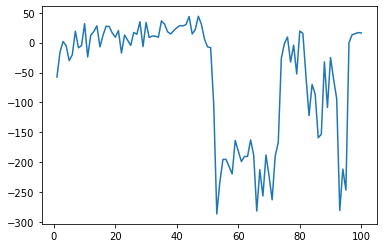

In [13]:
x = np.arange(1,len(total_pro)+1)
y = total_pro
plt.plot(x,y)
plt.show()